In [1]:
from google.cloud import bigquery
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
client = bigquery.Client()

In [2]:
def run_query(query, estimate_cost = True):
    '''
        Prints the cost of running a bigquery
    '''
    dry_run_config = bigquery.QueryJobConfig(dry_run = estimate_cost)
    query_job = client.query(query, job_config = dry_run_config)
    
    if estimate_cost:
        print("Total bytes processed {} GB".format(query_job.total_bytes_processed / 10**9))
    
    return query_job.to_dataframe()

# Analysis

### DETR for videos

In [5]:
 %%bigquery detr_vid
select postId, (Total_Eng*0.4 + (ifnull(v_play95,0) + 0.47*ifnull(v_play5sec,0) + 0.16*ifnull(v_play,0))*0.6)/(views) as DETR_vid, 
FROM
(
    select postId, sum(ifnull(favs,0)) + sum(ifnull(shares,0)) + least(4*sum(ifnull(shares,0)),
    sum(ifnull(likes,0))) as Total_Eng,
    sum(vplay) as v_play,
    sum(vplay*( case when duration>0 and watch_time/duration>0.95 then 1 else 0 end)) as v_play95,
    sum(vplay*( case when watch_time>5 then 1 else 0 end) as v_play5sec
    count(1) as views
    from `sharechat-production.sc_golden_dataset.flat_table_v1`
    where time<'2022-12-22' and time>'2022-12-15' and contentType = 'video'
    group by postId
    having count(1)>0
) as A
ORDER BY DETR_vid

ImportError: The default BigQuery Storage API client cannot be used, install the missing google-cloud-bigquery-storage and pyarrow packages to use it. Alternatively, use the classic REST API by specifying the --use_rest_api magic option.

### Analysis of Image recall@k

In [60]:
%%bigquery recall50
with posts_detr as
(
    with post_creation as 
    (
        select postId
        from `maximal-furnace-783.sc_analytics.all_posts2`
        where time<'2022-12-22 00:00:00' and time>'2022-12-15 00:00:00' and composeType = 'image'
    ),
    posts_detr as
    (
        select postId, (Total_Eng+2)/(views+100) as DETR_img
        FROM
        (
            select postId, sum(ifnull(favs,0)) + sum(ifnull(shares,0)) + least(4*sum(ifnull(shares,0)),sum(ifnull(likes,0))) as Total_Eng,
            sum(views) as views
            from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
            where time<'2022-12-22 00:00:00' and time>'2022-12-15 00:00:00' and type = 'image'
            group by postId
            having views > 2000
        )
    )
    select a.postId, DETR_img
    from post_creation as a
    inner join posts_detr as b
    on a.postId = b.postId
    order by DETR_img DESC
),
next_1_hr_user_post as 
(
    select postId, userId, ifnull(likes,0)+ifnull(shares,0)+ifnull(favs,0)>0 as pos_eng
    from `sharechat-production.sc_golden_dataset.flat_table_v1`
    where time>'2022-12-22 00:00:00' and time<'2022-12-22 01:00:00'
),
next_1_hr_user as
(
    select userId, sum(ifnull(likes,0)+ifnull(shares,0)+ifnull(favs,0)) as Total_pos_eng, sum(ifnull(likes,0)) as Total_likes,
    sum(ifnull(favs,0)) as Total_favs, sum(ifnull(shares,0)) as Total_shares
    from `sharechat-production.sc_golden_dataset.flat_table_v1`
    where time>'2022-12-22 00:00:00' and time<'2022-12-22 01:00:00'
    group by userId
)
select B.userId, sum(case when pos_eng = True then 1 else 0 end)/least(greatest(Total_pos_eng,1),100) as recall_50, Total_likes, Total_favs, Total_shares
from posts_detr as A
inner join next_1_hr_user_post as B
on A.postId = B.postId
inner join next_1_hr_user as C
on B.userId = C.userId
group by userId, Total_pos_eng, Total_likes, Total_favs, Total_shares

Downloading: 100%|██████████| 64367/64367 [00:02<00:00, 31858.98rows/s]


In [13]:
def get_img_posts_detr(start_time = '2022-12-15 00:00:00', end_time = '2022-12-23 00:00:00', dryRun = False):
    
    query = """
        with post_creation as 
        (
            select postId,language,time
            from `maximal-furnace-783.sc_analytics.all_posts2`
            where time<'{1}' and time>'{0}' and composeType = 'image'
        ),
        posts_detr as
        (
            select postId, (Total_Eng+2)/(views+100) as DETR_img
            FROM
            (
                select postId, sum(ifnull(favs,0)) + sum(ifnull(shares,0)) + least(4*sum(ifnull(shares,0)),sum(ifnull(likes,0))) as Total_Eng,
                sum(views) as views
                from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                where time<'{1}' and time>'{0}' and type = 'image'
                group by postId
            )
        )
        select a.postId, a.language, a.time as postTime, DETR_img
        from post_creation as a
        inner join posts_detr as b
        on a.postId = b.postId
        order by DETR_img DESC
    """.format(start_time, end_time)
    
    dry_run_config = bigquery.QueryJobConfig(dry_run = dryRun)
    query_job = client.query(query, job_config = dry_run_config)
    
    if dryRun:
        print("Total bytes processed {} GB".format(query_job.total_bytes_processed / 10**9))
    
    return query_job.to_dataframe()

get_img_posts_detr(dryRun = True)

Total bytes processed 163.889300386 GB


""


In [33]:
def get_1day_user_post(date = "2022-12-22",  dryRun = False):
    query = """
        select postId, userId, time, ifnull(likes,0) as likes, ifnull(shares,0) as shares, ifnull(favs,0) as favs, contentType
        from `sharechat-production.sc_golden_dataset.flat_table_v1`
        where date(time) = '{0}' and ( contentType = 'image' or contentType = 'video')
    """.format(date)
    
    dry_run_config = bigquery.QueryJobConfig(dry_run = dryRun)
    query_job = client.query(query, job_config = dry_run_config)
    
    if dryRun:
        print("Total bytes processed {} GB".format(query_job.total_bytes_processed / 10**9))
    
    return query_job.to_dataframe()

get_1day_user_post(dryRun = True)

Total bytes processed 330.984592609 GB


""


In [34]:
img_posts_detr_df = get_img_posts_detr(start_time = '2022-12-15 00:00:00', end_time = '2022-12-23 00:00:00', dryRun = True)
user_post_df = get_1day_user_post(date = "2022-12-22",  dryRun = True)

Total bytes processed 163.889300386 GB
Total bytes processed 330.984592609 GB


In [ ]:
def kRecall_user_img(k = 50, date = '2022-12-22'):
    
    query = """
        with posts_detr as
        (
            select * 
            from img_posts_detr_df
            where time >= '{1} {2}:00:00' and time < '{1} {2}:00:00'
            limit {0}
        ),
        next_1_hr_user as
        (
            select userId, sum(likes + shares + favs) as Total_pos_eng, sum(likes) as Total_likes,
            sum(favs) as Total_favs, sum(shares) as Total_shares
            from user_post_df
            where time<'{3}' and time>'{2}' and contentType = 'image'
            group by userId
        )
        
    """

In [57]:
def get_user_recall_k(k=50, start_time = '2022-12-15 00:00:00', end_time = '2022-12-22 00:00:00', end_eval_time = '2022-12-22 01:00:00', dryRun = False):
    
    query = """
        with posts_detr as
        (
            with post_creation as 
            (
                select postId,language
                from `maximal-furnace-783.sc_analytics.all_posts2`
                where time<'{2}' and time>'{1}' and composeType = 'image'
            ),
            posts_detr as
            (
                select postId, (Total_Eng+2)/(views+100) as DETR_img
                FROM
                (
                    select postId, sum(ifnull(favs,0)) + sum(ifnull(shares,0)) + least(4*sum(ifnull(shares,0)),sum(ifnull(likes,0))) as Total_Eng,
                    sum(views) as views
                    from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                    where time<'{2}' and time>'{1}' and type = 'image'
                    group by postId
                )
            )
            select a.postId, a.language, DETR_img
            from post_creation as a
            inner join posts_detr as b
            on a.postId = b.postId
            order by DETR_img DESC
            limit {0}
        ),
        next_1_hr_user_post as 
        (
            select postId, userId, ifnull(likes,0)+ifnull(shares,0)+ifnull(favs,0)>0 as pos_eng
            from `sharechat-production.sc_golden_dataset.flat_table_v1`
            where time<'{3}' and time>'{2}' and contentType = 'image'
        ),
        next_1_hr_user as
        (
            select userId, sum(ifnull(likes,0)+ifnull(shares,0)+ifnull(favs,0)) as Total_pos_eng, sum(ifnull(likes,0)) as Total_likes,
            sum(ifnull(favs,0)) as Total_favs, sum(ifnull(shares,0)) as Total_shares
            from `sharechat-production.sc_golden_dataset.flat_table_v1`
            where time<'{3}' and time>'{2}' and contentType = 'image'
            group by userId
        )
        select B.userId, sum(case when pos_eng = True then 1 else 0 end)/least(greatest(Total_pos_eng,1),100) as recall_{0},
        Total_likes, Total_favs, Total_shares, Total_pos_eng
        from posts_detr as A
        inner join next_1_hr_user_post as B
        on A.postId = B.postId
        inner join next_1_hr_user as C
        on B.userId = C.userId
        group by userId, Total_pos_eng, Total_likes, Total_favs, Total_shares, Total_pos_eng
    """.format(k, start_time, end_time, end_eval_time) 
    
    
    dry_run_config = bigquery.QueryJobConfig(dry_run = dryRun)
    query_job = client.query(query, job_config = dry_run_config)
    
    if dryRun:
        print("Total bytes processed {} GB".format(query_job.total_bytes_processed / 10**9))
    
    return query_job.to_dataframe()

get_user_recall_k(dryRun = True)

Total bytes processed 473.84978649 GB


""


In [ ]:
recall50 = get_user_recall_k(k=50, start_time = '2022-12-15 00:00:00', end_time = '2022-12-22 00:00:00', end_eval_time = '2022-12-22 01:00:00', dryRun = False)

In [61]:
like_cohorts = [25,50,75,90,95,100]
def mark_cohorts_like(x):
    Total_pos_eng = x.Total_likes + x.Total_shares + x.Total_favs
    if Total_pos_eng == 0:
        return 'NaN'
    if x.Total_likes/Total_pos_eng<0.25:
        return 'user_25'
    elif x.Total_likes/Total_pos_eng<0.5:
        return 'user_50'
    elif x.Total_likes/Total_pos_eng<0.75:
        return 'user_75'
    elif x.Total_likes/Total_pos_eng<0.9:
        return 'user_90'
    elif x.Total_likes/Total_pos_eng<0.95:
        return 'user_95'
    else:
        return 'user_100'
    
def mark_eng_type(x):
    Total_pos_eng = x.Total_likes + x.Total_shares + x.Total_favs
    if Total_pos_eng == 0:
        return 'NaN'
    if x.Total_likes/Total_pos_eng > 0.5:
        return 'like_heavy'
    elif x.Total_favs/Total_pos_eng > 0.5:
        return 'fav_heavy'
    elif x.Total_shares/Total_pos_eng > 0.5:
        return 'share_heavy'
    else: 
        return 'NaN'

recall50['like_cohorts'] = recall50.apply(mark_cohorts_like, axis = 1)
recall50['user_eng_type'] = recall50.apply(mark_eng_type, axis = 1)

In [62]:
recall50.groupby(['like_cohorts']).mean()

,recall_50,Total_likes,Total_favs,Total_shares
like_cohorts,,,,
NaN,0.000000,0.000000,0.000000,0.000000
user_100,0.046785,9.439841,0.096032,0.038571
user_25,0.050594,0.107127,2.732756,1.056149
user_50,0.026241,2.463011,3.256533,1.259477
user_75,0.025639,5.364513,2.576780,0.832202
user_90,0.026563,15.269520,2.246928,0.921918
user_95,0.020873,28.238871,1.549403,0.763301


In [63]:
recall50.groupby(['user_eng_type']).mean()

,recall_50,Total_likes,Total_favs,Total_shares
user_eng_type,,,,
NaN,0.003740,0.198685,0.192972,0.130198
fav_heavy,0.044572,0.385835,4.259844,0.127095
like_heavy,0.036115,11.898541,1.371054,0.475727
share_heavy,0.056286,0.194230,0.155410,2.756984


In [64]:
recall50[['recall_50','Total_likes','Total_favs','Total_shares']].mean()

recall_50       0.025266
Total_likes     2.445710
Total_favs      1.326798
Total_shares    0.505803
dtype: float64

### Analysis of Video Recall@k

In [66]:
def get_user_recall_k_vid(k=50, start_time = '2022-12-15 00:00:00', end_time = '2022-12-22 00:00:00', end_eval_time = '2022-12-22 16:00:00', dryRun = False):
    
    query = """
        with posts_detr as
        (
            with post_creation as 
            (
                select postId,language
                from `maximal-furnace-783.sc_analytics.all_posts2`
                where time<'{2}' and time>'{1}' and composeType = 'video'
            )
            select A.postId, (Total_Eng*0.4 + (ifnull(v_play95,0) + 0.47*ifnull(v_play5sec,0) + 0.16*ifnull(v_play,0))*0.6)/(views) as DETR_vid, 
            FROM
            (
                select postId, sum(ifnull(favs,0)) + sum(ifnull(shares,0)) + least(4*sum(ifnull(shares,0)),
                sum(ifnull(likes,0))) as Total_Eng,
                sum(vplay) as v_play,
                sum(vplay*( case when duration>0 and watch_time/duration>0.95 then 1 else 0 end)) as v_play95,
                sum(vplay*( case when watch_time>5 then 1 else 0 end)) as v_play5sec,
                count(1) as views
                from `sharechat-production.sc_golden_dataset.flat_table_v1`
                where contentType = 'video' and time<'{2}' and time>'{1}'
                group by postId
            ) as A
            inner join post_creation as B
            on A.postId = B.postId
            ORDER BY DETR_vid DESC
            limit {0} 
        ),
        next_1_hr_user_post as 
        (
            select postId, userId, ifnull(likes,0)+ifnull(shares,0)+ifnull(favs,0)>0 as pos_eng
            from `sharechat-production.sc_golden_dataset.flat_table_v1`
            where time<'{3}' and time>'{2}' and contentType = 'video'
        ),
        next_1_hr_user as
        (
            select userId, sum(ifnull(likes,0)+ifnull(shares,0)+ifnull(favs,0)) as Total_pos_eng, sum(ifnull(likes,0)) as Total_likes,
            sum(ifnull(favs,0)) as Total_favs, sum(ifnull(shares,0)) as Total_shares
            from `sharechat-production.sc_golden_dataset.flat_table_v1`
            where time<'{3}' and time>'{2}' and contentType = 'video'
            group by userId
        )
        select B.userId, sum(case when pos_eng = True then 1 else 0 end)/least(greatest(Total_pos_eng,1),100) as recall_{0},
        Total_likes, Total_favs, Total_shares, Total_pos_eng
        from posts_detr as A
        inner join next_1_hr_user_post as B
        on A.postId = B.postId
        inner join next_1_hr_user as C
        on B.userId = C.userId
        group by userId, Total_pos_eng, Total_likes, Total_favs, Total_shares, Total_pos_eng
    """.format(k, start_time, end_time, end_eval_time) 
    
    
    dry_run_config = bigquery.QueryJobConfig(dry_run = dryRun)
    query_job = client.query(query, job_config = dry_run_config)
    
    if dryRun:
        print("Total bytes processed {} GB".format(query_job.total_bytes_processed / 10**9))
    
    return query_job.to_dataframe()

get_user_recall_k_vid(k=50, start_time = '2022-12-15 00:00:00', end_time = '2022-12-22 00:00:00', end_eval_time = '2022-12-22 01:00:00', dryRun = True)

Total bytes processed 2974.358956365 GB


""


In [ ]:
recall_video200 = get_user_recall_k_vid(k=200, start_time = '2022-12-15 00:00:00', end_time = '2022-12-22 00:00:00', end_eval_time = '2022-12-22 01:00:00', dryRun = False)

In [ ]:

def mark_cohorts_like(x):
    if x.Total_pos_eng == 0:
        return 'NaN'
    if x.Total_likes/x.Total_pos_eng<0.25:
        return 'user_25'
    elif x.Total_likes/x.Total_pos_eng<0.5:
        return 'user_50'
    elif x.Total_likes/x.Total_pos_eng<0.75:
        return 'user_75'
    elif x.Total_likes/x.Total_pos_eng<0.9:
        return 'user_90'
    elif x.Total_likes/x.Total_pos_eng<0.95:
        return 'user_95'
    else:
        return 'user_100'
    
def mark_eng_type(x):
    if x.Total_pos_eng == 0:
        return 'NaN'
    if x.Total_likes/x.Total_pos_eng > 0.5:
        return 'like_heavy'
    elif x.Total_favs/x.Total_pos_eng > 0.5:
        return 'fav_heavy'
    elif x.Total_shares/x.Total_pos_eng > 0.5:
        return 'share_heavy'
    else: 
        return 'NaN'

recall_video200['like_cohorts'] = recall_video200.apply(mark_cohorts_like, axis = 1)
recall_video200['user_eng_type'] = recall_video200.apply(mark_eng_type, axis = 1)

In [ ]:
recall_video200.groupby(['like_cohorts']).mean()

In [ ]:
recall_video200.groupby(['user_eng_type']).mean()

In [ ]:
recall_video200[['recall_200','Total_likes','Total_favs','Total_shares','Total_pos_eng']].mean()

### Cluster Analysis

In [31]:
%%bigquery --use_rest_api
with user_metrics as
(
    select userId, sum(ifnull(imageViews,0)) as views
    from `sharechat-production.sc_golden_dataset.user_metrics`
    where dt = '2022-10-12'
    group by userId
)
select avg(views) as average, stddev(views) as std
from user_metrics

Query is running:   0%|          |

Downloading:   0%|          |

,average,std
0,19.591991,43.33042


In [3]:
ratio_cluster = """
    with user_ratios as 
    (
        select userId, cast( log(sum(ifnull(likes,0))/(sum(ifnull(likes,0)) + sum(ifnull(shares,0)) + sum(ifnull(favs,0))) + 1)*1000 as int64) as like_ratio
        from `sharechat-production.sc_golden_dataset.flat_table_v1`
        where date(time) = '{0}' and contentType = 'image' and post_lang in ('Hindi','Tamil','Telugu')
        group by userId
        having sum(ifnull(likes,0)) + sum(ifnull(shares,0)) + sum(ifnull(favs,0)) > 20 and (sum(ifnull(shares,0)) + sum(ifnull(favs,0)))>0
    )
    select count(1) as user_freq, like_ratio
    from user_ratios
    group by like_ratio
"""

run_query(ratio_cluster.format('2022-12-22'))

Total bytes processed 309.277901885 GB


""


In [4]:
like_cluster = run_query(ratio_cluster.format('2023-01-11'), estimate_cost = False)

<AxesSubplot:xlabel='like_ratio', ylabel='user_freq'>

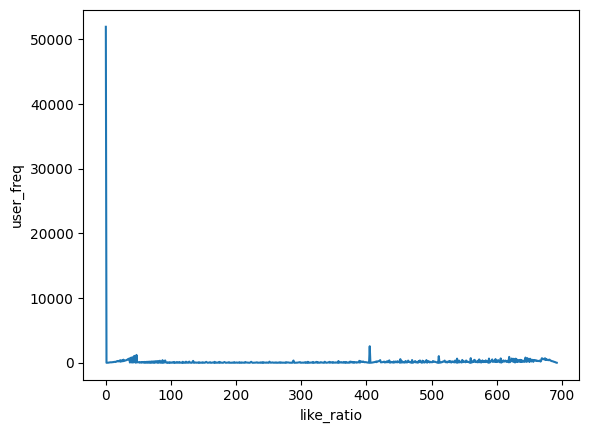

In [5]:
sns.lineplot(data = like_cluster, x = 'like_ratio', y ='user_freq')

In [22]:
like_cluster.describe()

,user_freq,like_ratio
count,1.010000e+02,101.000000
mean,9.139779e+04,50.000000
std,7.063900e+05,29.300171
min,1.890000e+02,0.000000
25%,2.172000e+03,25.000000
50%,4.174000e+03,50.000000
75%,1.009200e+04,75.000000
max,7.062516e+06,100.000000


In [56]:
%%bigquery --use_rest_api
with recall as(
    with post_detr as
    (
        with post_creation as 
        (
            select postId, language
            from `maximal-furnace-783.sc_analytics.all_posts2`
            where time between '2022-12-15' and '2022-12-23' and composeType = 'image' and language in ('Hindi','Tamil','Telugu')
        ),
        post_hour_counts as
        (
            with post_dets as
            (
                with hour_counts as
                (
                    select postId, date(time) as day, extract(hour from time) as hour_of_day,
                    sum(ifnull(favs,0)) + sum(ifnull(shares,0)) + least(sum(4*ifnull(shares,0)) ,sum(ifnull(likes,0))) as hour_eng,
                    sum(ifnull(views,0)) as hour_views,
                    from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                    where date(time) between '2022-12-21' and '2022-12-22' and type = 'image' and language in ('Hindi','Tamil','Telugu')
                    group by postId, day, hour_of_day
                ),
                hours_day as
                (    
                    
                    with dates as
                    (
                        select day from unnest(generate_date_array('2022-12-21','2022-12-22')) as day
                    ),
                    hours as 
                    (
                        SELECT hour FROM UNNEST(GENERATE_ARRAY(0, 23)) AS hour
                    ),
                    posts as 
                    (
                        select distinct postId
                        from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                        where date(time) between '2022-12-21' and '2022-12-22' and type = 'image' and language in ('Hindi','Tamil','Telugu')
                    )
                    select postId, dates.day, hours.hour 
                    from dates cross join hours
                    cross join posts
                )
            
                select A.postId, A.day, A.hour as hour_of_day, ifnull(hour_eng,0) as hour_eng, ifnull(hour_views,0) as hour_views
                from hours_day as A
                left join hour_counts as B on A.postId = B.postId and A.hour = B.hour_of_day and A.day = B.day
            )
            select postId, day, hour_of_day,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 2 preceding and current row) as lag0_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 2 preceding and current row) as lag0_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 5 preceding and 3 preceding) as lag1_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 5 preceding and 3 preceding) as lag1_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 11 preceding and 9 preceding) as lag3_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 11 preceding and 9 preceding) as lag3_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 24 preceding and 21 preceding) as lag7_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 24 preceding and 21 preceding) as lag7_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 27 preceding and 24 preceding) as lag8_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 27 preceding and 24 preceding) as lag8_views
            from post_dets
        )
            select A.postId, language, hour_of_day,
            row_number() over 
                (partition by language, hour_of_day 
                order by 
                 (hr24_eng+2)/(hr24_views +100) + 0.5*(lag0_eng+2)/(lag0_views+1000)
                 -- + 0.7772*log(((lag1_eng+2)/(lag1_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 -- + 0.0448*log(((lag3_eng+2)/(lag3_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 --  + 0.5305*log(((lag7_eng+2)/(lag7_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 -- - 0.2466*log(((lag8_eng+2)/(lag8_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 
                 DESC ) as rownum
            from post_hour_counts as A
            inner join post_creation as B
            on A.postId = B.postId
            where A.day = '2022-12-22' 
    ),
    user_engagements as
    (
        select userId, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0)) as pos_eng, post_lang, 
        sum(ifnull(likes,0)) as total_likes, sum(ifnull(shares,0)) as total_shares, sum(ifnull(favs,0)) as total_favs
        from `sharechat-production.sc_golden_dataset.flat_table_v1`
        where date(time) = '2022-12-22' and contentType = 'image' and post_lang in ('Hindi','Tamil','Telugu')
        group by userId, post_lang
        having total_likes/(pos_eng+1) = 0.0
    )
    select B.userId,
    B.post_lang as language, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))/least(500,min(B.pos_eng)+1) as recall_k,
    sum(ifnull(likes,0))/(least(min(total_likes), count(1))+1) as like_recall,
    sum(ifnull(shares,0))/(least(min(total_shares), count(1))+1) as share_recall,
    sum(ifnull(favs,0))/(least(min(total_favs), count(1))+1) as fav_recall,
    from `sharechat-production.sc_golden_dataset.flat_table_v1` as A
    inner join user_engagements as B on A.userId = B.userId
    inner join post_detr as C on A.postId = C.postId and C.hour_of_day + 1 = extract(hour from A.time) and B.post_lang = C.language
    where date(A.time) = '2022-12-22' and C.rownum<=500
    group by B.userId, B.post_lang
)
select language, avg(recall_k) as recall_k, avg(like_recall) as like_recall, avg(share_recall) as share_recall, avg(fav_recall) as fav_recall, count(userId) as user_count
from recall
group by language
order by language

Query is running:   0%|          |

Downloading:   0%|          |

,language,recall_k,like_recall,share_recall,fav_recall,user_count
0,Hindi,0.083360,0.0,0.039885,0.051684,5122413
1,Tamil,0.083043,0.0,0.046912,0.044113,2181311
2,Telugu,0.080225,0.0,0.045050,0.041815,1643051


In [57]:
%%bigquery --use_rest_api
with recall as(
    with post_detr as
    (
        with post_creation as 
        (
            select postId, language
            from `maximal-furnace-783.sc_analytics.all_posts2`
            where time between '2022-12-15' and '2022-12-23' and composeType = 'image' and language in ('Hindi','Tamil','Telugu')
        ),
        post_hour_counts as
        (
            with post_dets as
            (
                with hour_counts as
                (
                    select postId, date(time) as day, extract(hour from time) as hour_of_day,
                    sum(ifnull(favs,0)) + sum(ifnull(shares,0))  as hour_eng,
                    sum(ifnull(views,0)) as hour_views,
                    from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                    where date(time) between '2022-12-21' and '2022-12-22' and type = 'image' and language in ('Hindi','Tamil','Telugu')
                    group by postId, day, hour_of_day
                ),
                hours_day as
                (    
                    
                    with dates as
                    (
                        select day from unnest(generate_date_array('2022-12-21','2022-12-22')) as day
                    ),
                    hours as 
                    (
                        SELECT hour FROM UNNEST(GENERATE_ARRAY(0, 23)) AS hour
                    ),
                    posts as 
                    (
                        select distinct postId
                        from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                        where date(time) between '2022-12-21' and '2022-12-22' and type = 'image' and language in ('Hindi','Tamil','Telugu')
                    )
                    select postId, dates.day, hours.hour 
                    from dates cross join hours
                    cross join posts
                )
            
                select A.postId, A.day, A.hour as hour_of_day, ifnull(hour_eng,0) as hour_eng, ifnull(hour_views,0) as hour_views
                from hours_day as A
                left join hour_counts as B on A.postId = B.postId and A.hour = B.hour_of_day and A.day = B.day
            )
            select postId, day, hour_of_day,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 2 preceding and current row) as lag0_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 2 preceding and current row) as lag0_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 5 preceding and 3 preceding) as lag1_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 5 preceding and 3 preceding) as lag1_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 11 preceding and 9 preceding) as lag3_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 11 preceding and 9 preceding) as lag3_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 24 preceding and 21 preceding) as lag7_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 24 preceding and 21 preceding) as lag7_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 27 preceding and 24 preceding) as lag8_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 27 preceding and 24 preceding) as lag8_views
            from post_dets
        )
            select A.postId, language, hour_of_day,
            row_number() over 
                (partition by language, hour_of_day 
                order by 
                 (hr24_eng+2)/(hr24_views +100) + 2*(lag0_eng+2)/(lag0_views+1000)
                 -- + 0.7772*log(((lag1_eng+2)/(lag1_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 -- + 0.0448*log(((lag3_eng+2)/(lag3_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 --  + 0.5305*log(((lag7_eng+2)/(lag7_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 -- - 0.2466*log(((lag8_eng+2)/(lag8_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 
                 DESC ) as rownum
            from post_hour_counts as A
            inner join post_creation as B
            on A.postId = B.postId
            where A.day = '2022-12-22' 
    ),
    user_engagements as
    (
        select userId, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0)) as pos_eng, post_lang, 
        sum(ifnull(likes,0)) as total_likes, sum(ifnull(shares,0)) as total_shares, sum(ifnull(favs,0)) as total_favs
        from `sharechat-production.sc_golden_dataset.flat_table_v1`
        where date(time) = '2022-12-22' and contentType = 'image' and post_lang in ('Hindi','Tamil','Telugu')
        group by userId, post_lang
        having total_likes/(pos_eng+1) = 0.0
    )
    select B.userId,
    B.post_lang as language, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))/least(500,min(B.pos_eng)+1) as recall_k,
    sum(ifnull(likes,0))/(least(min(total_likes), count(1))+1) as like_recall,
    sum(ifnull(shares,0))/(least(min(total_shares), count(1))+1) as share_recall,
    sum(ifnull(favs,0))/(least(min(total_favs), count(1))+1) as fav_recall,
    from `sharechat-production.sc_golden_dataset.flat_table_v1` as A
    inner join user_engagements as B on A.userId = B.userId
    inner join post_detr as C on A.postId = C.postId and C.hour_of_day + 1 = extract(hour from A.time) and B.post_lang = C.language
    where date(A.time) = '2022-12-22' and C.rownum<=500
    group by B.userId, B.post_lang
)
select language, avg(recall_k) as recall_k, avg(like_recall) as like_recall, avg(share_recall) as share_recall, avg(fav_recall) as fav_recall, count(userId) as user_count
from recall
group by language
order by language

Query is running:   0%|          |

Downloading:   0%|          |

,language,recall_k,like_recall,share_recall,fav_recall,user_count
0,Hindi,0.088624,0.0,0.042562,0.054582,5085760
1,Tamil,0.087426,0.0,0.048780,0.046787,2234971
2,Telugu,0.084550,0.0,0.047156,0.044305,1658321


In [8]:
%%bigquery class_metrics_df --use_rest_api
with recall as(
    with post_detr as
    (
        with post_creation as 
        (
            select postId, language
            from `maximal-furnace-783.sc_analytics.all_posts2`
            where time between '2022-12-15' and '2022-12-23' and composeType = 'image' and language in ('Hindi','Tamil','Telugu')
        ),
        post_hour_counts as
        (
            with post_dets as
            (
                with hour_counts as
                (
                    select postId, date(time) as day, extract(hour from time) as hour_of_day,
                    sum(ifnull(favs,0)) + sum(ifnull(shares,0)) + least(sum(4*ifnull(shares,0)) ,sum(ifnull(likes,0))) as hour_eng,
                    sum(ifnull(views,0)) as hour_views,
                    from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                    where date(time) between '2022-12-21' and '2022-12-22' and type = 'image' and language in ('Hindi','Tamil','Telugu')
                    group by postId, day, hour_of_day
                ),
                hours_day as
                (    
                    
                    with dates as
                    (
                        select day from unnest(generate_date_array('2022-12-21','2022-12-22')) as day
                    ),
                    hours as 
                    (
                        SELECT hour FROM UNNEST(GENERATE_ARRAY(0, 23)) AS hour
                    ),
                    posts as 
                    (
                        select distinct postId
                        from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                        where date(time) between '2022-12-21' and '2022-12-22' and type = 'image' and language in ('Hindi','Tamil','Telugu')
                    )
                    select postId, dates.day, hours.hour 
                    from dates cross join hours
                    cross join posts
                )
            
                select A.postId, A.day, A.hour as hour_of_day, ifnull(hour_eng,0) as hour_eng, ifnull(hour_views,0) as hour_views
                from hours_day as A
                left join hour_counts as B on A.postId = B.postId and A.hour = B.hour_of_day and A.day = B.day
            )
            select postId, day, hour_of_day,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 2 preceding and current row) as lag0_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 2 preceding and current row) as lag0_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 5 preceding and 3 preceding) as lag1_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 5 preceding and 3 preceding) as lag1_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 11 preceding and 9 preceding) as lag3_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 11 preceding and 9 preceding) as lag3_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 24 preceding and 21 preceding) as lag7_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 24 preceding and 21 preceding) as lag7_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 27 preceding and 24 preceding) as lag8_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 27 preceding and 24 preceding) as lag8_views
            from post_dets
        )
            select A.postId, language, hour_of_day,
            row_number() over 
                (partition by language, hour_of_day 
                order by 
                 (hr24_eng+2)/(hr24_views +100) + 2*(lag0_eng+2)/(lag0_views+1000)
                 -- + 0.7772*log(((lag1_eng+2)/(lag1_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 -- + 0.0448*log(((lag3_eng+2)/(lag3_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 --  + 0.5305*log(((lag7_eng+2)/(lag7_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 -- - 0.2466*log(((lag8_eng+2)/(lag8_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 
                 DESC ) as rownum
            from post_hour_counts as A
            inner join post_creation as B
            on A.postId = B.postId
            where A.day = '2022-12-22' 
    ),
    user_engagements as
    (
        select userId, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0)) as pos_eng, post_lang, 
        sum(ifnull(likes,0)) as total_likes, sum(ifnull(shares,0)) as total_shares, sum(ifnull(favs,0)) as total_favs,
        cast(sum(ifnull(likes,0))*1000.0/(sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0)) + 1 ) as int64) as user_like_class
        from `sharechat-production.sc_golden_dataset.flat_table_v1`
        where date(time) = '2022-12-22' and contentType = 'image' and post_lang in ('Hindi','Tamil','Telugu')
        group by userId, post_lang
    )
    select B.userId, B.user_like_class,
    B.post_lang as language, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))/least(500,min(B.pos_eng)+1) as recall_k,
    sum(ifnull(likes,0))/(least(min(total_likes), count(1))+1) as like_recall,
    sum(ifnull(shares,0))/(least(min(total_shares), count(1))+1) as share_recall,
    sum(ifnull(favs,0))/(least(min(total_favs), count(1))+1) as fav_recall,
    from `sharechat-production.sc_golden_dataset.flat_table_v1` as A
    inner join user_engagements as B on A.userId = B.userId
    inner join post_detr as C on A.postId = C.postId and C.hour_of_day + 1 = extract(hour from A.time) and B.post_lang = C.language
    where date(A.time) = '2022-12-22' and C.rownum<=500
    group by B.userId, B.user_like_class, B.post_lang
)
select language, user_like_class, avg(recall_k) as recall_k, avg(like_recall) as like_recall, avg(share_recall) as share_recall, avg(fav_recall) as fav_recall, count(userId) as user_count
from recall
group by language, user_like_class
order by language, user_like_class

Query is running:   0%|          |

Downloading:   0%|          |

<AxesSubplot:xlabel='user_like_class', ylabel='recall_k'>

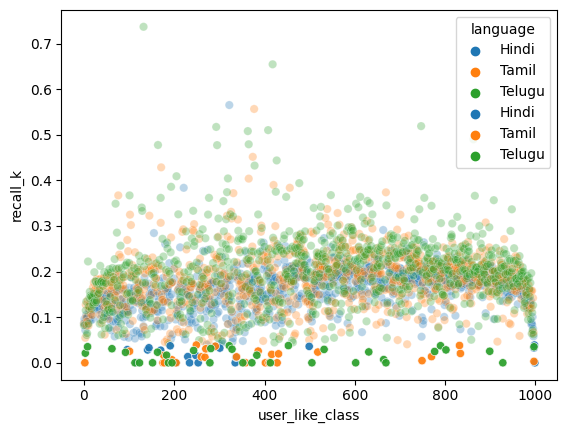

In [59]:
sns.scatterplot(data = class_metrics_df, x = 'user_like_class' , y = 'recall_k', hue = 'language', alpha = 0.3, ax = plt.gca())
sns.scatterplot(data = class_metrics_df[class_metrics_df.recall_k < 0.04], x = 'user_like_class' , y = 'recall_k', hue = 'language', alpha = 0.9, ax = plt.gca())

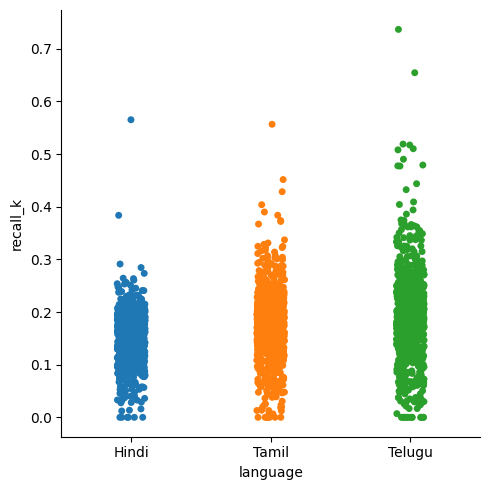

In [25]:
sns.catplot(data = class_metrics_df, x = 'language', y = 'recall_k')

In [40]:
class_metrics_df[class_metrics_df.language == 'Telugu'].tail(20)

,language,user_like_class,recall_k,like_recall,share_recall,fav_recall,user_count
2712,Telugu,978,0.175434,0.410787,0.008621,0.034483,29
2713,Telugu,979,0.153689,0.419790,0.000000,0.006667,30
2714,Telugu,980,0.148573,0.435787,0.017857,0.000000,28
2715,Telugu,981,0.166995,0.369189,0.013514,0.013514,37
2716,Telugu,982,0.190954,0.483079,0.000000,0.037037,27
2717,Telugu,983,0.183400,0.381545,0.000000,0.023810,21
2718,Telugu,984,0.094610,0.357323,0.013333,0.020000,25
2719,Telugu,985,0.108883,0.383402,0.000000,0.000000,22
2720,Telugu,986,0.186476,0.515425,0.000000,0.000000,21
2721,Telugu,987,0.161244,0.526147,0.000000,0.022727,22


### Analyzing like, share, fav ratio on the basis of user cohorts

In [40]:
%%bigquery cohort_analysis_df
with posts_detr as 
(
    --Returns DETR scores for posts
    
    select postId, 
    case
        when (sum(ifnull(favs,0)) + sum(ifnull(shares,0)) + least(4*sum(ifnull(shares,0)),sum(ifnull(likes,0)))+2)/ sum(ifnull(views,0)+2) < 0.1 then 'detr_00_10'
        when (sum(ifnull(favs,0)) + sum(ifnull(shares,0)) + least(4*sum(ifnull(shares,0)),sum(ifnull(likes,0)))+2)/ sum(ifnull(views,0)+2) < 0.2 then 'detr_10_20'
        when (sum(ifnull(favs,0)) + sum(ifnull(shares,0)) + least(4*sum(ifnull(shares,0)),sum(ifnull(likes,0)))+2)/ sum(ifnull(views,0)+2) < 0.3 then 'detr_20_30'
        when (sum(ifnull(favs,0)) + sum(ifnull(shares,0)) + least(4*sum(ifnull(shares,0)),sum(ifnull(likes,0)))+2)/ sum(ifnull(views,0)+2) < 0.4 then 'detr_30_40'
        when (sum(ifnull(favs,0)) + sum(ifnull(shares,0)) + least(4*sum(ifnull(shares,0)),sum(ifnull(likes,0)))+2)/ sum(ifnull(views,0)+2) < 0.5 then 'detr_40_50'
        when (sum(ifnull(favs,0)) + sum(ifnull(shares,0)) + least(4*sum(ifnull(shares,0)),sum(ifnull(likes,0)))+2)/ sum(ifnull(views,0)+2) < 0.6 then 'detr_50_60'
        when (sum(ifnull(favs,0)) + sum(ifnull(shares,0)) + least(4*sum(ifnull(shares,0)),sum(ifnull(likes,0)))+2)/ sum(ifnull(views,0)+2) < 0.7 then 'detr_60_70'
        when (sum(ifnull(favs,0)) + sum(ifnull(shares,0)) + least(4*sum(ifnull(shares,0)),sum(ifnull(likes,0)))+2)/ sum(ifnull(views,0)+2) < 0.8 then 'detr_70_80'
        when (sum(ifnull(favs,0)) + sum(ifnull(shares,0)) + least(4*sum(ifnull(shares,0)),sum(ifnull(likes,0)))+2)/ sum(ifnull(views,0)+2) < 0.9 then 'detr_80_90'
        else 'detr_90_100'
        end as DETR_img_groups
    from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
    where time<'2022-12-22 00:00:00' and time>'2022-12-15 00:00:00' and type = 'image'
    group by postId
), 
user_cohorts as
(
    -- Groups users according to cohorts they belong in buckets of 0-25, 25-50, 50-75, 75-90, 90-95, 95-100
    
    select userID,
    case 
        when sum(ifnull(image_likes,0)) + sum(ifnull(image_shares,0)) + sum(ifnull(image_favs,0)) = 0 then 'user_nan'
        when sum(ifnull(image_likes,0))/(sum(ifnull(image_likes,0)) + sum(ifnull(image_shares,0)) + sum(ifnull(image_favs,0))) < 0.25 then 'user_00_25'
        when sum(ifnull(image_likes,0))/(sum(ifnull(image_likes,0)) + sum(ifnull(image_shares,0)) + sum(ifnull(image_favs,0))) < 0.50 then 'user_25_50'
        when sum(ifnull(image_likes,0))/(sum(ifnull(image_likes,0)) + sum(ifnull(image_shares,0)) + sum(ifnull(image_favs,0))) < 0.75 then 'user_50_75'
        when sum(ifnull(image_likes,0))/(sum(ifnull(image_likes,0)) + sum(ifnull(image_shares,0)) + sum(ifnull(image_favs,0))) < 0.90 then 'user_75_90'
        when sum(ifnull(image_likes,0))/(sum(ifnull(image_likes,0)) + sum(ifnull(image_shares,0)) + sum(ifnull(image_favs,0))) < 0.95 then 'user_90_95'
        else 'user_95_100'
        end as user_cohort
    from `maximal-furnace-783.feed_pod_data.User_Eng_PreAgg`
    where day<'2022-12-22' and day>'2022-12-15'
    group by userID
    having not user_cohort = 'user_nan'
)
select user_cohort, DETR_img_groups, 
sum(ifnull(likes,0))/count(1) as like_ratio, 
sum(ifnull(shares,0))/count(1) as share_ratio, 
sum(ifnull(favs,0))/count(1) as fav_ratio, 
from `sharechat-production.sc_golden_dataset.flat_table_v1` as A
inner join posts_detr as B on A.postId = B.postId
inner join user_cohorts as C on A.userId = C.userID
where A.time > '2022-12-22' and A.time < '2022-12-23' and postTime > '2022-12-15' and A.contentType = 'image'
group by user_cohort, DETR_img_groups
order by user_cohort, DETR_img_groups

Plot above data

In [36]:
%%bigquery --use_rest_api
with user_cohorts as
(
    -- Groups users according to cohorts they belong in buckets of 0-25, 25-50, 50-75, 75-90, 90-95, 95-100
    
    select userID,
    case 
        -- when sum(ifnull(image_likes,0)) + sum(ifnull(image_shares,0)) + sum(ifnull(image_favs,0)) = 0 then 'user_nan'
        when sum(ifnull(image_likes,0)+2)/(sum(ifnull(image_likes,0)) + sum(ifnull(image_shares,0)) + sum(ifnull(image_favs,0))+100) < 0.25 then 'user_00_25'
        when sum(ifnull(image_likes,0)+2)/(sum(ifnull(image_likes,0)) + sum(ifnull(image_shares,0)) + sum(ifnull(image_favs,0))+100) < 0.50 then 'user_25_50'
        when sum(ifnull(image_likes,0)+2)/(sum(ifnull(image_likes,0)) + sum(ifnull(image_shares,0)) + sum(ifnull(image_favs,0))+100) < 0.75 then 'user_50_75'
        when sum(ifnull(image_likes,0)+2)/(sum(ifnull(image_likes,0)) + sum(ifnull(image_shares,0)) + sum(ifnull(image_favs,0))+100) < 0.90 then 'user_75_90'
        when sum(ifnull(image_likes,0)+2)/(sum(ifnull(image_likes,0)) + sum(ifnull(image_shares,0)) + sum(ifnull(image_favs,0))+100) < 0.95 then 'user_90_95'
        else 'user_95_100'
        end as user_cohort
    from `maximal-furnace-783.feed_pod_data.User_Eng_PreAgg`
    where day<'2022-12-22' and day>'2022-12-15'
    group by userID
)
select user_cohort, count(1)
from user_cohorts
group by user_cohort
order by user_cohort

Query is running:   0%|          |

Downloading:   0%|          |

,user_cohort,f0_
0,user_00_25,49169072
1,user_25_50,1657037
2,user_50_75,221820
3,user_75_90,30927
4,user_90_95,2532
5,user_95_100,798


In [42]:
query = """
with posts_detr as 
(
    --Returns DETR scores for posts
    
    select postId, 
    case
        when (sum(ifnull(favs,0)) + sum(ifnull(shares,0)) + least(4*sum(ifnull(shares,0)),sum(ifnull(likes,0)))+2)/ (sum(ifnull(views,0))+100) < 0.1 then 'detr_00_10'
        when (sum(ifnull(favs,0)) + sum(ifnull(shares,0)) + least(4*sum(ifnull(shares,0)),sum(ifnull(likes,0)))+2)/ (sum(ifnull(views,0))+100) < 0.2 then 'detr_10_20'
        when (sum(ifnull(favs,0)) + sum(ifnull(shares,0)) + least(4*sum(ifnull(shares,0)),sum(ifnull(likes,0)))+2)/ (sum(ifnull(views,0))+100) < 0.3 then 'detr_20_30'
        when (sum(ifnull(favs,0)) + sum(ifnull(shares,0)) + least(4*sum(ifnull(shares,0)),sum(ifnull(likes,0)))+2)/ (sum(ifnull(views,0))+100) < 0.4 then 'detr_30_40'
        when (sum(ifnull(favs,0)) + sum(ifnull(shares,0)) + least(4*sum(ifnull(shares,0)),sum(ifnull(likes,0)))+2)/ (sum(ifnull(views,0))+100) < 0.5 then 'detr_40_50'
        when (sum(ifnull(favs,0)) + sum(ifnull(shares,0)) + least(4*sum(ifnull(shares,0)),sum(ifnull(likes,0)))+2)/ (sum(ifnull(views,0))+100) < 0.6 then 'detr_50_60'
        when (sum(ifnull(favs,0)) + sum(ifnull(shares,0)) + least(4*sum(ifnull(shares,0)),sum(ifnull(likes,0)))+2)/ (sum(ifnull(views,0))+100) < 0.7 then 'detr_60_70'
        when (sum(ifnull(favs,0)) + sum(ifnull(shares,0)) + least(4*sum(ifnull(shares,0)),sum(ifnull(likes,0)))+2)/ (sum(ifnull(views,0))+100) < 0.8 then 'detr_70_80'
        when (sum(ifnull(favs,0)) + sum(ifnull(shares,0)) + least(4*sum(ifnull(shares,0)),sum(ifnull(likes,0)))+2)/ (sum(ifnull(views,0))+100) < 0.9 then 'detr_80_90'
        else 'detr_90_100'
        end as DETR_img_groups
    from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
    where time<'2022-12-22 00:00:00' and time>'2022-12-15 00:00:00' and type = 'image'
    group by postId
    having sum(ifnull(views,0))>2000
), 
user_cohorts as
(
    -- Groups users according to cohorts they belong in buckets of 0-25, 25-50, 50-75, 75-90, 90-95, 95-100
    
    select userID,
    case 
        -- when sum(ifnull(image_likes,0)) + sum(ifnull(image_shares,0)) + sum(ifnull(image_favs,0)) = 0 then 'user_nan'
        when (sum(ifnull(image_likes,0))+2)/(sum(ifnull(image_likes,0)) + sum(ifnull(image_shares,0)) + sum(ifnull(image_favs,0))+100) < 0.25 then 'user_00_25'
        when (sum(ifnull(image_likes,0))+2)/(sum(ifnull(image_likes,0)) + sum(ifnull(image_shares,0)) + sum(ifnull(image_favs,0))+100) < 0.50 then 'user_25_50'
        when (sum(ifnull(image_likes,0))+2)/(sum(ifnull(image_likes,0)) + sum(ifnull(image_shares,0)) + sum(ifnull(image_favs,0))+100) < 0.75 then 'user_50_75'
        when (sum(ifnull(image_likes,0))+2)/(sum(ifnull(image_likes,0)) + sum(ifnull(image_shares,0)) + sum(ifnull(image_favs,0))+100) < 0.90 then 'user_75_90'
        when (sum(ifnull(image_likes,0))+2)/(sum(ifnull(image_likes,0)) + sum(ifnull(image_shares,0)) + sum(ifnull(image_favs,0))+100) < 0.95 then 'user_90_95'
        else 'user_95_100'
        end as user_cohort
    from `maximal-furnace-783.feed_pod_data.User_Eng_PreAgg`
    where day<'2022-12-22' and day>'2022-12-15'
    group by userID
    -- having not user_cohort = 'user_nan'
)
select user_cohort, DETR_img_groups, 
sum(ifnull(likes,0))/count(1) as like_ratio, 
sum(ifnull(shares,0))/count(1) as share_ratio, 
sum(ifnull(favs,0))/count(1) as fav_ratio, 
from `sharechat-production.sc_golden_dataset.flat_table_v1` as A
inner join posts_detr as B on A.postId = B.postId
inner join user_cohorts as C on A.userId = C.userID
where A.time > '2022-12-22' and A.time < '2022-12-23' and postTime > '2022-12-15' and A.contentType = 'image'
group by user_cohort, DETR_img_groups
order by user_cohort, DETR_img_groups
"""

In [43]:
cohort_analysis_df = run_query(query, estimate_cost = False)

In [44]:
cohort_analysis_df

,user_cohort,DETR_img_groups,like_ratio,share_ratio,fav_ratio
0,user_00_25,detr_00_10,0.005459,0.011232,0.026240
1,user_00_25,detr_10_20,0.006159,0.037617,0.035109
2,user_00_25,detr_20_30,0.017132,0.054207,0.041328
3,user_00_25,detr_30_40,0.013976,0.068042,0.044332
4,user_25_50,detr_00_10,0.109375,0.010305,0.036708
5,user_25_50,detr_10_20,0.144383,0.033612,0.045651
6,user_25_50,detr_20_30,0.204389,0.054333,0.045455
7,user_25_50,detr_30_40,0.212419,0.068808,0.049149
8,user_50_75,detr_00_10,0.199129,0.009170,0.027429
9,user_50_75,detr_10_20,0.243791,0.028078,0.033685


<AxesSubplot:xlabel='DETR_img_groups', ylabel='like_ratio'>

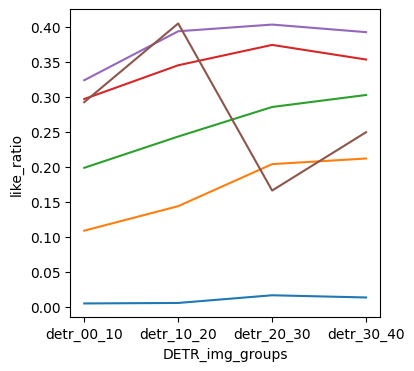

In [39]:
fig = plt.figure(figsize = (4,4))
sns.lineplot(x = 'DETR_img_groups', y = 'like_ratio', data = cohort_analysis_df, hue = 'user_cohort', figure = fig, legend = False)

<AxesSubplot:xlabel='DETR_img_groups', ylabel='share_ratio'>

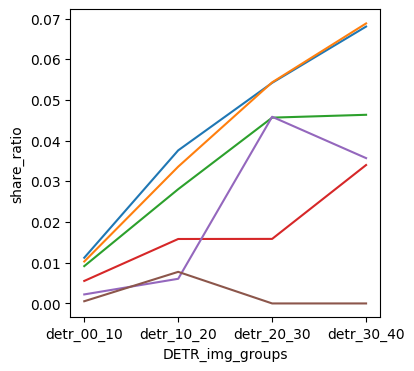

In [40]:
fig = plt.figure(figsize = (4,4))
sns.lineplot(x = 'DETR_img_groups', y = 'share_ratio', data = cohort_analysis_df, hue = 'user_cohort', figure = fig, legend = False)

<AxesSubplot:xlabel='DETR_img_groups', ylabel='fav_ratio'>

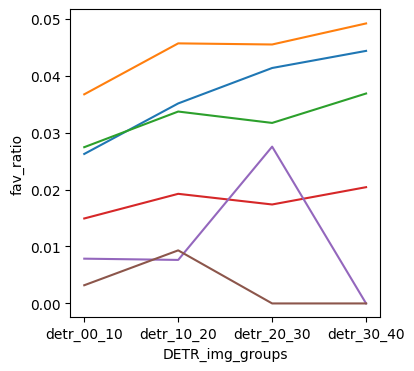

In [41]:
fig = plt.figure(figsize = (4,4))
sns.lineplot(x = 'DETR_img_groups', y = 'fav_ratio', data = cohort_analysis_df, hue = 'user_cohort', figure = fig, legend = False)

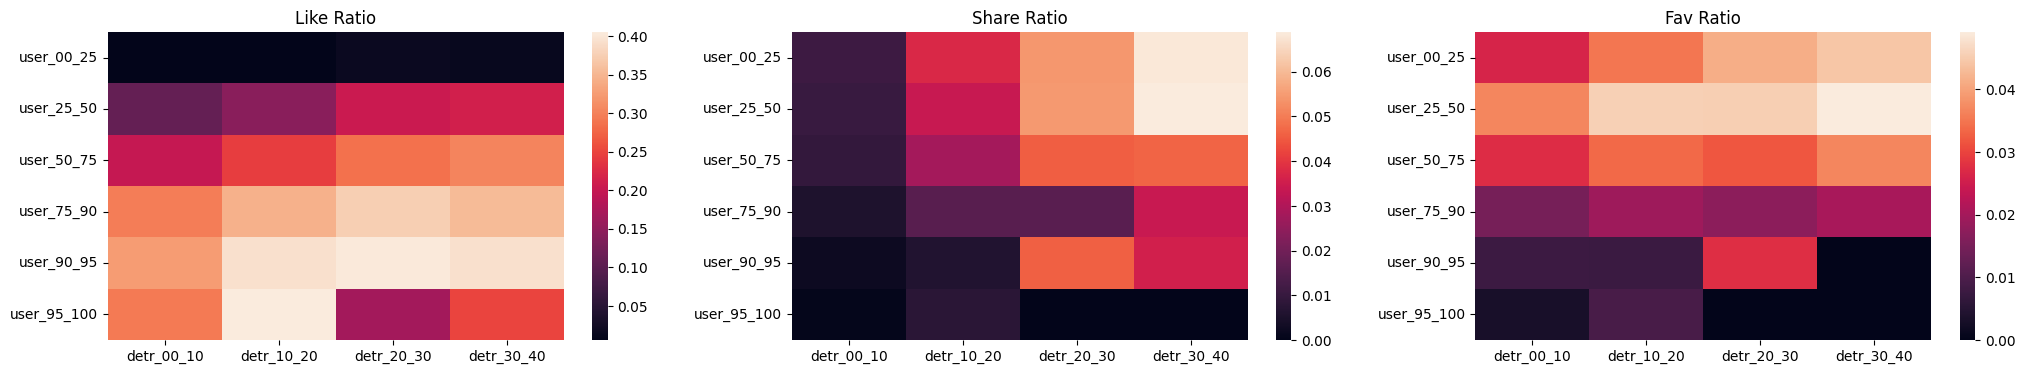

In [42]:
def df_matrix(df):
    
    cohorts = df['user_cohort'].unique()
    detrs = df['DETR_img_groups'].unique()
    
    columns = df.columns[2:].values
    
    like_matrix = []
    share_matrix = []
    fav_matrix = []
    
    for c in cohorts:
        like_matrix.append(df[df['user_cohort'] == c]['like_ratio'].values)
        share_matrix.append(df[df['user_cohort'] == c]['share_ratio'].values)
        fav_matrix.append(df[df['user_cohort'] == c]['fav_ratio'].values)
    
    like_df = pd.DataFrame(like_matrix, index = cohorts, columns = detrs)
    share_df = pd.DataFrame(share_matrix, index = cohorts, columns = detrs)
    fav_df = pd.DataFrame(fav_matrix, index = cohorts, columns = detrs)
    
    fig,axs = plt.subplots(1,3, figsize = (25,4))
    sns.heatmap(like_df, ax = axs[0])
    sns.heatmap(share_df, ax = axs[1])
    sns.heatmap(fav_df, ax = axs[2])
    
    axs[0].set_title("Like Ratio")
    axs[1].set_title("Share Ratio")
    axs[2].set_title("Fav Ratio")

    
    

df_matrix(cohort_analysis_df) #Total 

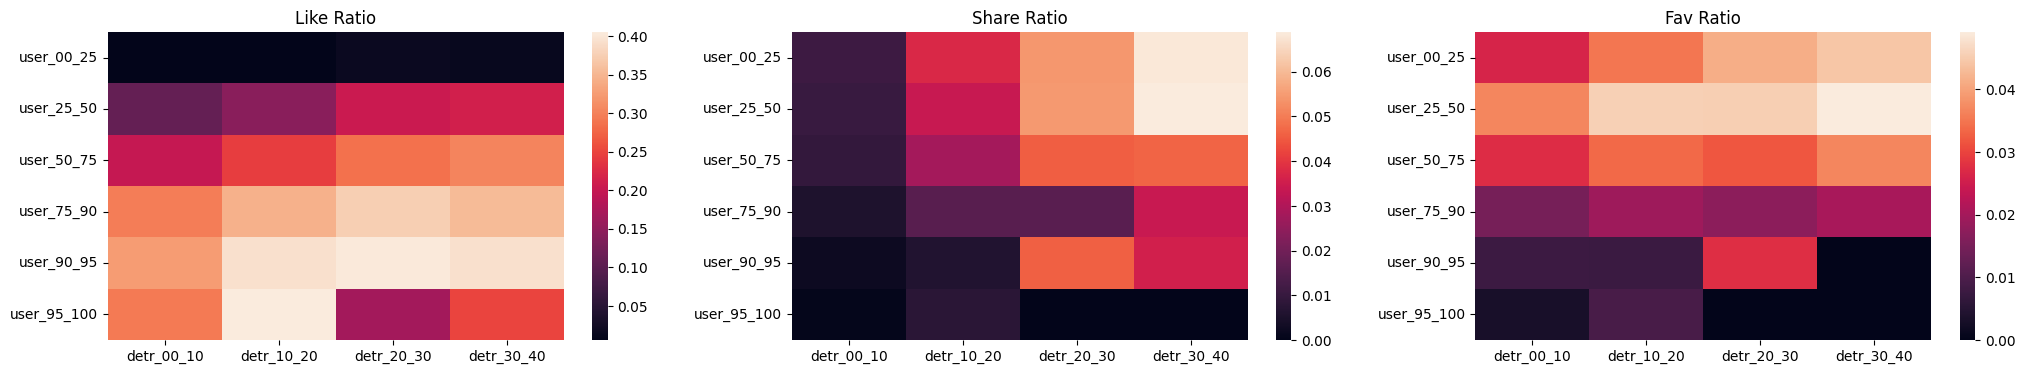

In [43]:
cohort_analysis_early_stage = run_query(query, estimate_cost = False) #less than 500 views
df_matrix(cohort_analysis_early_stage)

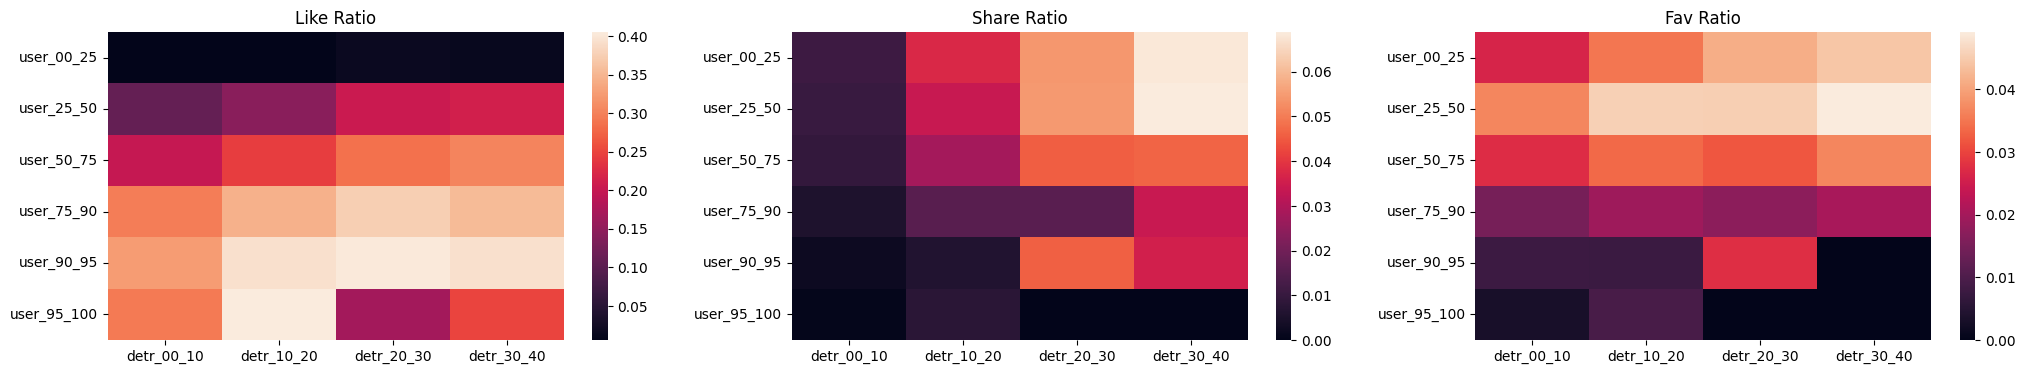

In [44]:
cohort_analysis_mature_stage = run_query(query, estimate_cost = False) #Greater than 5000 views
df_matrix(cohort_analysis_mature_stage)

<AxesSubplot:>

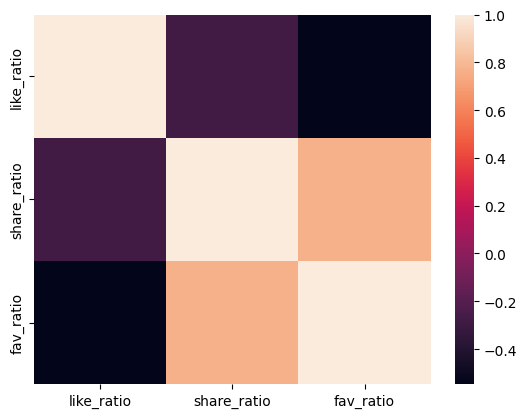

In [45]:
sns.heatmap(cohort_analysis_df.corr())

### Age of popular posts for a day

In [14]:
query = """
    with post_detr as
    (
        with post_creation as 
        (
            select postId, time
            from `maximal-furnace-783.sc_analytics.all_posts2`
            where time > '{0}' and composeType = 'image' and language in ('Hindi','Tamil','Telugu')
        ),
        post_dets as
        (
            select postId, date(time) as day, extract(hour from time) as hour_of_day,
            sum(ifnull(likes,0)) as hour_likes,
            sum(ifnull(shares,0)) as hour_shares,
            sum(ifnull(favs,0)) as hour_favs,
            sum(ifnull(views,0)) as hour_views,
            min(time) as first_time
            from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
            where date(time) = '{1}' and type = 'image' and language in ('Hindi','Tamil','Telugu')
            group by postId, day, hour_of_day
        )
        select A.postId, A.hour_of_day, timestamp_diff(first_time, B.time, hour)/24.0 as post_creation_time, hour_views,
        (hour_favs + hour_shares + least(4*hour_shares,hour_likes) + 2) /(hour_views+100) as DETR_img,
        hour_likes/hour_views as like_ratio,
        hour_shares/hour_views as share_ratio,
        hour_favs/hour_views as fav_ratio,
        (hour_likes + hour_shares + hour_favs)/hour_views as eng_ratio,
        row_number() over (partition by hour_of_day order by cast( hour_likes/hour_views as float64) DESC ) 
            as rownum_like_ratio,
        row_number() over (partition by hour_of_day order by cast( hour_shares/hour_views as float64) DESC ) 
            as rownum_share_ratio,
        row_number() over (partition by hour_of_day order by cast( hour_favs/hour_views as float64) DESC ) 
            as rownum_fav_ratio,
        row_number() over (partition by hour_of_day order by cast( (hour_likes + hour_shares + hour_favs)/hour_views  as float64) DESC ) 
            as rownum_eng_ratio
        from post_dets as A
        inner join post_creation as B
        on A.postId = B.postId and hour_views > 100
    )
    (
        select postId, avg(post_creation_time) as post_creation_time, avg(hour_of_day) as hour_of_day, variance(hour_of_day) as var_hours,
        avg(hour_views) as avg_hour_views, avg(DETR_img) as DETR_img,
        'like_ratio' as ranking_metric, avg(like_ratio) as metric_ratio
        from post_detr
        where rownum_like_ratio<={2}
        group by postId
    )
    union all
    (
        select postId, avg(post_creation_time) as post_creation_time, avg(hour_of_day) as hour_of_day, variance(hour_of_day) as var_hours,
        avg(hour_views) as avg_hour_views, avg(DETR_img) as DETR_img,
        'share_ratio' as ranking_metric, avg(share_ratio) as metric_ratio
        from post_detr
        where rownum_share_ratio<={2}
        group by postId
    )
    union all
    (
        select postId, avg(post_creation_time) as post_creation_time, avg(hour_of_day) as hour_of_day, variance(hour_of_day) as var_hours,
        avg(hour_views) as avg_hour_views, avg(DETR_img) as DETR_img,
        'fav_ratio' as ranking_metric, avg(fav_ratio) as metric_ratio
        from post_detr
        where rownum_fav_ratio<={2}
        group by postId
    )
    union all
    (
        select postId, avg(post_creation_time) as post_creation_time, avg(hour_of_day) as hour_of_day, variance(hour_of_day) as var_hours,
        avg(hour_views) as avg_hour_views, avg(DETR_img) as DETR_img,
        'eng_ratio' as ranking_metric, avg(eng_ratio) as metric_ratio
        from post_detr
        where rownum_eng_ratio<={2}
        group by postId
    )
"""

run_query(query.format('2022-12-15','2022-12-22',500), estimate_cost=True)

Total bytes processed 26.921996393 GB


""


In [57]:
post_creation_df = run_query(query.format('2022-12-15','2022-12-22',500), estimate_cost=False)
post_creation_df.head()

,postId,post_creation_time,hour_of_day,var_hours,avg_hour_views,DETR_img,ranking_metric,metric_ratio
0,5915054225,2.725000,20.400000,4.300000,789.800000,0.120758,eng_ratio,0.137037
1,3208060325,0.342593,16.222222,13.444444,551.555556,0.116224,eng_ratio,0.137002
2,3299779125,4.430556,16.333333,30.333333,237.000000,0.086402,eng_ratio,0.121144
3,9238663125,6.468750,7.250000,72.916667,926.250000,0.128326,eng_ratio,0.149846
4,9365504225,2.843750,16.250000,56.916667,435.000000,0.088649,eng_ratio,0.116028


In [58]:
post_creation_df.describe()

,post_creation_time,hour_of_day,var_hours,avg_hour_views,DETR_img,metric_ratio
count,19709.000000,19709.000000,8377.000000,19709.000000,19709.000000,19709.000000
mean,2.891181,12.138645,25.857031,448.400780,0.076582,0.080048
std,2.413032,6.499593,38.394660,3479.421259,0.027768,0.041193
min,0.000000,0.000000,0.000000,101.000000,0.005698,0.019360
25%,0.541667,7.000000,2.000000,125.000000,0.058296,0.048303
50%,2.375000,12.000000,9.333333,168.000000,0.075829,0.069307
75%,5.031250,17.800000,33.944444,280.500000,0.093023,0.109272
max,7.916667,23.000000,264.500000,200016.000000,0.260174,0.526786


In [15]:
post_creation_df = run_query(query.format('2022-12-15','2022-12-22',500), estimate_cost=False)
post_creation_df['Group'] = 1
post_creation_df_2 = run_query(query.format('2022-12-21','2022-12-28',500), estimate_cost=False)
post_creation_df_2['Group'] = 2
post_creation_df_3 = run_query(query.format('2023-01-02','2023-01-09',500), estimate_cost=False)
post_creation_df_3['Group'] = 3

time_df = pd.concat([post_creation_df, post_creation_df_2, post_creation_df_3])

In [16]:
time_df.reset_index(drop=True, inplace=True)

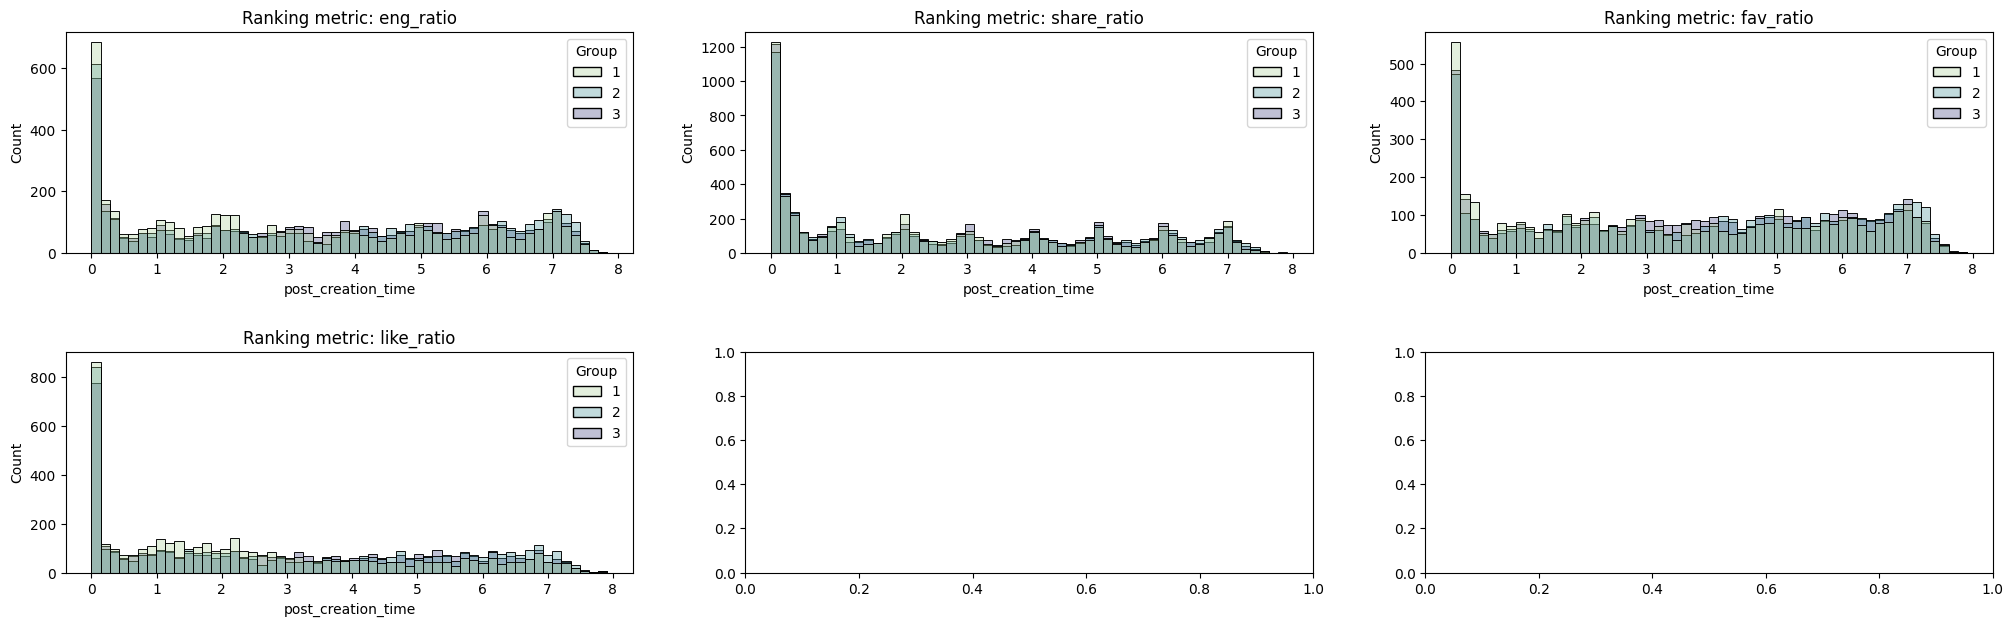

In [18]:
metrics = time_df.ranking_metric.unique()

cols = 3
rows = int(np.ceil(len(metrics)/3))
fig,axs = plt.subplots(rows,cols, figsize = (20,6))
fig.tight_layout(h_pad=5, w_pad=5)

for i in range(len(metrics)):
    x = i//cols
    y = i%cols
    sns.histplot(data = time_df[time_df.ranking_metric == metrics[i]], x = 'post_creation_time', hue = 'Group', 
                                common_norm = False, bins = 7*8 , palette="crest", alpha = 0.3, ax = axs[x][y])
    axs[x][y].set_title(f"Ranking metric: {metrics[i]}")

In [19]:
time_df.describe()

,post_creation_time,hour_of_day,var_hours,avg_hour_views,DETR_img,metric_ratio,Group
count,59217.000000,59217.000000,25227.000000,59217.000000,59217.000000,59217.000000,59217.000000
mean,3.107814,12.106112,27.244853,447.647555,0.074769,0.078865,2.001115
std,2.455093,6.445258,39.739273,3509.395321,0.026758,0.040471,0.816585
min,0.000000,0.000000,0.000000,101.000000,0.004878,0.019360,1.000000
25%,0.666667,7.142857,2.000000,126.000000,0.057269,0.046980,1.000000
50%,2.854167,12.000000,10.000000,169.000000,0.073910,0.069444,2.000000
75%,5.333333,17.500000,36.770707,281.000000,0.090674,0.105960,3.000000
max,7.916667,23.000000,264.500000,260518.600000,0.260174,0.526786,3.000000


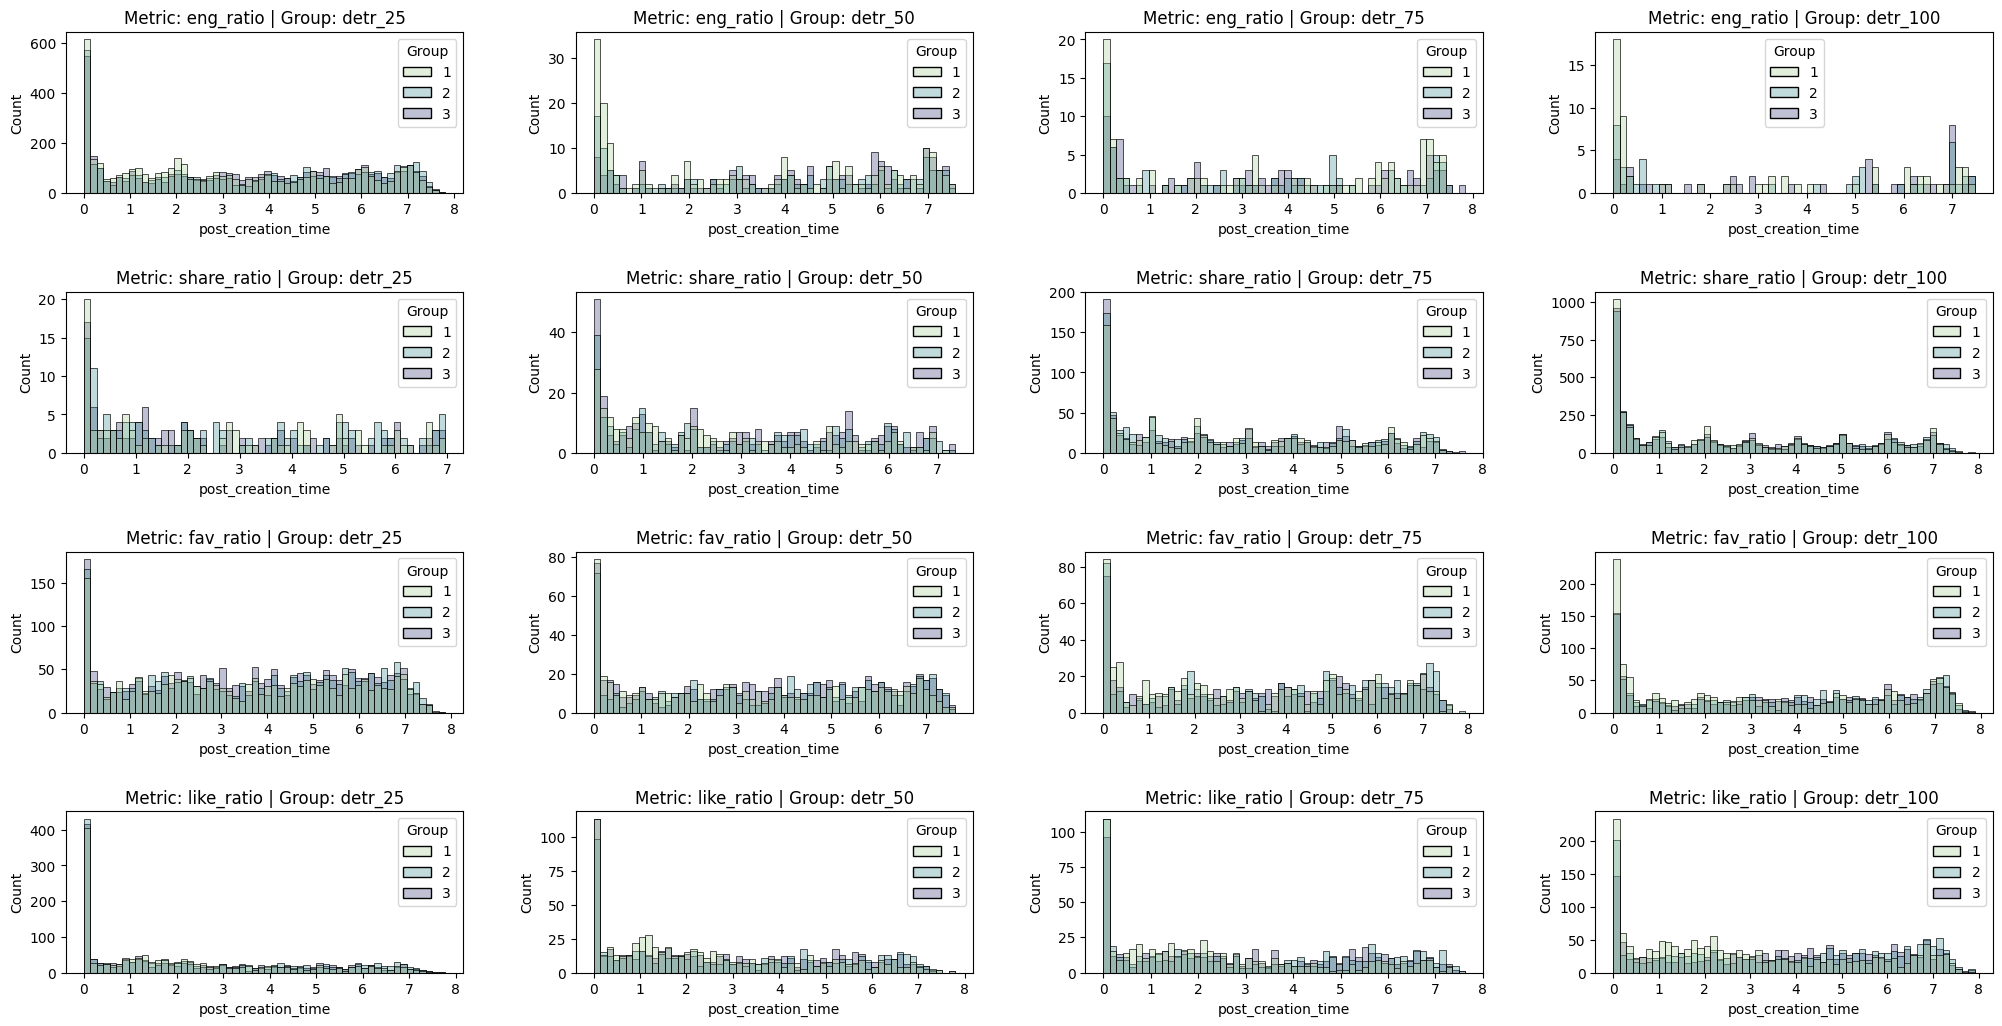

In [32]:
fig, axs = plt.subplots(len(metrics),4, figsize=(20,10))
fig.tight_layout(h_pad=5, w_pad=5)

for i in range(len(metrics)):
    
    df = time_df[time_df.ranking_metric == metrics[i]].copy()
    
    def mark_post_detr_q(row):
        if row.DETR_img <= q1:
            return 'detr_25'
        elif row.DETR_img <=q2:
            return 'detr_50'
        elif row.DETR_img <= q3:
            return 'detr_75'
        else:
            return 'detr_100'
        
    q1,q2,q3 = df.describe()['metric_ratio'][['25%','50%','75%']].values
    df['detr_grp'] = df.apply(mark_post_detr_q, axis = 1) 
    
    detr_grps = ['detr_25','detr_50','detr_75','detr_100']
    
    for j in range(4):
        
        sns.histplot(data = df[df['detr_grp'] == detr_grps[j]], x = 'post_creation_time', hue = 'Group', common_norm = False, ax=axs[i][j], bins = 7*8, 
                        palette="crest", alpha = 0.3)
        axs[i][j].set_title(f"Metric: {metrics[i]} | Group: {detr_grps[j]}")

<AxesSubplot:xlabel='var_hours', ylabel='Density'>

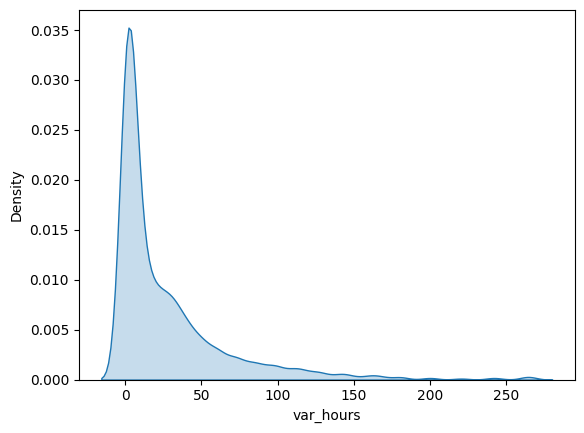

In [65]:
sns.kdeplot(data = time_df, x = 'var_hours', fill = True)

In [67]:
%%bigquery top_k_detr_hourly --use_rest_api
with post_detr as
(
    with post_creation as 
    (
        select postId, time
        from `maximal-furnace-783.sc_analytics.all_posts2`
        where time between '2022-12-15' and '2022-12-23' and composeType = 'image' and language in ('Hindi','Tamil','Telugu')
    ),
    post_hour_counts as
    (
        with post_dets as
        (
            with hour_counts as
            (
                select postId, date(time) as day, extract(hour from time) as hour_of_day,
                sum(ifnull(likes,0)) as hour_likes,
                sum(ifnull(shares,0)) as hour_shares,
                sum(ifnull(favs,0)) as hour_favs,
                sum(ifnull(views,0)) as hour_views,
                min(time) as first_time
                from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                where date(time) between '2022-12-21' and '2022-12-22' and type = 'image' and language in ('Hindi','Tamil','Telugu')
                group by postId, day, hour_of_day
            ),
            hours_day as
            (    

                with dates as
                (
                    select day from unnest(generate_date_array('2022-12-21','2022-12-22')) as day
                ),
                hours as 
                (
                    SELECT hour FROM UNNEST(GENERATE_ARRAY(0, 23)) AS hour
                ),
                posts as 
                (
                    select distinct postId
                    from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                    where date(time) between '2022-12-21' and '2022-12-22' and type = 'image' and language in ('Hindi','Tamil','Telugu')
                )
                select postId, dates.day, hours.hour 
                from dates cross join hours
                cross join posts
            )

            select A.postId, A.day, A.hour as hour_of_day, first_time,
            ifnull(hour_views,0) as hour_views, ifnull(hour_likes,0) as hour_likes, ifnull(hour_shares,0) as hour_shares, ifnull(hour_favs,0) as hour_favs
            from hours_day as A
            left join hour_counts as B on A.postId = B.postId and A.hour = B.hour_of_day and A.day = B.day
        )
        select postId, day, hour_of_day, first_time,
        hour_likes/(hour_views+1) as like_ratio, hour_shares/(hour_views+1) as share_ratio, hour_favs/(hour_views+1) as fav_ratio,
        (hour_shares + hour_likes + hour_favs)/(hour_views+1) as eng_ratio,
        sum(hour_likes) over (partition by postId order by day,hour_of_day rows between 24 preceding and 1 preceding) as hr24_likes,
        sum(hour_shares) over (partition by postId order by day,hour_of_day rows between 24 preceding and 1 preceding) as hr24_shares,
        sum(hour_favs) over (partition by postId order by day,hour_of_day rows between 24 preceding and 1 preceding) as hr24_favs,
        sum(hour_views) over (partition by postId order by day,hour_of_day rows between 24 preceding and 1 preceding) as hr24_views
        from post_dets
    )
        select A.postId, hour_of_day, timestamp_diff(first_time, B.time, hour)/24.0 as post_creation_time, hr24_views, like_ratio, share_ratio, fav_ratio, eng_ratio,
        (hr24_favs + hr24_shares + least(4*hr24_shares,hr24_likes) + 2) /(hr24_views+100) as DETR_img,
        row_number() over (partition by hour_of_day order by cast( (hr24_favs + hr24_shares + least(4*hr24_shares,hr24_likes) + 2) /(hr24_views+100) as float64) DESC ) 
        as rownum
        from post_hour_counts as A
        inner join post_creation as B
        on A.postId = B.postId
        where A.day = '2022-12-22'
)
select postId, avg(post_creation_time) as post_creation_time, avg(hour_of_day) as hour_of_day, variance(hour_of_day) as avg_var,
avg(hr24_views) as hr24_views, avg(DETR_img) as avg_DETR,
avg(like_ratio) as like_ratio, avg(share_ratio) as share_ratio, avg(fav_ratio) as fav_ratio, avg(eng_ratio) as eng_ratio
from post_detr
where rownum<=500
group by postId

Query is running:   0%|          |

Downloading:   0%|          |

In [68]:
top_k_detr_hourly.head()

,postId,post_creation_time,hour_of_day,avg_var,hr24_views,avg_DETR,like_ratio,share_ratio,fav_ratio,eng_ratio
0,1898159225,0.041667,1.0,1.0,131.000000,0.131380,0.017519,0.067817,0.052315,0.137651
1,1890659225,0.291667,8.0,20.0,2277.533333,0.120473,0.009392,0.018905,0.015679,0.043975
2,1827959225,0.041667,2.0,1.0,60220.666667,0.111879,0.005156,0.020793,0.017071,0.043020
3,9177109225,0.500000,4.0,7.5,68302.444444,0.121798,0.020399,0.036513,0.024792,0.081704
4,7932429225,0.520833,6.5,17.5,24366.428571,0.112362,0.026279,0.022763,0.018776,0.067819


<AxesSubplot:xlabel='post_creation_time', ylabel='Count'>

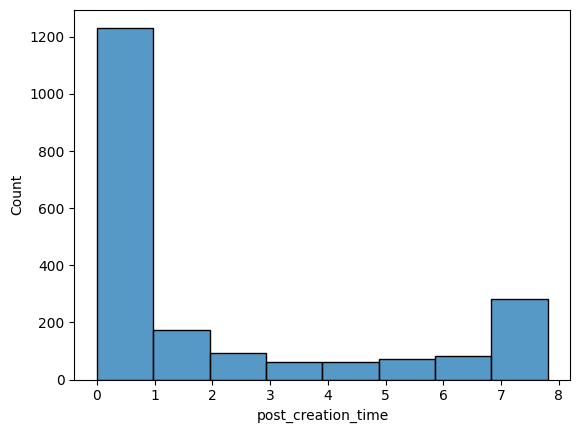

In [69]:
sns.histplot(data = top_k_detr_hourly, x = 'post_creation_time', bins = 8)

<AxesSubplot:xlabel='like_ratio', ylabel='avg_DETR'>

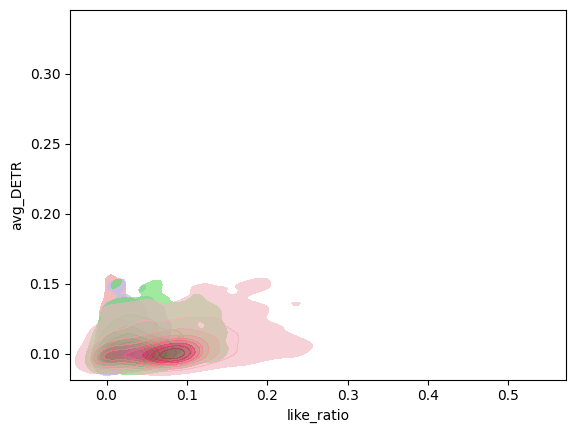

In [87]:
sns.kdeplot(data = top_k_detr_hourly, x = 'like_ratio', y = 'avg_DETR', ax = plt.gca(), color = 'red', alpha = 0.9, fill = True)
sns.kdeplot(data = top_k_detr_hourly, x = 'share_ratio', y = 'avg_DETR', ax = plt.gca(), color = 'blue', alpha = 0.7, fill = True)
sns.kdeplot(data = top_k_detr_hourly, x = 'fav_ratio', y = 'avg_DETR', ax = plt.gca(), color = 'green', alpha = 0.6, fill = True)
sns.kdeplot(data = top_k_detr_hourly, x = 'eng_ratio', y = 'avg_DETR', ax = plt.gca(), color = 'pink', alpha = 0.6, fill = True)

In [81]:
top_k_detr_hourly.describe()

,post_creation_time,hour_of_day,avg_var,hr24_views,avg_DETR,like_ratio,share_ratio,fav_ratio,eng_ratio
count,2058.000000,2083.000000,1512.000000,2.083000e+03,2083.000000,2083.000000,2083.000000,2083.000000,2083.000000
mean,2.071314,10.463556,9.781370,1.117067e+04,0.105973,0.017982,0.021577,0.041306,0.080865
std,2.702536,7.322589,12.581918,4.076508e+04,0.013988,0.023129,0.020861,0.035054,0.054102
min,0.000000,0.000000,0.500000,1.100000e+01,0.093168,0.000000,0.000000,0.000000,0.000000
25%,0.146875,4.000000,1.000000,2.324049e+02,0.098048,0.004810,0.006007,0.019717,0.049144
50%,0.509358,10.000000,4.666667,9.659091e+02,0.101682,0.011288,0.017167,0.034956,0.079334
75%,3.519886,17.000000,13.719444,6.959292e+03,0.108546,0.024260,0.032164,0.053216,0.098720
max,7.812500,23.000000,180.500000,1.085795e+06,0.333743,0.255235,0.185531,0.323529,0.526168


In [18]:
len(top_k_detr_hourly)

1742

<AxesSubplot:xlabel='hour_of_day', ylabel='Density'>

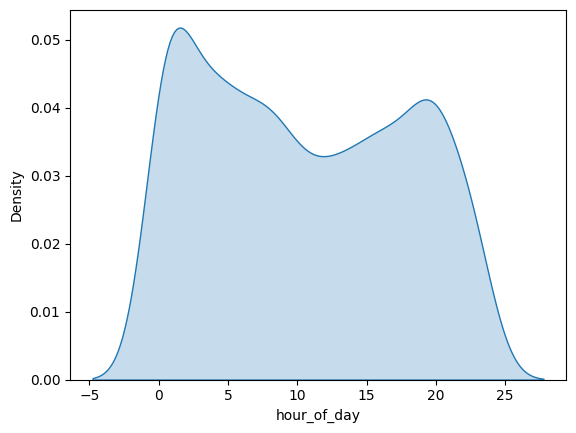

In [92]:
sns.kdeplot(data = top_k_detr_hourly, x = 'hour_of_day', fill = True)

### Lifecycle of a post

In [12]:
query = """
    with post_series as
    (
        with post_detr as
        (
            with post_creation as
            (
                select postId, time
                from `maximal-furnace-783.sc_analytics.all_posts2`
                where time between '{0}' and '{1}' and composeType = 'image'
            )

            select A.postId,
            (sum(ifnull(favs,0)) + sum(ifnull(shares,0)) + least(4*sum(ifnull(shares,0)) ,sum(ifnull(likes,0)) ) + 2) /(sum(ifnull(views,0))+100) as DETR_img,
            sum(ifnull(views,0)) as total_views
            from `maximal-furnace-783.ds_analytics.post_15_min_features_v2` as A
            inner join post_creation as B
            on A.postId = B.postId
            where Date(B.time) = '{0}' and Date(A.time) between '{0}' and '{1}'
            group by A.postId
            having total_views > 2000
            order by DETR_img DESC
            LIMIT 2
            offset 20
        ),
        dates as
        (
            select day from unnest(generate_date_array('{0}','{1}')) as day
        ),
        hours as 
        (
            SELECT hour FROM UNNEST(GENERATE_ARRAY(0, 23)) AS hour
        )
        select postId, DETR_img, total_views, day, hour
        from dates as A
        cross join hours as B
        cross join post_detr as C 
    )
    select A.postId, floor((date_diff(day,cast('{0}' as date),day)*24+hour)/3) as time_span,
    (sum(ifnull(likes,0)) + sum(ifnull(shares,0))+ sum(ifnull(favs,0)))/(sum(ifnull(views,0))+100) as eng_ratio,
    -- sum(ifnull(shares,0))/(sum(ifnull(views,0))+100) as share_ratio, 
    -- sum(ifnull(favs,0))/(sum(ifnull(views,0))+100) as fav_ratio
    from `maximal-furnace-783.ds_analytics.post_15_min_features_v2` as A
    right join post_series as B
    on A.postId = B.postId and date(time) = B.day and extract(hour from time) = B.hour 
    where date(A.time) between '{0}' and '{1}'
    group by A.postId, time_span
    order by A.postId, time_span
"""

post_lifeCycle = run_query(query.format('2022-12-15','2022-12-22'), estimate_cost = True)

Total bytes processed 144.171639073 GB


In [13]:
post_lifeCycle = run_query(query.format('2022-12-15','2022-12-22'), estimate_cost = False)

<AxesSubplot:xlabel='time_span', ylabel='eng_ratio'>

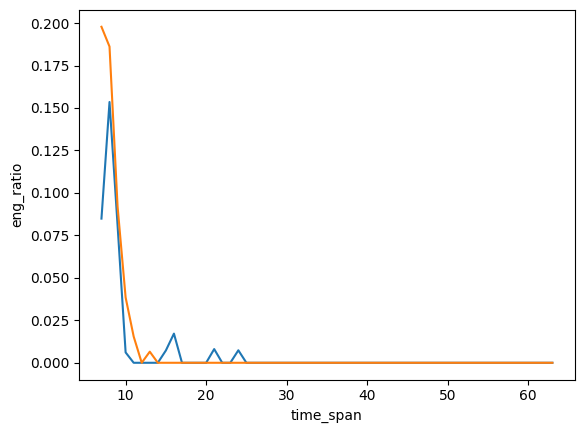

In [14]:
sns.lineplot(data = post_lifeCycle, y = 'eng_ratio', x = 'time_span', hue = 'postId', legend = None)

In [48]:
post_lifeCycle.head()

,postId,time_span,eng_ratio
0,5580782125,4.0,0.00000
1,5580782125,5.0,0.00000
2,5580782125,6.0,0.00000
3,5580782125,7.0,0.00000
4,5580782125,8.0,0.00885


<AxesSubplot:xlabel='time_span', ylabel='eng_ratio'>

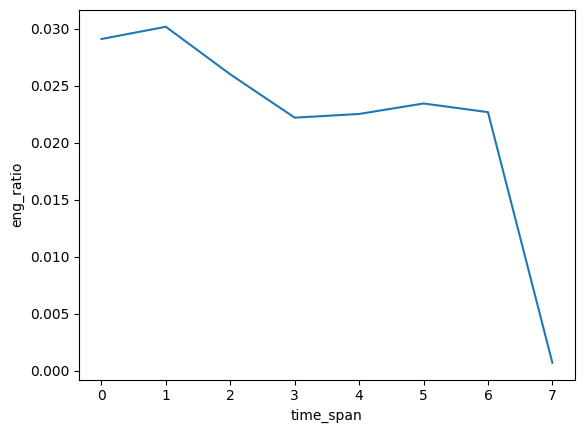

In [42]:
post_temp = post_lifeCycle.drop(columns=['postId']).groupby(['time_span']).mean().sort_values(by=['time_span'])
sns.lineplot(data = post_temp, y = 'eng_ratio', x = 'time_span', legend = None)

In [34]:
from statsmodels.graphics.tsaplots import plot_pacf

In [35]:
post_temp = post_lifeCycle.drop(columns=['postId'])

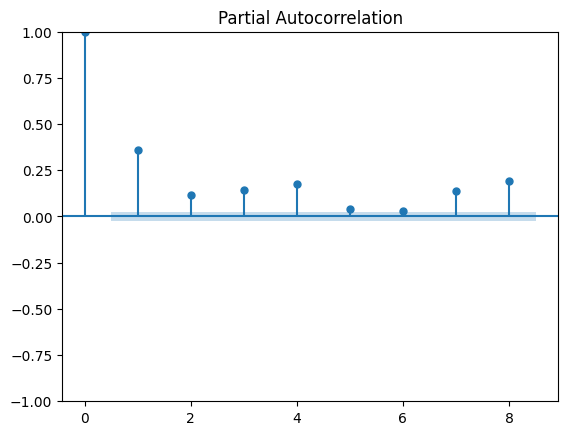

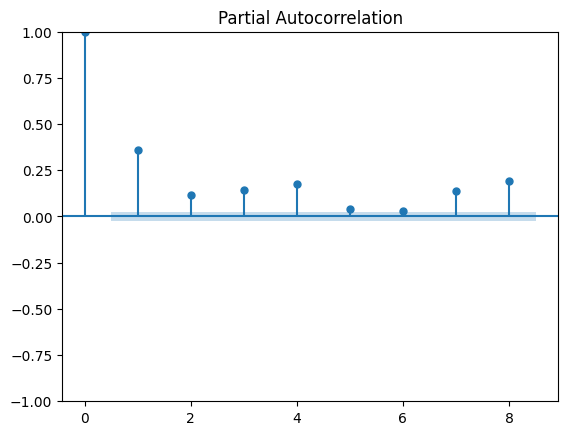

In [36]:
plot_pacf(post_temp.eng_ratio, lags = 8, method = 'ywm')

# Defining new definitions

### Regression

In [3]:
regress_query = """
with post_features as
(
    with posts as
    (
        with post_detr as
        (
            with post_creation as
            (
                select postId, time
                from `maximal-furnace-783.sc_analytics.all_posts2`
                where time between '{0}' and '{1}' and composeType = 'image' and language = 'hindi'
            )
            select A.postId,
            (sum(ifnull(favs,0) + ifnull(shares,0) + least(4*ifnull(shares,0) ,ifnull(likes,0) ))+2) /(sum(ifnull(views,0))+100) as DETR_img,
            sum(ifnull(views,0)) as total_views
            from `maximal-furnace-783.ds_analytics.post_15_min_features_v2` as A
            inner join post_creation as B
            on A.postId = B.postId
            where Date(B.time) = '{0}' and Date(A.time) between '{0}' and '{1}'
            group by A.postId
            having total_views > 2000
            order by DETR_img DESC
            LIMIT 1000
        ),
        TimeSpan as 
        (
            SELECT time_span FROM UNNEST(GENERATE_ARRAY(0, ceil((timestamp_diff('{1}','{0}',hour)+24)/3))) AS time_span
        ),
        post_counts as 
        (
            select postId, 
            floor(timestamp_diff(time,'{0}',hour)/3) as time_span,
            sum(ifnull(favs,0) + ifnull(shares,0) + least(4*ifnull(shares,0) ,ifnull(likes,0))) as Total_Eng,
            sum(ifnull(views,0)) as Total_view
            from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
            where time between '{0}' and '{1}' and type = 'image'
            group by postId, time_span
        )
        select A.postId, B.time_span,
        ifnull(Total_Eng,0) as Total_Eng,
        ifnull(Total_view,0) as Total_view
        from post_detr as A
        cross join Timespan as B
        left join post_counts as C
        on A.postId = C.postId and C.time_span = B.time_span
    )
    select postId, time_span, Total_Eng as lag0_eng, Total_view as lag0_view,
    sum(Total_Eng) over ( partition by postId order by time_span rows between 7 preceding and current row) as hr24_eng,
    sum(Total_view) over ( partition by postId order by time_span rows between 7 preceding and current row) as hr24_view,
    lag(Total_Eng,1) over ( partition by postId order by time_span) as lag1_eng,
    lag(Total_view,1) over ( partition by postId order by time_span) as lag1_view,
    lag(Total_Eng,3) over ( partition by postId order by time_span) as lag3_eng,
    lag(Total_view,3) over ( partition by postId order by time_span) as lag3_view,
    lag(Total_Eng,7) over ( partition by postId order by time_span) as lag7_eng,
    lag(Total_view,7) over ( partition by postId order by time_span) as lag7_view,
    lag(Total_Eng,8) over ( partition by postId order by time_span) as lag8_eng,
    lag(Total_view,8) over ( partition by postId order by time_span) as lag8_view,
    lead(Total_Eng,1) over ( partition by postId order by time_span) as lead1_eng,
    lead(Total_view,1) over ( partition by postId order by time_span) as lead1_view
    from posts
)
select postId, time_span, (hr24_eng+2)/(hr24_view+100) as hr24_eng_ratio,
(lag0_eng+2)/(lag0_view+100) as lag0_eng_ratio,
(lag1_eng+2)/(lag1_view+100) as lag1_eng_ratio,
(lag3_eng+2)/(lag3_view+100) as lag3_eng_ratio,
(lag7_eng+2)/(lag7_view+100) as lag7_eng_ratio,
(lag8_eng+2)/(lag8_view+100) as lag8_eng_ratio,
(lead1_eng+2)/(lead1_view+100) as lead_eng_ratio
from post_features
"""

run_query(regress_query.format('2022-12-15','2022-12-22'))

Total bytes processed 163.557236977 GB


""


In [7]:
regress_df = run_query(regress_query.format('2022-12-15','2022-12-22'), estimate_cost = False)

In [8]:
regress_df['lead_eng_ratio'].fillna(method = 'ffill', inplace = True)
regress_df.fillna(0, inplace = True)
print(regress_df[40:50])
regress_df.describe()

Empty DataFrame
Columns: [postId, time_span, hr24_eng_ratio, lag0_eng_ratio, lag1_eng_ratio, lag3_eng_ratio, lag7_eng_ratio, lag8_eng_ratio, lead_eng_ratio]
Index: []


,postId,time_span,hr24_eng_ratio,lag0_eng_ratio,lag1_eng_ratio,lag3_eng_ratio,lag7_eng_ratio,lag8_eng_ratio,lead_eng_ratio
count,0,0,0,0,0,0,0,0,0
unique,0,0,0,0,0,0,0,0,0
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
import statsmodels.api as sm

In [41]:
def preprocess(regress_df):
    X = regress_df.copy()
    #X['log_lag0'] = np.log(X['lag0_eng_ratio']+1)
    #X['log_lag1'] = np.log(X['lag1_eng_ratio']+1)
    #X['log_lag3'] = np.log(X['lag3_eng_ratio']+1)
    #X['log_lag7'] = np.log(X['lag7_eng_ratio']+1)
    #X['log_lag8'] = np.log(X['lag8_eng_ratio']+1)
    
    #X['trend_1'] = np.log(X['lag1_eng_ratio']/(X['lag0_eng_ratio'] +2)+1)
    #X['trend_3'] = np.log(X['lag3_eng_ratio']/(X['lag0_eng_ratio'] +2)+1)
    #X['trend_7'] = np.log(X['lag7_eng_ratio']/(X['lag0_eng_ratio'] +2)+1)
    #X['trend_8'] = np.log(X['lag8_eng_ratio']/(X['lag0_eng_ratio'] +2)+1)
    
    X = X.drop(columns = ['postId','time_span','lead_eng_ratio','lag3_eng_ratio','lag1_eng_ratio'])
    #'lag7_eng_ratio','lag8_eng_ratio','lag0_eng_ratio'
    Y = regress_df['lead_eng_ratio']
    return X,Y

In [42]:
X,Y = preprocess(regress_df)

In [43]:
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

In [44]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         lead_eng_ratio   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     8664.
Date:                Wed, 15 Feb 2023   Prob (F-statistic):               0.00
Time:                        05:19:13   Log-Likelihood:             1.4667e+05
No. Observations:               65000   AIC:                        -2.933e+05
Df Residuals:                   64996   BIC:                        -2.933e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0133      0.000     73.431      0.000       0.013       0.014
hr24_eng_ratio     0.3447      0.003    105.309      0.000       0.338       0.351
lag7_eng_ratio     0.1885      0.005     37.361      0.000       0.179       0.198
lag8_eng_ratio    -0.0159      0.005     -3.420      0.001      -0.025      -0.007
==============================================================================
Omnibus:                    21608.921   Durbin-Watson:                   0.804
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           171708.331
Skew:                           1.382   Prob(JB):                         0.00
Kurtosis:                      10.467   Cond. No.                         64.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
posts = regress_df['postId'].unique()
df_test = regress_df[regress_df['postId'] == posts[0]]
x_test,y_test = preprocess(df_test)

df_test2 = regress_df[regress_df['postId'] == posts[3]]
x_test2,y_test2 = preprocess(df_test2)

y_pred = results.predict(sm.add_constant(x_test)).rename('y_pred')
y_pred2 = results.predict(sm.add_constant(x_test2)).rename('y_pred')

<AxesSubplot:xlabel='time_span', ylabel='lead_eng_ratio'>

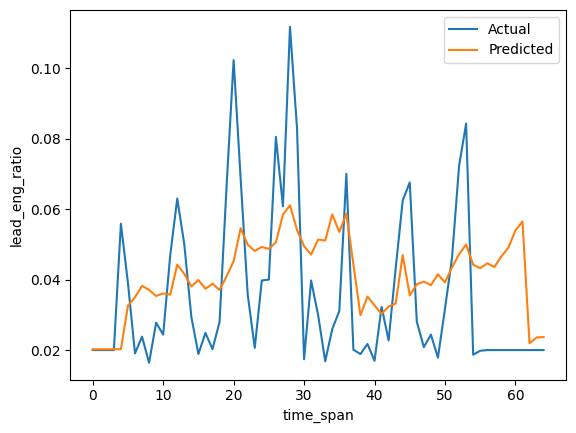

In [46]:
sns.lineplot(x=df_test.time_span, y = y_test, ax = plt.gca(), label = 'Actual')
sns.lineplot(x=df_test.time_span, y = y_pred, ax = plt.gca(), label = 'Predicted')
#sns.lineplot(x=df_test.time_span+1, y = y_test, ax = plt.gca(), label = 'delayed')
#sns.lineplot(x=df_test2.time_span, y = y_test2, ax = plt.gca(), label = 'Actual2')
#sns.lineplot(x=df_test2.time_span, y = y_pred2, ax = plt.gca(), label = 'Predicted2')

In [57]:
def accuracy(y_test1, y_test2, y_pred1, y_pred2):
    df1 = y_test1.to_frame().join(y_pred1.to_frame())
    df2 = y_test2.to_frame().join(y_pred2.to_frame())
    #df = df1.join(df2, how = 'outer', on = 'time', lsuffix = '_y1', rsuffix = '_y2')
    print(df1.tail())
    #isnull(y_test1) or isnull(ytest2) or isnull(y_pred1) or isnull(y_pred2) or 
    #df['final'] = ((df.lead_eng_ratio_y1 >= df.lead_eng_ratio_y2) & (df.y_pred_y1 >= df.y_pred_y2)) | ((df.lead_eng_ratio_y1 < df.lead_eng_ratio_y2) & (df.y_pred_y1 < df.y_pred_y2))
    #print(df.tail())

accuracy(y_test, y_test2, y_pred, y_pred2)

      lead_eng_ratio    y_pred
time                          
104         0.009756  0.017691
105         0.012987  0.019558
106         0.017544  0.018389
107         0.019231  0.017355
108         0.019231  0.017110


<AxesSubplot:xlabel='time_span', ylabel='y_pred'>

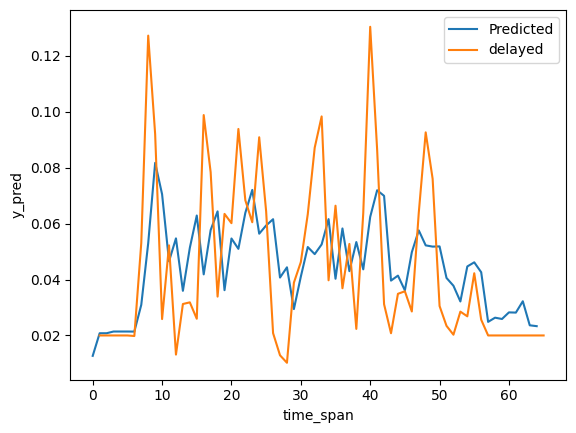

In [116]:
#sns.lineplot(x=df_test.time_span, y = y_test, ax = plt.gca(), label = 'Actual')
sns.lineplot(x=df_test.time_span, y = y_pred, ax = plt.gca(), label = 'Predicted')
sns.lineplot(x=df_test.time_span+1, y = y_test, ax = plt.gca(), label = 'delayed')

### Regression on engagement and views seperately

In [47]:
regress_query2 = """
    with posts as
    (
        with post_detr as
        (
            with post_creation as
            (
                select postId, time
                from `maximal-furnace-783.sc_analytics.all_posts2`
                where time between '{0}' and '{1}' and composeType = 'image'
            )
            select A.postId,
            (sum(ifnull(favs,0) + ifnull(shares,0) + least(4*ifnull(shares,0) ,ifnull(likes,0) ))+2) /(sum(ifnull(views,0))+100) as DETR_img,
            sum(ifnull(views,0)) as total_views
            from `maximal-furnace-783.ds_analytics.post_15_min_features_v2` as A
            inner join post_creation as B
            on A.postId = B.postId
            where Date(B.time) = '{0}' and Date(A.time) between '{0}' and '{1}'
            group by A.postId
            having total_views > 2000
            order by DETR_img DESC
            LIMIT 1000
        ),
        TimeSpan as 
        (
            SELECT time_span FROM UNNEST(GENERATE_ARRAY(0, ceil((timestamp_diff('{1}','{0}',hour)+24)/3))) AS time_span
        ),
        post_counts as 
        (
            select postId, 
            floor(timestamp_diff(time,'{0}',hour)/3) as time_span,
            sum(ifnull(favs,0) + ifnull(shares,0) + least(4*ifnull(shares,0) ,ifnull(likes,0))) as Total_Eng,
            sum(ifnull(views,0)) as Total_view
            from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
            where time between '{0}' and '{1}' and type = 'image'
            group by postId, time_span
        )
        select A.postId, B.time_span,
        ifnull(Total_Eng,0) as Total_Eng,
        ifnull(Total_view,0) as Total_view
        from post_detr as A
        cross join Timespan as B
        left join post_counts as C
        on A.postId = C.postId and C.time_span = B.time_span
    )
    select postId, time_span, Total_Eng as lag0_eng, Total_view as lag0_view,
    sum(Total_Eng) over ( partition by postId order by time_span rows between 7 preceding and current row) as hr24_eng,
    sum(Total_view) over ( partition by postId order by time_span rows between 7 preceding and current row) as hr24_view,
    lag(Total_Eng,1) over ( partition by postId order by time_span) as lag1_eng,
    lag(Total_view,1) over ( partition by postId order by time_span) as lag1_view,
    lag(Total_Eng,3) over ( partition by postId order by time_span) as lag3_eng,
    lag(Total_view,3) over ( partition by postId order by time_span) as lag3_view,
    lag(Total_Eng,7) over ( partition by postId order by time_span) as lag7_eng,
    lag(Total_view,7) over ( partition by postId order by time_span) as lag7_view,
    lag(Total_Eng,8) over ( partition by postId order by time_span) as lag8_eng,
    lag(Total_view,8) over ( partition by postId order by time_span) as lag8_view,
    lead(Total_Eng,1) over ( partition by postId order by time_span) as lead1_eng,
    lead(Total_view,1) over ( partition by postId order by time_span) as lead1_view
    from posts

"""

run_query(regress_query2.format('2022-12-15','2022-12-22'))

Total bytes processed 163.546692412 GB


""


In [48]:
regress_df2 = run_query(regress_query2.format('2022-12-15','2022-12-22'), estimate_cost = False)

In [49]:
regress_df2[['lead1_eng','lead1_view']].fillna(method = 'ffill', inplace = True)
regress_df2.fillna(0, inplace = True)
regress_df2.tail()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


,postId,time_span,lag0_eng,lag0_view,hr24_eng,hr24_view,lag1_eng,lag1_view,lag3_eng,lag3_view,lag7_eng,lag7_view,lag8_eng,lag8_view,lead1_eng,lead1_view
64995,9909653125,60.0,0,0,1,19,0,0,0,0,1,11,0,14,0,0
64996,9909653125,61.0,0,0,0,8,0,0,0,0,0,3,1,11,0,0
64997,9909653125,62.0,0,0,0,5,0,0,0,0,0,4,0,3,0,0
64998,9909653125,63.0,0,0,0,1,0,0,0,0,0,1,0,4,0,0
64999,9909653125,64.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [65]:
regress_df2.dtypes

postId         object
time_span     float64
lag0_eng        Int64
lag0_view       Int64
hr24_eng        Int64
hr24_view       Int64
lag1_eng        Int64
lag1_view       Int64
lag3_eng        Int64
lag3_view       Int64
lag7_eng        Int64
lag7_view       Int64
lag8_eng        Int64
lag8_view       Int64
lead1_eng       Int64
lead1_view      Int64
dtype: object

In [174]:
df_view = regress_df2[['postId','time_span','lag0_view','lag1_view','lag3_view','lag7_view','lag8_view','hr24_view']]
df_eng = regress_df2[['postId','time_span','lag0_eng','lag1_eng','lag3_eng','lag7_eng','lag8_eng','hr24_eng']]
Y_view = regress_df2['lead1_view'].astype(float)
Y_eng = regress_df2['lead1_eng'].astype(float)

In [175]:
def process_views(X_view):
    X = X_view.copy().astype(float)
    #X['log_lag0'] = np.log(X['lag0_view']+1)
    #X['log_lag1'] = np.log(X['lag1_view']+1)
    #X['log_lag3'] = np.log(X['lag3_view']+1)
    #X['log_lag7'] = np.log(X['lag7_view']+1)
    #X['log_lag8'] = np.log(X['lag8_view']+1)
    
    #X['trend_1'] = np.log(X['lag0_view']/(X['lag1_view'] +2)+1)
    #X['trend_3'] = np.log(X['lag0_view']/(X['lag3_view'] +2)+1)
    #X['trend_7'] = np.log(X['lag0_view']/(X['lag7_view'] +2)+1)
    #X['trend_8'] = np.log(X['lag0_view']/(X['lag8_view'] +2)+1)
    
    X = X.drop(columns = ['postId','time_span','lag3_view','lag1_view'])
    #'lag7_view','lag8_view','lag0_view'
    return X

def process_views_target(Y_view):
    Y = np.log(Y_view+1).copy()
    return Y

In [176]:
def process_eng(X_eng):
    X = X_eng.copy().astype(float)
    #X['log_lag0'] = np.log(X['lag0_eng']+1)
    #X['log_lag1'] = np.log(X['lag1_eng']+1)
    #X['log_lag3'] = np.log(X['lag3_eng']+1)
    #X['log_lag7'] = np.log(X['lag7_eng']+1)
    #X['log_lag8'] = np.log(X['lag8_eng']+1)
    
    #X['trend_1'] = np.log(X['lag0_eng']/(X['lag1_eng'] +2)+1)
    #X['trend_3'] = np.log(X['lag0_eng']/(X['lag3_eng'] +2)+1)
    #X['trend_7'] = np.log(X['lag0_eng']/(X['lag7_eng'] +2)+1)
    #X['trend_8'] = np.log(X['lag0_eng']/(X['lag8_eng'] +2)+1)
    
    X = X.drop(columns = ['postId','time_span','lag3_eng','lag1_eng'])
    #'lag7_eng','lag8_eng',,'lag0_eng'
    return X

def process_eng_target(Y_eng):
    Y = np.log(Y_eng+1).copy()
    return Y

In [177]:
X_view = process_views(df_view)
X_eng = process_eng(df_eng)
Y_view_proc = process_views_target(Y_view)
Y_eng_proc = process_eng_target(Y_eng)

In [178]:
X_view = sm.add_constant(X_view)
view_model = sm.OLS(Y_view_proc,X_view)
view_result = view_model.fit()

X_eng = sm.add_constant(X_eng)
eng_model = sm.OLS(Y_eng_proc,X_eng)
eng_result = eng_model.fit()

In [179]:
view_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             lead1_view   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     3917.
Date:                Wed, 15 Feb 2023   Prob (F-statistic):               0.00
Time:                        06:22:13   Log-Likelihood:            -1.5111e+05
No. Observations:               65000   AIC:                         3.022e+05
Df Residuals:                   64995   BIC:                         3.023e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0501      0.010    298.454      0.000       3.030       3.070
lag0_view   7.699e-05   2.61e-06     29.514      0.000    7.19e-05    8.21e-05
lag7_view    2.09e-05   2.76e-06      7.580      0.000    1.55e-05    2.63e-05
lag8_view   3.269e-05   2.51e-06     13.042      0.000    2.78e-05    3.76e-05
hr24_view   4.492e-05   6.55e-07     68.538      0.000    4.36e-05    4.62e-05
==============================================================================
Omnibus:                       39.911   Durbin-Watson:                   0.304
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.126
Skew:                          -0.057   Prob(JB):                     1.94e-09
Kurtosis:                       3.045   Cond. No.                     2.25e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [180]:
eng_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              lead1_eng   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     3561.
Date:                Wed, 15 Feb 2023   Prob (F-statistic):               0.00
Time:                        06:22:14   Log-Likelihood:            -1.3024e+05
No. Observations:               65000   AIC:                         2.605e+05
Df Residuals:                   64995   BIC:                         2.605e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2679      0.007    173.415      0.000       1.254       1.282
lag0_eng       0.0006   1.59e-05     37.406      0.000       0.001       0.001
lag7_eng       0.0002   1.66e-05      9.554      0.000       0.000       0.000
lag8_eng       0.0003   1.51e-05     18.545      0.000       0.000       0.000
hr24_eng       0.0003   4.38e-06     65.646      0.000       0.000       0.000
==============================================================================
Omnibus:                    11904.932   Durbin-Watson:                   0.396
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           220172.819
Skew:                           0.356   Prob(JB):                         0.00
Kurtosis:                      11.988   Cond. No.                     2.21e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.21e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [188]:
posts = regress_df2['postId'].unique()
post1 = posts[1]
post2 = posts[5]

(65, 4)


<AxesSubplot:xlabel='time_span', ylabel='lead1_view'>

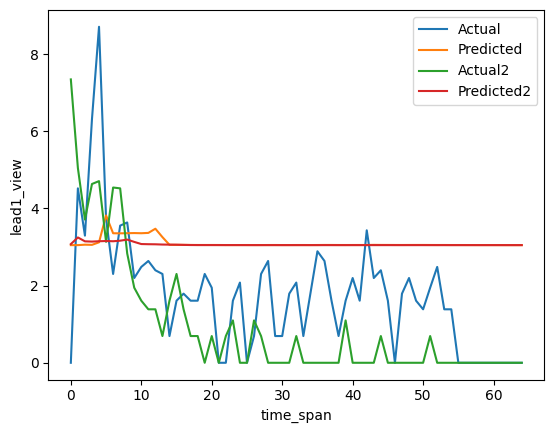

In [189]:
df_test = df_view[df_view['postId'] == post1]
y_test = process_views_target(regress_df2[regress_df2.postId == post1]['lead1_view'])
x_test= process_views(df_test)

print(x_test.shape)

df_test2 = df_view[df_view['postId'] == post2]
y_test2 = process_views_target(regress_df2[regress_df2.postId == post2]['lead1_view'])
x_test2= process_views(df_test2)

y_pred = view_result.predict(sm.add_constant(x_test)).rename('y_pred')
y_pred2 = view_result.predict(sm.add_constant(x_test2)).rename('y_pred')

sns.lineplot(x=df_test.time_span, y = y_test, ax = plt.gca(), label = 'Actual')
sns.lineplot(x=df_test.time_span, y = y_pred, ax = plt.gca(), label = 'Predicted')
#sns.lineplot(x=df_test.time_span+1, y = y_test, ax = plt.gca(), label = 'delayed')
sns.lineplot(x=df_test2.time_span, y = y_test2, ax = plt.gca(), label = 'Actual2')
sns.lineplot(x=df_test2.time_span, y = y_pred2, ax = plt.gca(), label = 'Predicted2')

<AxesSubplot:xlabel='time_span', ylabel='lead1_eng'>

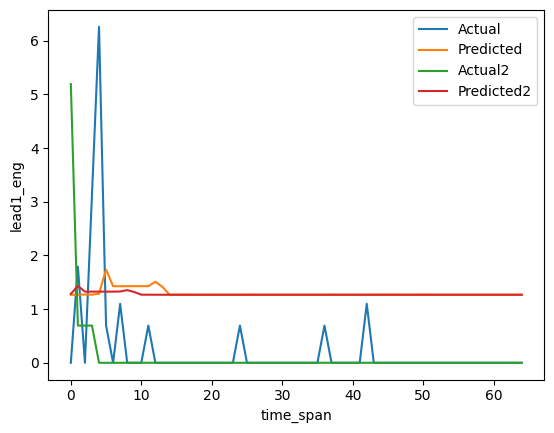

In [190]:
df_test = df_eng[df_eng['postId'] == post1]
y_test = process_eng_target(regress_df2[regress_df2.postId == post1]['lead1_eng'])
x_test= process_eng(df_test)

df_test2 = df_eng[df_eng['postId'] == post2]
y_test2 = process_eng_target(regress_df2[regress_df2.postId == post2]['lead1_eng'])
x_test2= process_eng(df_test2)

y_pred = eng_result.predict(sm.add_constant(x_test)).rename('y_pred')
y_pred2 = eng_result.predict(sm.add_constant(x_test2)).rename('y_pred')

sns.lineplot(x=df_test.time_span, y = y_test, ax = plt.gca(), label = 'Actual')
sns.lineplot(x=df_test.time_span, y = y_pred, ax = plt.gca(), label = 'Predicted')
#sns.lineplot(x=df_test.time_span+1, y = y_test, ax = plt.gca(), label = 'delayed')
sns.lineplot(x=df_test2.time_span, y = y_test2, ax = plt.gca(), label = 'Actual2')
sns.lineplot(x=df_test2.time_span, y = y_pred2, ax = plt.gca(), label = 'Predicted2')

# Recall@k

## Image

### Upper Bound on Expected Recall

In [34]:
%%bigquery --use_rest_api
with recall as(
    with post_detr as
    (
        with post_creation as 
        (
            select postId, language
            from `maximal-furnace-783.sc_analytics.all_posts2`
            where time between '2022-12-15' and '2022-12-23' and composeType = 'image' and language in ('Hindi','Tamil','Telugu')
        ),
        post_hour_counts as
        (
                with hour_counts as
                (
                    select postId, date(time) as day, extract(hour from time) as hour_of_day,
                    sum(ifnull(favs,0) + ifnull(shares,0) + least(4*ifnull(shares,0) ,ifnull(likes,0))) as hour_eng,
                    sum(ifnull(views,0)) as hour_views,
                    from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                    where date(time) between '2022-12-21' and '2022-12-22' and type = 'image' and language in ('Hindi','Tamil','Telugu')
                    group by postId, day, hour_of_day
                ),
                hours_day as
                (    
                    
                    with dates as
                    (
                        select day from unnest(generate_date_array('2022-12-21','2022-12-22')) as day
                    ),
                    hours as 
                    (
                        SELECT hour FROM UNNEST(GENERATE_ARRAY(0, 23)) AS hour
                    ),
                    posts as 
                    (
                        select distinct postId
                        from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                        where date(time) between '2022-12-21' and '2022-12-22' and type = 'image' and language in ('Hindi','Tamil','Telugu')
                    )
                    select postId, dates.day, hours.hour 
                    from dates cross join hours
                    cross join posts
                )
            
                select A.postId, A.day, A.hour as hour_of_day, ifnull(hour_eng,0) as hour_eng, ifnull(hour_views,0) as hour_views
                from hours_day as A
                left join hour_counts as B on A.postId = B.postId and A.hour = B.hour_of_day and A.day = B.day
            )
            select A.postId, language, hour_of_day,
            row_number() over 
                (partition by language, hour_of_day 
                order by 
                 ((hour_eng)/(hour_views+1)
                 -- + 0.7772*log(((lag1_eng+2)/(lag1_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 -- + 0.0448*log(((lag3_eng+2)/(lag3_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 --  + 0.5305*log(((lag7_eng+2)/(lag7_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 -- - 0.2466*log(((lag8_eng+2)/(lag8_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 )
                 DESC ) as rownum
            from post_hour_counts as A
            inner join post_creation as B
            on A.postId = B.postId
            where A.day = '2022-12-22' 
    ),
    user_engagements as
    (
        select userId, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0)) as pos_eng, post_lang, 
        sum(ifnull(likes,0)) as total_likes, sum(ifnull(shares,0)) as total_shares, sum(ifnull(favs,0)) as total_favs
        from `sharechat-production.sc_golden_dataset.flat_table_v1`
        where date(time) = '2022-12-22' and contentType = 'image' and post_lang in ('Hindi','Tamil','Telugu')
        group by userId, post_lang
    )
    select B.userId,
    B.post_lang as language, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))/least(500,min(B.pos_eng)+1) as recall_k,
    sum(ifnull(likes,0))/(least(min(total_likes), count(1))+1) as like_recall,
    sum(ifnull(shares,0))/(least(min(total_shares), count(1))+1) as share_recall,
    sum(ifnull(favs,0))/(least(min(total_favs), count(1))+1) as fav_recall,
    from `sharechat-production.sc_golden_dataset.flat_table_v1` as A
    inner join user_engagements as B on A.userId = B.userId
    inner join post_detr as C on A.postId = C.postId and C.hour_of_day = extract(hour from A.time) and B.post_lang = C.language
    where date(A.time) = '2022-12-22' and C.rownum<=500
    group by B.userId, B.post_lang
)
select language, avg(recall_k) as recall_k, avg(like_recall) as like_recall, avg(share_recall) as share_recall, avg(fav_recall) as fav_recall
from recall
group by language
order by language

Query is running:   0%|          |

Downloading:   0%|          |

,language,recall_k,like_recall,share_recall,fav_recall
0,Hindi,0.080996,0.039772,0.069811,0.190004
1,Tamil,0.089958,0.025419,0.075462,0.166070
2,Telugu,0.096901,0.020955,0.061398,0.121129


In [4]:
%%bigquery --use_rest_api
with user_views as
(
    select count(1) as views, post_lang
    from `sharechat-production.sc_golden_dataset.flat_table_v1`
    where date(time) = '2022-12-22' and contentType = 'image' and post_lang in ('Hindi','Tamil','Telugu')
    group by postId, post_lang, extract(hour from time)
)
select post_lang, min(views) as min_view, max(views) as maxview, avg(views) as avg_view, stddev(views) as std_dev_views
from user_views
group by post_lang

Query is running:   0%|          |

Downloading:   0%|          |

,post_lang,min_view,maxview,avg_view,std_dev_views
0,Tamil,1,83157,9.931204,154.030926
1,Telugu,1,69122,8.979184,151.464681
2,Hindi,1,337166,11.449152,337.669021


In [54]:
%%bigquery user_count_df --use_rest_api
select count(userId) as user_count, extract(hour from time) as hour, post_lang
from `sharechat-production.sc_golden_dataset.flat_table_v1`
where date(time) = '2022-12-22' and contentType = 'image' and post_lang in ('Hindi','Tamil','Telugu')
group by post_lang, hour

Query is running:   0%|          |

Downloading:   0%|          |

<AxesSubplot:xlabel='hour', ylabel='user_count'>

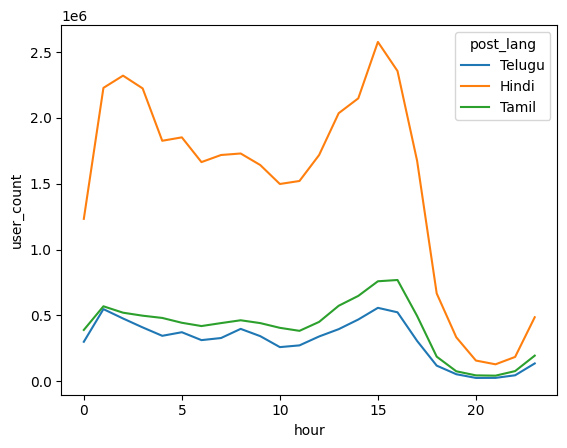

In [30]:
sns.lineplot(data = user_count_df, x = 'hour', y = 'user_count', hue = 'post_lang')

In [3]:
# Important Note: Total users that are being taken into account are only the ones that have seen the posts being recommended. Take into consideration
ideal_recall_query = """
    with recall as(
        with post_detr as
        (
                with post_creation as 
                (
                    select postId, language
                    from `maximal-furnace-783.sc_analytics.all_posts2`
                    where date(time) between '{0}' and '{1}' and composeType = 'image' and language in ('Hindi','Tamil','Telugu')
                ),
                post_hour_counts as
                (
                    with hour_counts as
                    (
                        select postId, date(time) as day, extract(hour from time) as hour_of_day,
                        sum(ifnull(favs,0) + ifnull(shares,0) + least(4*ifnull(shares,0) ,ifnull(likes,0))) as hour_eng,
                        sum(ifnull(views,0)) as hour_views,
                        from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                        where date(time) between '{1}' and '{2}' and type = 'image' and language in ('Hindi','Tamil','Telugu')
                        group by postId, day, hour_of_day
                    ),
                    hours_day as
                    (    

                        with dates as
                        (
                            select day from unnest(generate_date_array('{1}','{2}')) as day
                        ),
                        hours as 
                        (
                            SELECT hour FROM UNNEST(GENERATE_ARRAY(0, 23)) AS hour
                        ),
                        posts as 
                        (
                            select distinct postId
                            from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                            where date(time) between '{1}' and '{2}' and type = 'image' and language in ('Hindi','Tamil','Telugu')
                        )
                        select postId, dates.day, hours.hour 
                        from dates cross join hours
                        cross join posts
                    )

                    select A.postId, A.day, A.hour as hour_of_day, ifnull(hour_eng,0) as hour_eng, ifnull(hour_views,0) as hour_views
                    from hours_day as A
                    left join hour_counts as B on A.postId = B.postId and A.hour = B.hour_of_day and A.day = B.day
                )
                select A.postId, language, A.day, hour_of_day,
                row_number() over 
                    (partition by language, hour_of_day 
                    order by 
                     ((hour_eng +2)/(hour_views+100)
                     )
                     DESC ) as rownum
                from post_hour_counts as A
                inner join post_creation as B
                on A.postId = B.postId
                where A.day between '{1}' and '{2}'
        ),
        user_engagements as
        (
            select userId, date(time) as day, extract(hour from time) as hour, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0)) as pos_eng, post_lang, 
            sum(ifnull(likes,0)) as total_likes, sum(ifnull(shares,0)) as total_shares, sum(ifnull(favs,0)) as total_favs,
            0.2*(sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))) as unified_signal,
            count(1) as Total_views
            from `sharechat-production.sc_golden_dataset.flat_table_v1`
            where date(time)  between '{1}' and '{2}' and contentType = 'image' and post_lang in ('Hindi','Tamil','Telugu')
            group by post_lang, day, hour, userId
        )
        select B.userId, B.day, B.hour,
        B.post_lang as language, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))/least({3},min(ifnull(B.pos_eng,0))+1) as recall_k,
        sum(ifnull(likes,0))/(least(min(ifnull(total_likes,0)), count(1))+1) as like_recall,
        sum(ifnull(shares,0))/(least(min(ifnull(total_shares,0)), count(1))+1) as share_recall,
        sum(ifnull(favs,0))/(least(min(ifnull(total_favs,0)), count(1))+1) as fav_recall,
        count(1)/(min(ifnull(Total_views,0))+1) as k_view_ratio,
        0.2*(sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0)))/(least(min(ifnull(unified_signal,0)), count(1))+1) as unified_recall
        from `sharechat-production.sc_golden_dataset.flat_table_v1` as A
        inner join user_engagements as B on A.userId = B.userId and extract(hour from A.time) = B.hour and date(time) = B.day
        left join post_detr as C on A.postId = C.postId and date(time) = C.day and C.hour_of_day = extract(hour from A.time) and B.post_lang = C.language
        where date(A.time) between '{1}' and '{2}' and C.rownum <= {3}
        group by B.post_lang, B.day, B.hour, B.userId
    )
    select language, date_diff(day,cast('{1}' as date),day)*24+hour as hour, avg(recall_k) as recall_k, avg(unified_recall) as unified_recall, avg(like_recall) as like_recall, avg(share_recall) as share_recall, avg(fav_recall) as fav_recall,
    avg(k_view_ratio) as avg_topK_view_ratio, count(1) as user_count
    from recall
    group by language, hour
    order by language, hour
"""

run_query(ideal_recall_query.format('2022-12-15','2022-12-21','2022-12-22',50))

Total bytes processed 789.50850403 GB


""


In [4]:
ideal_recall_series_df = run_query(ideal_recall_query.format('2022-12-15','2022-12-21','2022-12-22',500), estimate_cost = False)

In [5]:
ideal_recall_series_df.head()

,language,hour,recall_k,unified_recall,like_recall,share_recall,fav_recall,avg_topK_view_ratio,user_count
0,Hindi,0,0.136277,0.059638,0.013019,0.076461,0.072334,0.204282,308811
1,Hindi,1,0.112361,0.048375,0.011071,0.063087,0.062158,0.195505,489532
2,Hindi,2,0.080057,0.034598,0.009259,0.046729,0.048044,0.154069,455140
3,Hindi,3,0.059264,0.026464,0.010157,0.035087,0.039047,0.128942,344081
4,Hindi,4,0.044468,0.022461,0.016644,0.020247,0.038154,0.113859,165853


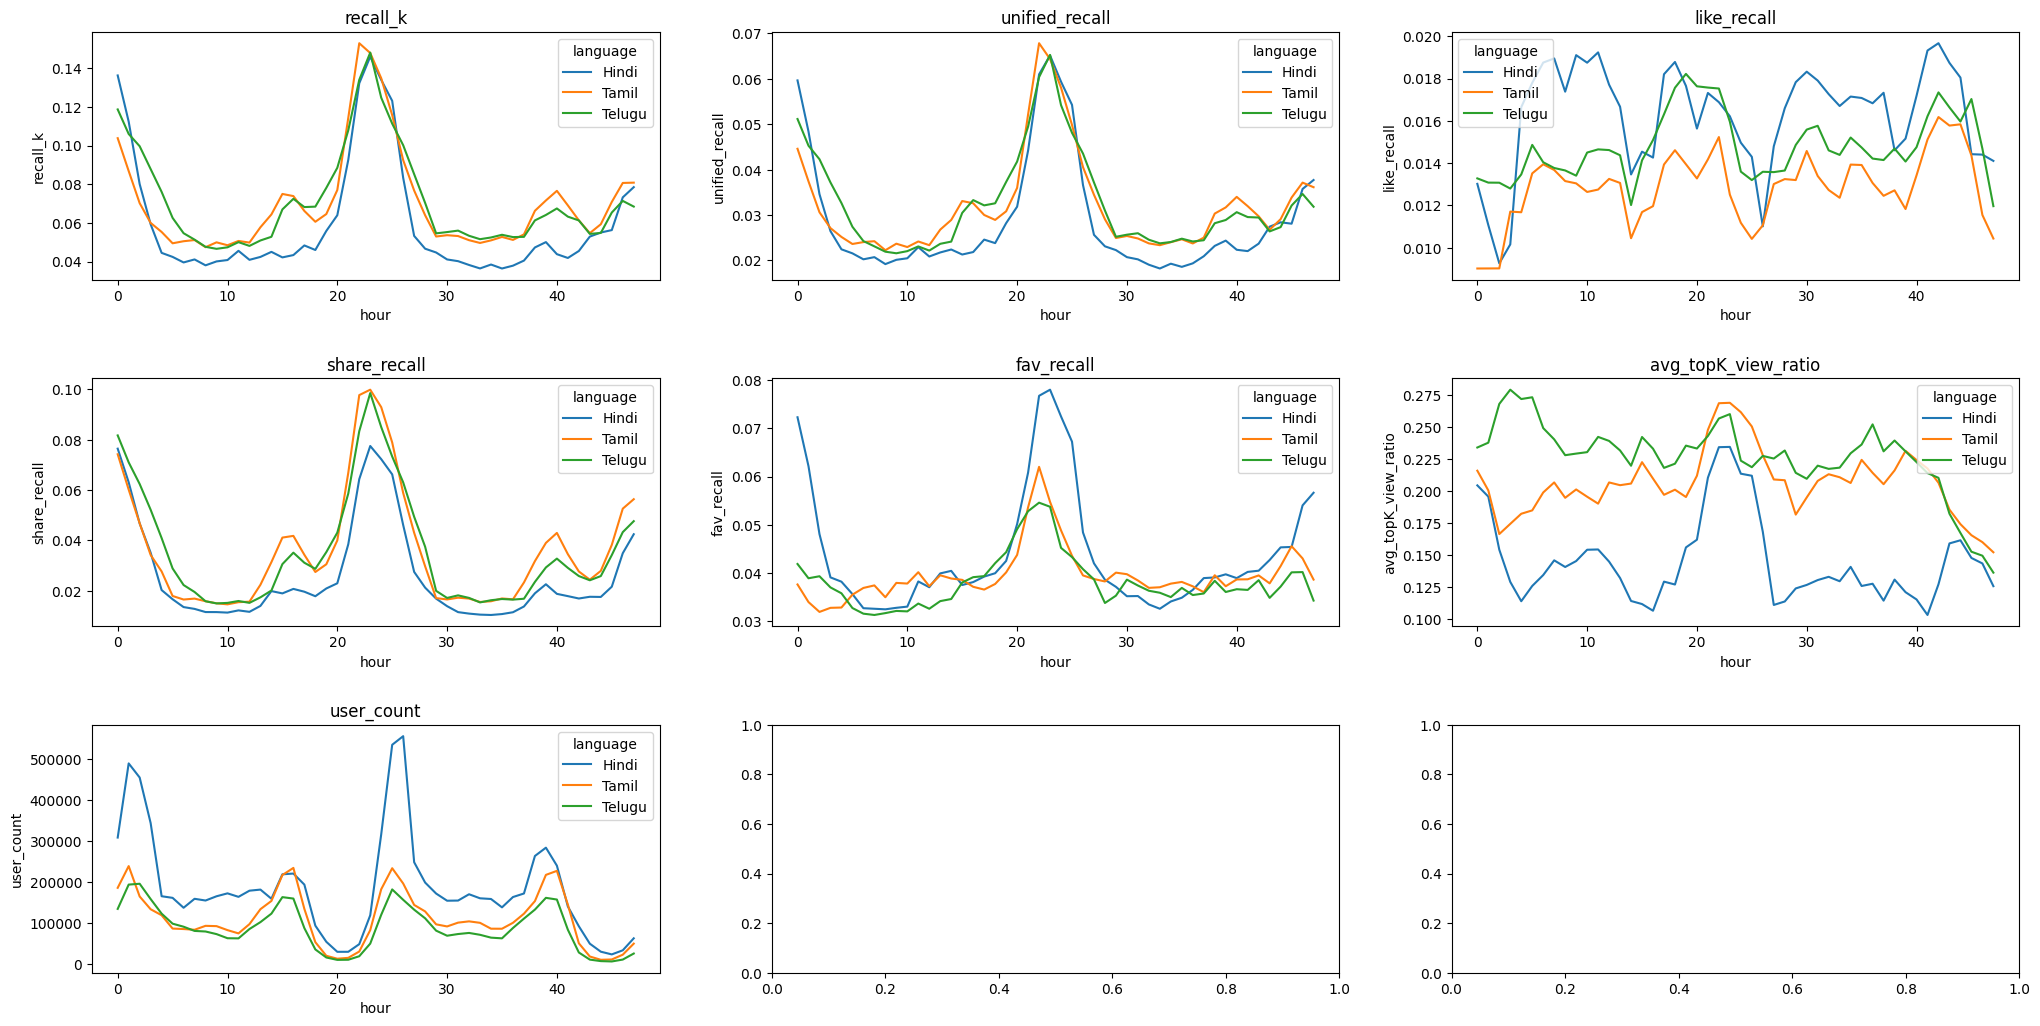

In [6]:
metrics = ideal_recall_series_df.columns[2:]

cols = 3
rows = int(np.ceil(len(metrics)/3))
fig,axs = plt.subplots(rows,cols, figsize = (20,10))
fig.tight_layout(h_pad=5, w_pad=5)

for i in range(len(metrics)):
    x = i//cols
    y = i%cols
    sns.lineplot(data = ideal_recall_series_df, x = 'hour', y = metrics[i] , hue = 'language', ax = axs[x][y])
    axs[x][y].set_title(f"{metrics[i]}")

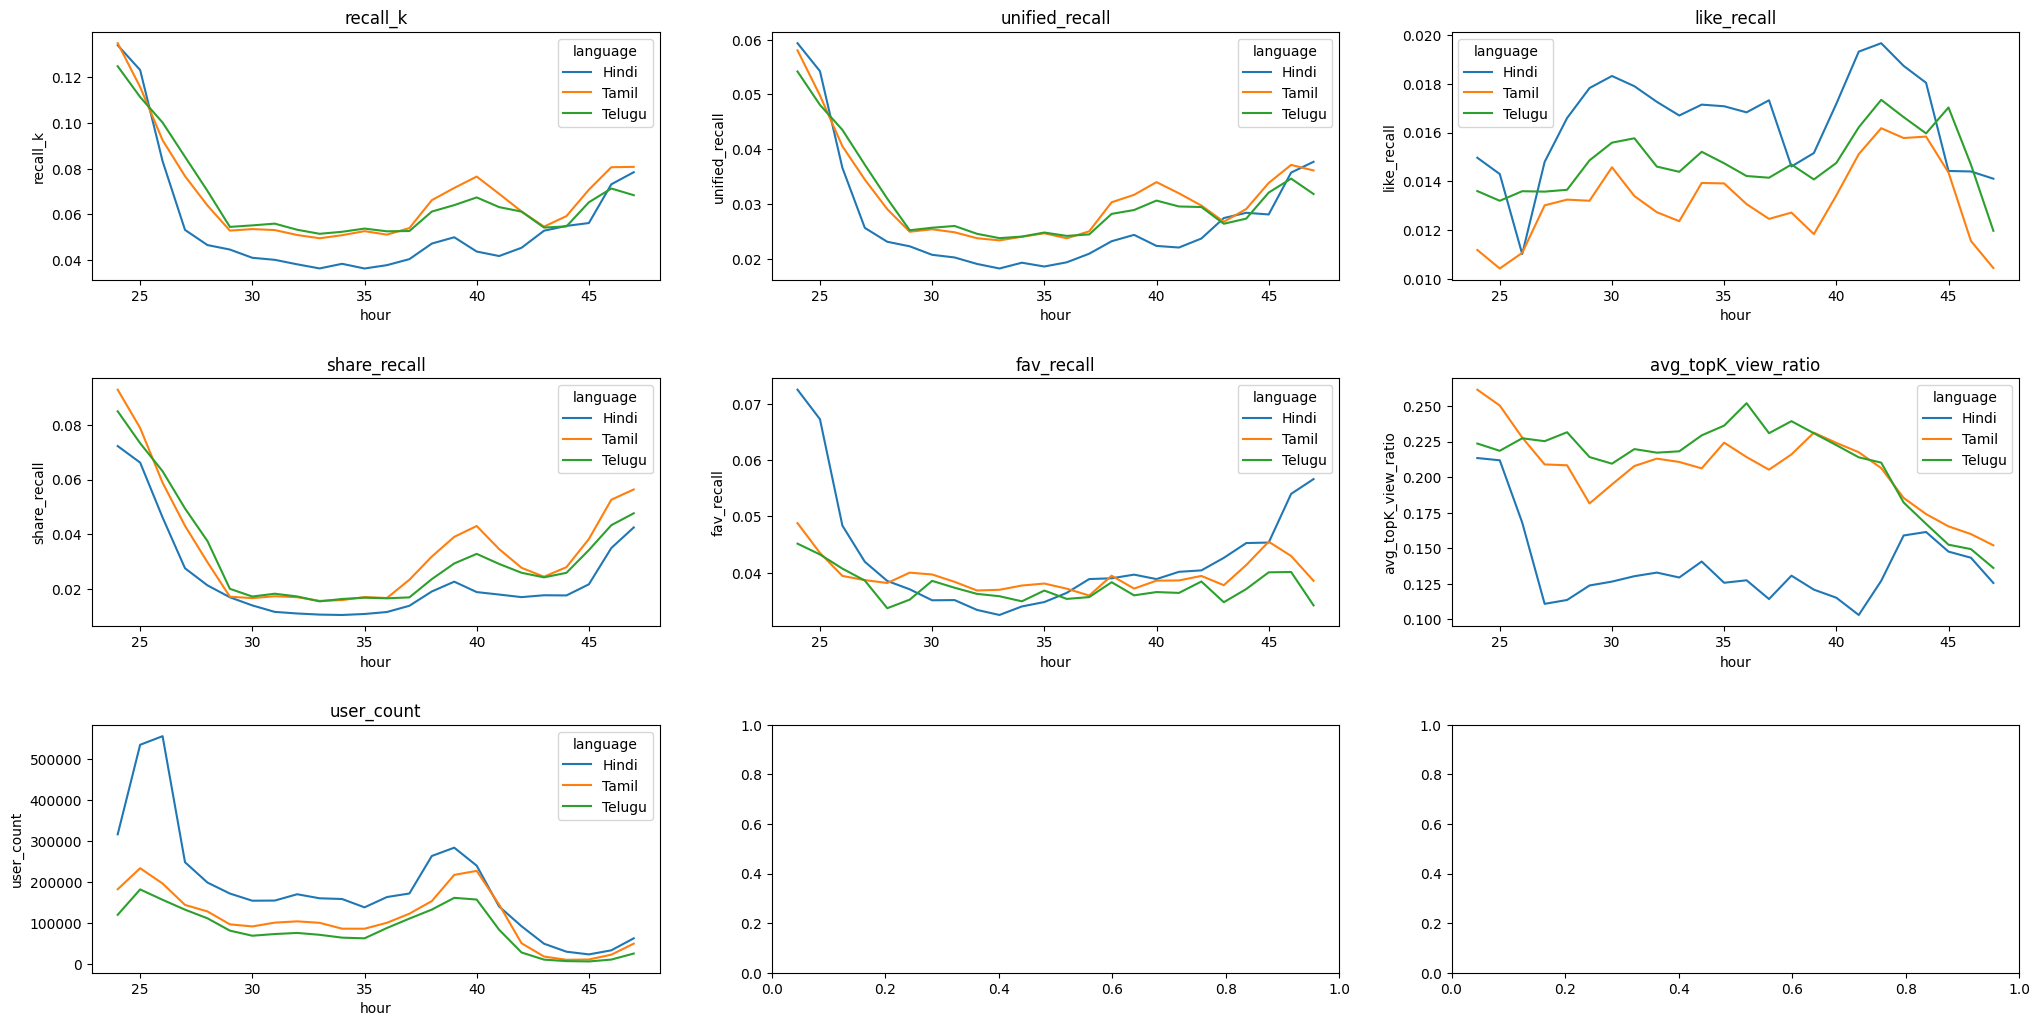

In [9]:
metrics = ideal_recall_series_df.columns[2:]

cols = 3
rows = int(np.ceil(len(metrics)/3))
fig,axs = plt.subplots(rows,cols, figsize = (20,10))
fig.tight_layout(h_pad=5, w_pad=5)

for i in range(len(metrics)):
    x = i//cols
    y = i%cols
    sns.lineplot(data = ideal_recall_series_df[ideal_recall_series_df.hour > 23], x = 'hour', y = metrics[i] , hue = 'language', ax = axs[x][y])
    axs[x][y].set_title(f"{metrics[i]}")

<AxesSubplot:>

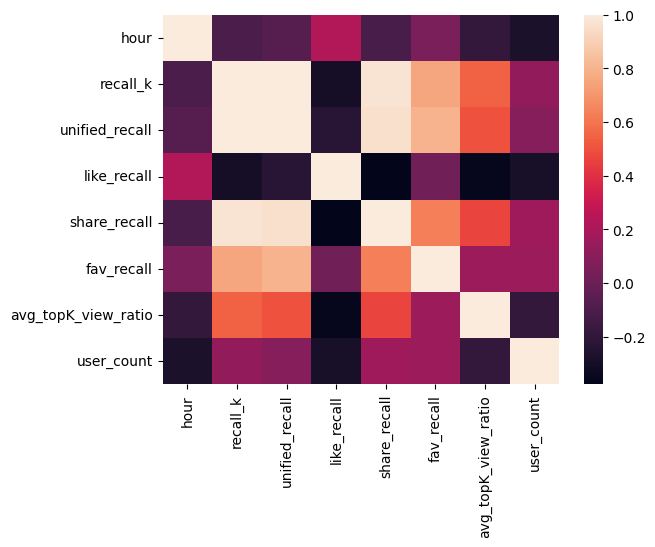

In [7]:
sns.heatmap(ideal_recall_series_df.corr())

### Recall time analysis: Popularity Ranking

In [30]:
%%bigquery recall_series_df --use_rest_api
with recall as(
    with post_detr as
    (
        with post_creation as 
        (
            select postId, language
            from `maximal-furnace-783.sc_analytics.all_posts2`
            where time between '2022-12-15' and '2022-12-23' and composeType = 'image' and language in ('Hindi','Tamil','Telugu')
        ),
        post_hour_counts as
        (
            with post_dets as
            (
                with hour_counts as
                (
                    select postId, date(time) as day, extract(hour from time) as hour_of_day,
                    sum(ifnull(likes,0)) as hour_likes,
                    sum(ifnull(shares,0)) as hour_shares,
                    sum(ifnull(favs,0)) as hour_favs,
                    sum(ifnull(views,0)) as hour_views,
                    from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                    where date(time) between '2022-12-21' and '2022-12-22' and type = 'image' and language in ('Hindi','Tamil','Telugu')
                    group by postId, day, hour_of_day
                ),
                hours_day as
                (    
                    
                    with dates as
                    (
                        select day from unnest(generate_date_array('2022-12-21','2022-12-22')) as day
                    ),
                    hours as 
                    (
                        SELECT hour FROM UNNEST(GENERATE_ARRAY(0, 23)) AS hour
                    ),
                    posts as 
                    (
                        select distinct postId
                        from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                        where date(time) between '2022-12-21' and '2022-12-22' and type = 'image' and language in ('Hindi','Tamil','Telugu')
                    )
                    select postId, dates.day, hours.hour 
                    from dates cross join hours
                    cross join posts
                )
            
                select A.postId, A.day, A.hour as hour_of_day,
                ifnull(hour_views,0) as hour_views, ifnull(hour_likes,0) as hour_likes, ifnull(hour_shares,0) as hour_shares, ifnull(hour_favs,0) as hour_favs
                from hours_day as A
                left join hour_counts as B on A.postId = B.postId and A.hour = B.hour_of_day and A.day = B.day
            )
            select postId, day, hour_of_day,
            sum(hour_likes) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_likes,
            sum(hour_shares) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_shares,
            sum(hour_favs) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_favs,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_views
            from post_dets
        )
            select A.postId, language, hour_of_day, 
            row_number() over (partition by language, hour_of_day order by cast( (hr24_favs + hr24_shares + least(4*hr24_shares,hr24_likes) + 2) /(hr24_views+100) as float64) DESC ) as rownum
            from post_hour_counts as A
            inner join post_creation as B
            on A.postId = B.postId
            where A.day = '2022-12-22'
    ),
    user_engagements as
    (
        select userId, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0)) as pos_eng, post_lang, 
        extract(hour from time) as hour,
        sum(ifnull(likes,0)) as total_likes, sum(ifnull(shares,0)) as total_shares, sum(ifnull(favs,0)) as total_favs,
        0.2*(sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))) as unified_signal, count(1) as Total_views
        from `sharechat-production.sc_golden_dataset.flat_table_v1`
        where date(time) = '2022-12-22' and contentType = 'image' and post_lang in ('Hindi','Tamil','Telugu')
        group by userId, post_lang, hour
    )
    select B.userId, B.hour,
    B.post_lang as language, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))/least(50,min(B.pos_eng)+1) as recall_k,
    sum(ifnull(likes,0))/(least(min(total_likes), count(1))+1) as like_recall,
    sum(ifnull(shares,0))/(least(min(total_shares), count(1))+1) as share_recall,
    sum(ifnull(favs,0))/(least(min(total_favs), count(1))+1) as fav_recall,
    count(1)/(min(Total_views)+1) as k_view_ratio,
    0.2*(sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0)))/(least(min(unified_signal), count(1))+1) as unified_recall
    from `sharechat-production.sc_golden_dataset.flat_table_v1` as A
    inner join user_engagements as B on A.userId = B.userId and extract(hour from A.time) = B.hour
    inner join post_detr as C on A.postId = C.postId and C.hour_of_day + 1 = extract(hour from A.time) and B.post_lang = C.language
    where date(A.time) = '2022-12-22' and C.rownum<=50
    group by B.userId, B.post_lang, B.hour
)
select language, hour, avg(recall_k) as recall_k, avg(unified_recall) as unified_recall, avg(like_recall) as like_recall, avg(share_recall) as share_recall, avg(fav_recall) as fav_recall,
avg(k_view_ratio) as avg_views
from recall
group by language, hour
order by language, hour

Query is running:   0%|          |

Downloading:   0%|          |

In [96]:
recall_series_query = """
    with recall as(
        with post_detr as
        (
            with post_creation as 
            (
                select postId, language
                from `maximal-furnace-783.sc_analytics.all_posts2`
                where date(time) between '{0}' and '{2}' and composeType = 'image' and language in ('Hindi','Tamil','Telugu')
            ),
            post_hour_counts as
            (
                with post_dets as
                (
                    with hour_counts as
                    (
                        select postId, date(time) as day, extract(hour from time) as hour_of_day,
                        sum(ifnull(likes,0)) as hour_likes,
                        sum(ifnull(shares,0)) as hour_shares,
                        sum(ifnull(favs,0)) as hour_favs,
                        sum(ifnull(views,0)) as hour_views,
                        from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                        where date(time) between '{1}' and '{2}' and type = 'image' and language in ('Hindi','Tamil','Telugu')
                        group by postId, day, hour_of_day
                    ),
                    hours_day as
                    (    

                        with dates as
                        (
                            select day from unnest(generate_date_array('{1}','{2}')) as day
                        ),
                        hours as 
                        (
                            SELECT hour FROM UNNEST(GENERATE_ARRAY(0, 23)) AS hour
                        ),
                        posts as 
                        (
                            select distinct postId
                            from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                            where date(time) between '{1}' and '{2}' and type = 'image' and language in ('Hindi','Tamil','Telugu')
                        )
                        select postId, dates.day, hours.hour 
                        from dates cross join hours
                        cross join posts
                    )

                    select A.postId, A.day, A.hour as hour_of_day,
                    ifnull(hour_views,0) as hour_views, ifnull(hour_likes,0) as hour_likes, ifnull(hour_shares,0) as hour_shares, ifnull(hour_favs,0) as hour_favs
                    from hours_day as A
                    left join hour_counts as B on A.postId = B.postId and A.hour = B.hour_of_day and A.day = B.day
                )
                select postId, day, hour_of_day,
                sum(hour_likes) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_likes,
                sum(hour_shares) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_shares,
                sum(hour_favs) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_favs,
                sum(hour_views) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_views
                from post_dets
            )
                select A.postId, language, hour_of_day, 
                row_number() over (partition by language, hour_of_day order by cast( (hr24_favs + hr24_shares + least(4*hr24_shares,hr24_likes) + 2) /(hr24_views+100) as float64) DESC ) as rownum
                from post_hour_counts as A
                inner join post_creation as B
                on A.postId = B.postId
                where A.day = '{2}'
        ),
        user_engagements as
        (
            select userId, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0)) as pos_eng, post_lang, 
            extract(hour from time) as hour,
            sum(ifnull(likes,0)) as total_likes, sum(ifnull(shares,0)) as total_shares, sum(ifnull(favs,0)) as total_favs,
            0.2*(sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))) as unified_signal, count(1) as Total_views
            from `sharechat-production.sc_golden_dataset.flat_table_v1`
            where date(time) = '{2}' and contentType = 'image' and post_lang in ('Hindi','Tamil','Telugu')
            group by userId, post_lang, hour
        )
        select B.userId, B.hour,
        B.post_lang as language, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))/least({3},min(B.pos_eng)+1) as recall_k,
        sum(ifnull(likes,0))/(least(min(total_likes), count(1))+1) as like_recall,
        sum(ifnull(shares,0))/(least(min(total_shares), count(1))+1) as share_recall,
        sum(ifnull(favs,0))/(least(min(total_favs), count(1))+1) as fav_recall,
        count(1)/(min(Total_views)+1) as k_view_ratio,
        0.2*(sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0)))/(least(min(unified_signal), count(1))+1) as unified_recall
        from `sharechat-production.sc_golden_dataset.flat_table_v1` as A
        inner join user_engagements as B on A.userId = B.userId and extract(hour from A.time) = B.hour
        left join post_detr as C on A.postId = C.postId and C.hour_of_day + 1 = extract(hour from A.time) and B.post_lang = C.language
        where date(A.time) = '{2}' and C.rownum<={3}
        group by B.post_lang, B.hour, B.userId
    )
    select language, hour, avg(recall_k) as recall_k, avg(unified_recall) as unified_recall, avg(like_recall) as like_recall, avg(share_recall) as share_recall, avg(fav_recall) as fav_recall,
    avg(k_view_ratio) as avg_topK_view_ratio, count(1) as user_count
    from recall
    group by language, hour
    order by language, hour
"""

run_query(recall_series_query.format('2022-12-15','2022-12-21','2022-12-22',50))

Total bytes processed 420.524883798 GB


""


In [97]:
recall_series_df = run_query(recall_series_query.format('2022-12-15','2022-12-21','2022-12-22',50), estimate_cost = False)

In [98]:
recall_series_df.head()

,language,hour,recall_k,unified_recall,like_recall,share_recall,fav_recall,avg_topK_view_ratio,user_count
0,Hindi,1,0.103283,0.044542,0.010973,0.060628,0.054511,0.187744,461519
1,Hindi,2,0.088991,0.038285,0.009796,0.051007,0.048195,0.192001,520806
2,Hindi,3,0.057771,0.024583,0.007116,0.035385,0.032078,0.152448,397882
3,Hindi,4,0.041800,0.017772,0.005621,0.026476,0.023443,0.156593,315099
4,Hindi,5,0.026248,0.011107,0.004362,0.016912,0.015615,0.147120,204469


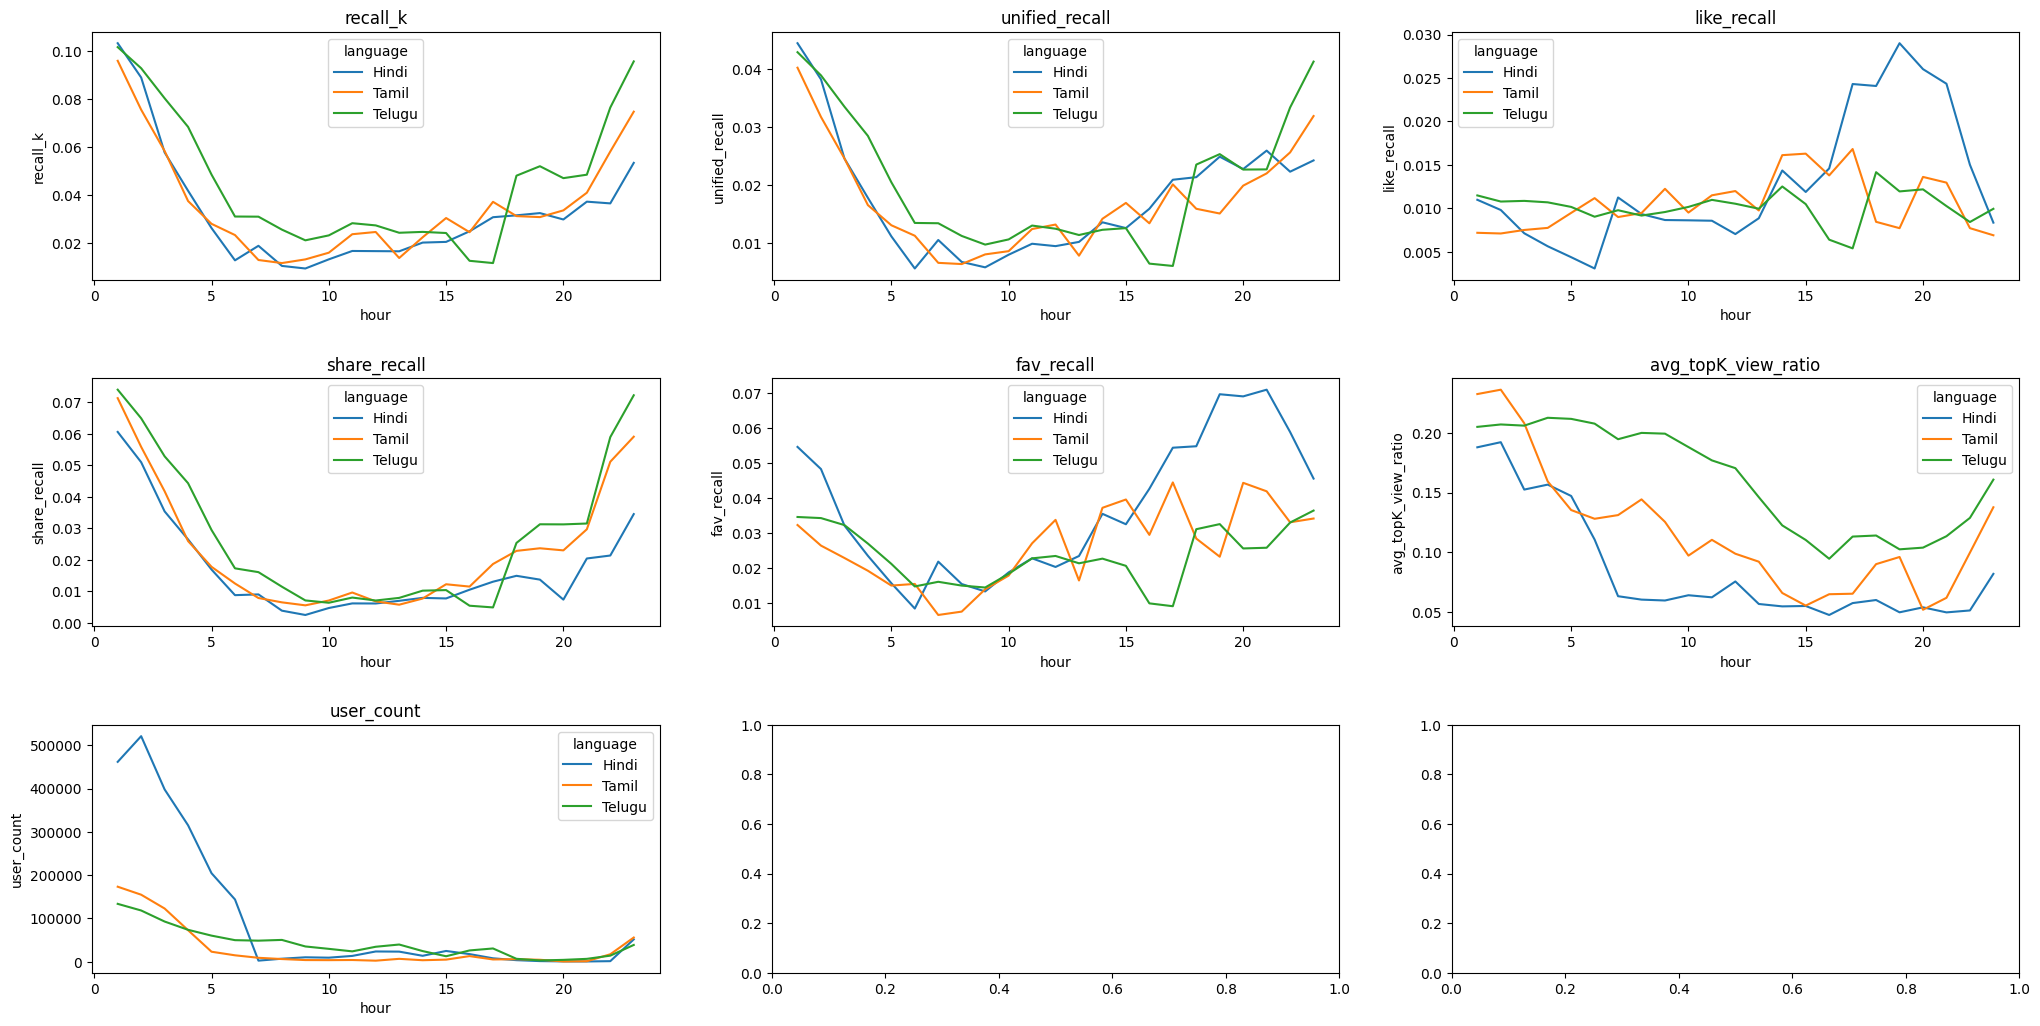

In [99]:
metrics = recall_series_df.columns[2:]

cols = 3
rows = int(np.ceil(len(metrics)/3))
fig,axs = plt.subplots(rows,cols, figsize = (20,10))
fig.tight_layout(h_pad=5, w_pad=5)

for i in range(len(metrics)):
    x = i//cols
    y = i%cols
    sns.lineplot(data = recall_series_df, x = 'hour', y = metrics[i] , hue = 'language', ax = axs[x][y])
    axs[x][y].set_title(f"{metrics[i]}")

In [100]:
recall_series_df_500 = run_query(recall_series_query.format('2022-12-15','2022-12-21','2022-12-22',500), estimate_cost = False)

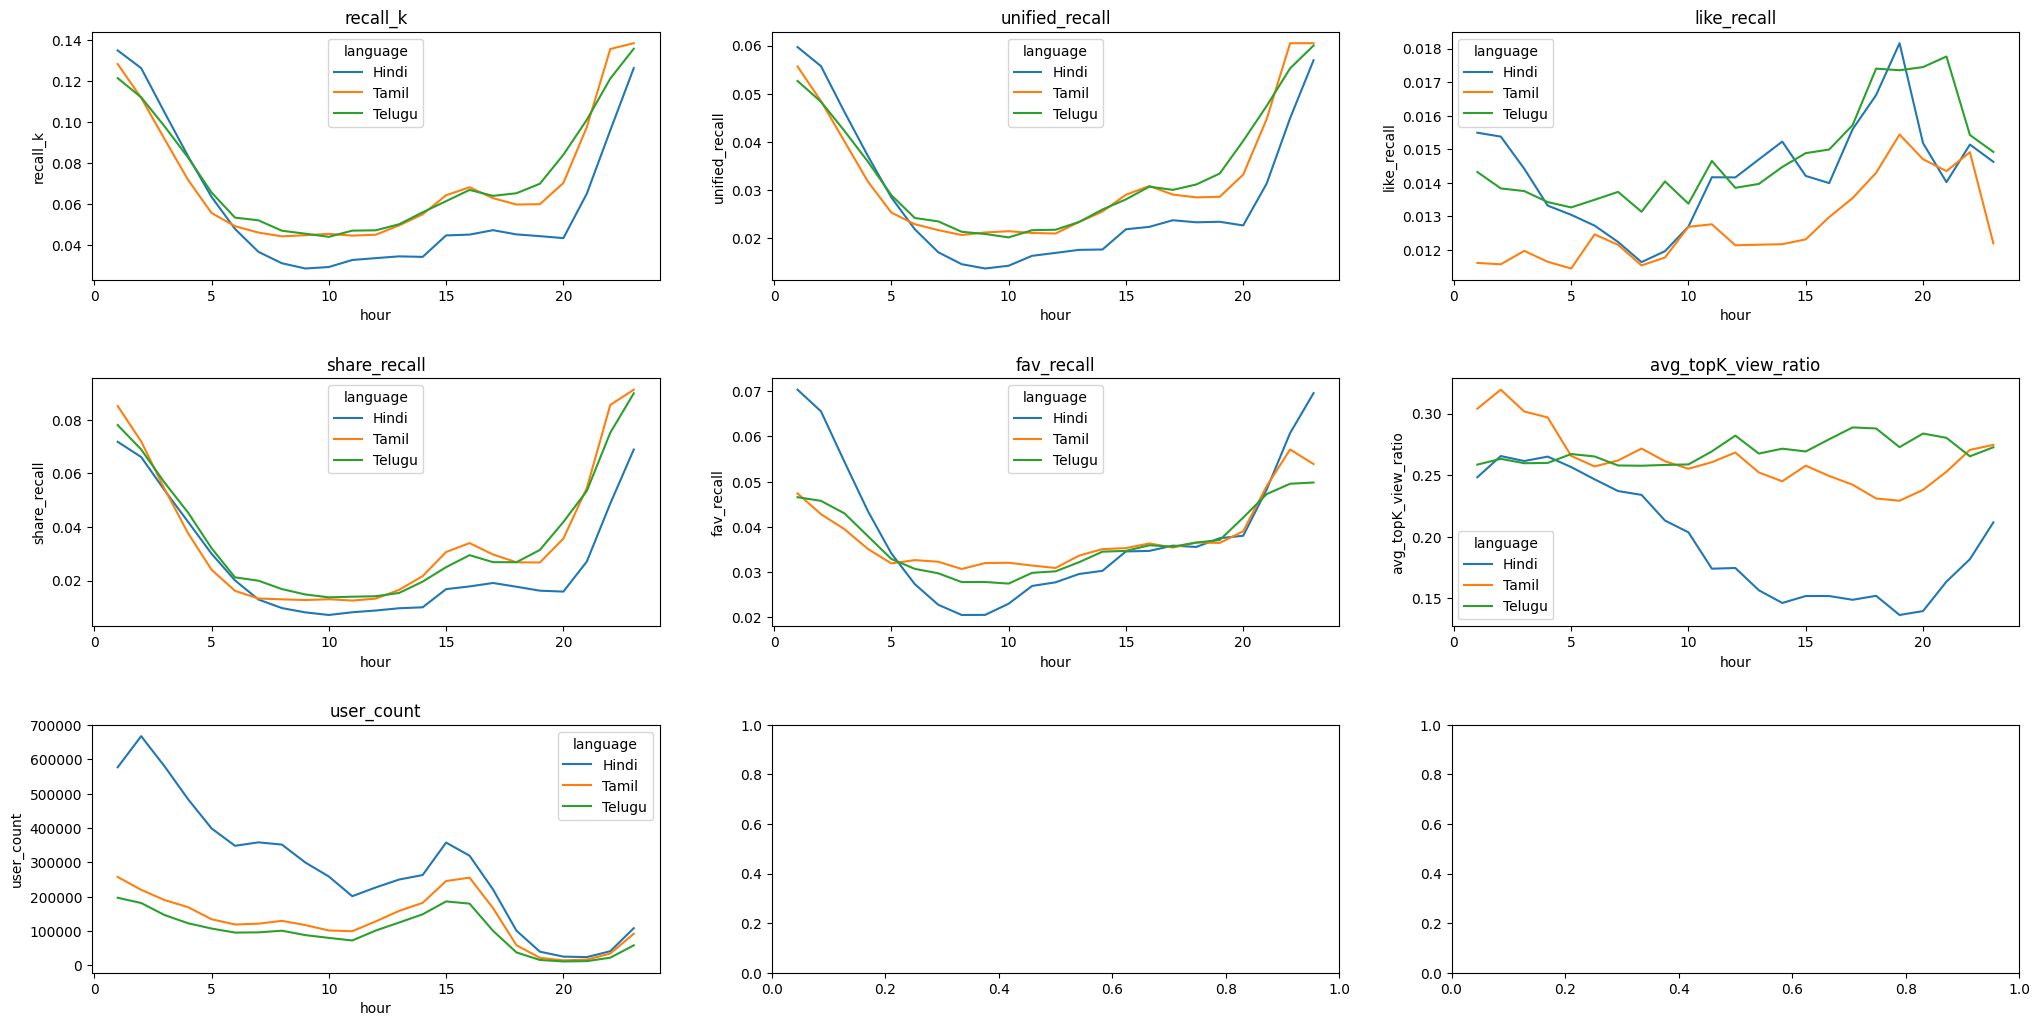

In [101]:
metrics = recall_series_df_500.columns[2:]

cols = 3
rows = int(np.ceil(len(metrics)/3))
fig,axs = plt.subplots(rows,cols, figsize = (20,10))
fig.tight_layout(h_pad=5, w_pad=5)

for i in range(len(metrics)):
    x = i//cols
    y = i%cols
    sns.lineplot(data = recall_series_df_500, x = 'hour', y = metrics[i] , hue = 'language', ax = axs[x][y])
    axs[x][y].set_title(f"{metrics[i]}")

In [102]:
recall_series_df2_500 = run_query(recall_series_query.format('2023-01-31','2023-02-06','2023-02-07',500), estimate_cost = False)

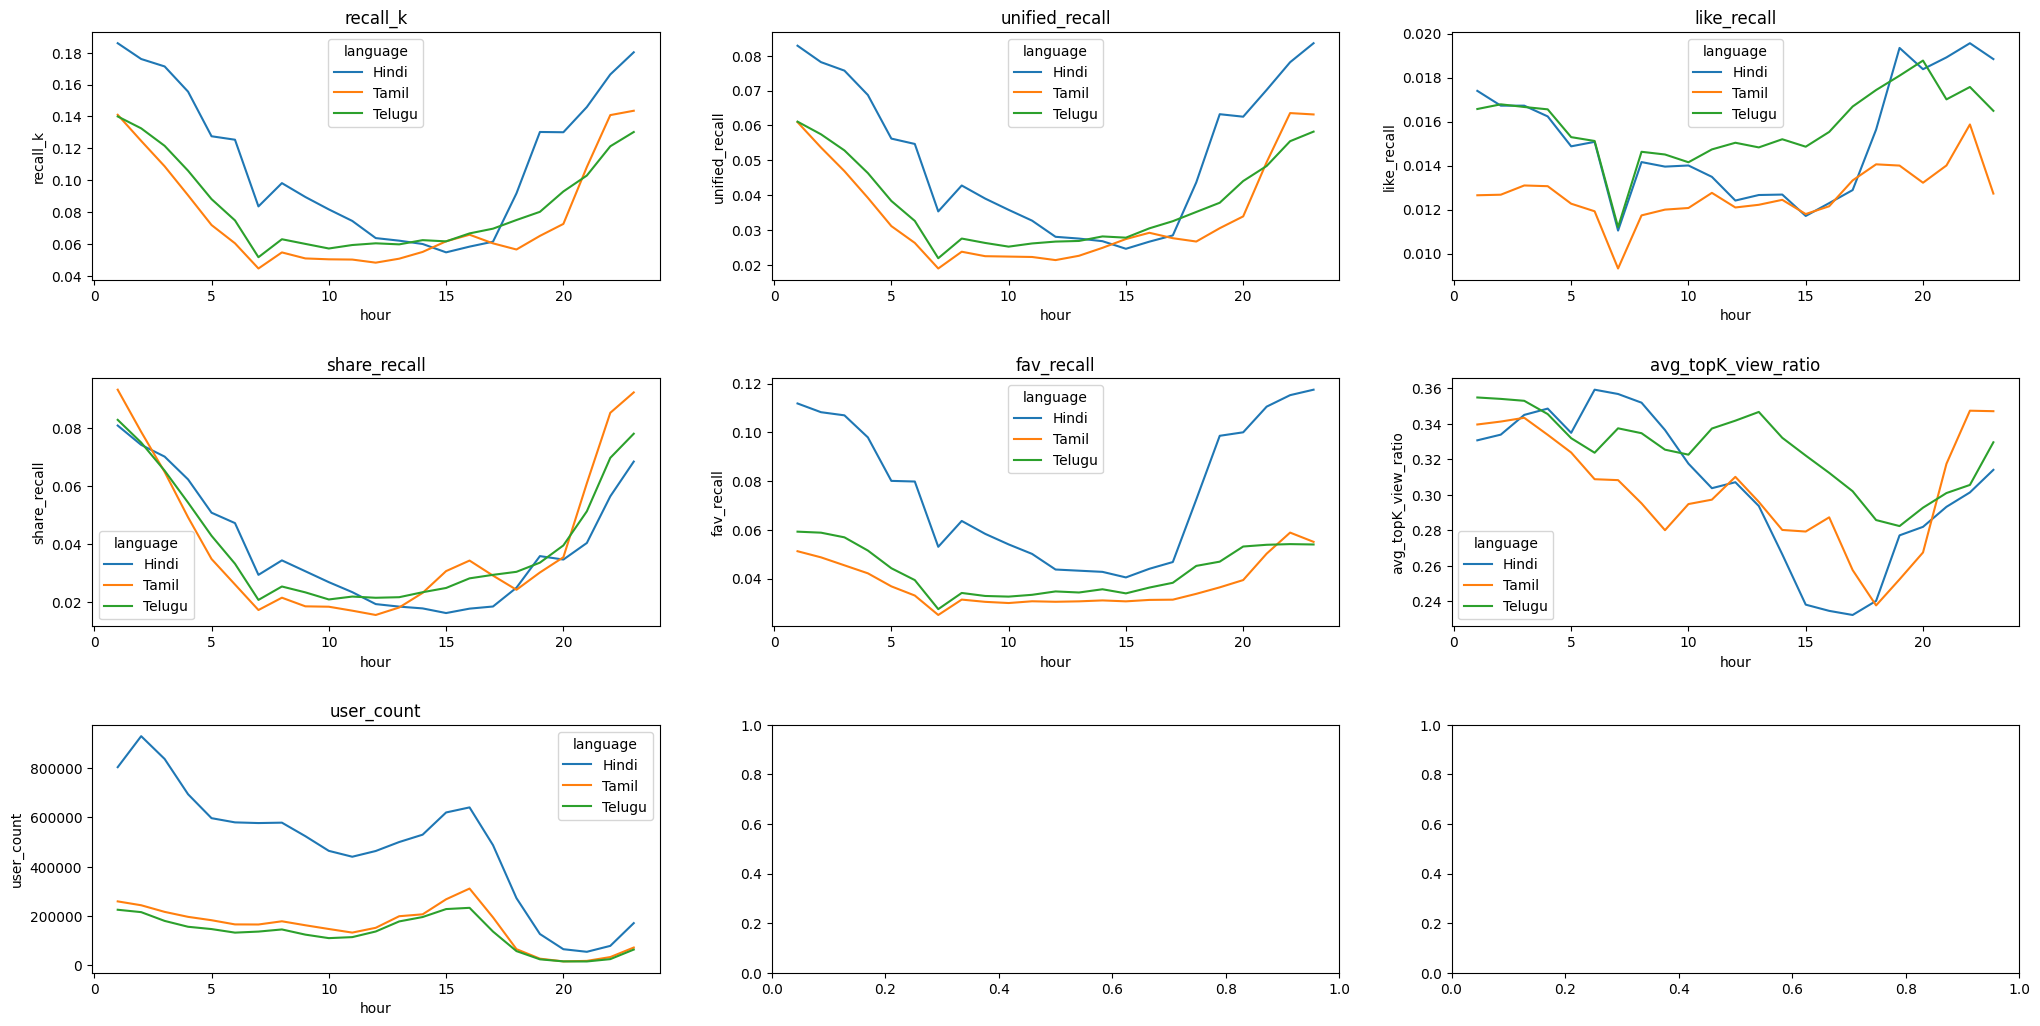

In [103]:
metrics = recall_series_df2_500.columns[2:]

cols = 3
rows = int(np.ceil(len(metrics)/3))
fig,axs = plt.subplots(rows,cols, figsize = (20,10))
fig.tight_layout(h_pad=5, w_pad=5)

for i in range(len(metrics)):
    x = i//cols
    y = i%cols
    sns.lineplot(data = recall_series_df2_500, x = 'hour', y = metrics[i] , hue = 'language', ax = axs[x][y])
    axs[x][y].set_title(f"{metrics[i]}")

In [104]:
%%bigquery user_count_df --use_rest_api
select post_lang as language, extract(hour from time) as hour, count(1) as user_count
from `sharechat-production.sc_golden_dataset.flat_table_v1`
where date(time) = '2022-12-22' and contentType = 'image' and post_lang in ('Hindi','Tamil','Telugu')
group by language, hour

Query is running:   0%|          |

Downloading:   0%|          |

<AxesSubplot:xlabel='hour', ylabel='user_count'>

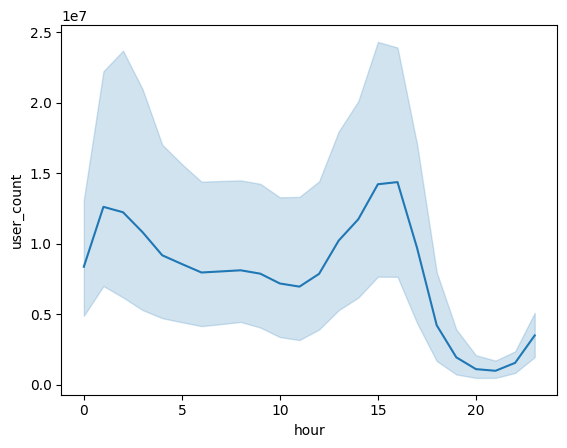

In [105]:
sns.lineplot(data = user_count_df, x = 'hour', y = 'user_count')

### Popularity ranking: Score = $\frac{hr24\_favs + hr24\_shares + min(4*hr24\_shares,hr24\_likes) + 2}{hr24\_views+100}$

In [11]:
%%bigquery --use_rest_api
with recall as(
    with post_detr as
    (
        with post_creation as 
        (
            select postId, language
            from `maximal-furnace-783.sc_analytics.all_posts2`
            where time between '2022-12-15' and '2022-12-23' and composeType = 'image' and language in ('Hindi','Tamil','Telugu')
        ),
        post_hour_counts as
        (
            with post_dets as
            (
                with hour_counts as
                (
                    select postId, date(time) as day, extract(hour from time) as hour_of_day,
                    sum(ifnull(likes,0)) as hour_likes,
                    sum(ifnull(shares,0)) as hour_shares,
                    sum(ifnull(favs,0)) as hour_favs,
                    sum(ifnull(views,0)) as hour_views,
                    from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                    where date(time) between '2022-12-21' and '2022-12-22' and type = 'image' and language in ('Hindi','Tamil','Telugu')
                    group by postId, day, hour_of_day
                ),
                hours_day as
                (    
                    
                    with dates as
                    (
                        select day from unnest(generate_date_array('2022-12-21','2022-12-22')) as day
                    ),
                    hours as 
                    (
                        SELECT hour FROM UNNEST(GENERATE_ARRAY(0, 23)) AS hour
                    ),
                    posts as 
                    (
                        select distinct postId
                        from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                        where date(time) between '2022-12-21' and '2022-12-22' and type = 'image' and language in ('Hindi','Tamil','Telugu')
                    )
                    select postId, dates.day, hours.hour 
                    from dates cross join hours
                    cross join posts
                )
            
                select A.postId, A.day, A.hour as hour_of_day,
                ifnull(hour_views,0) as hour_views, ifnull(hour_likes,0) as hour_likes, ifnull(hour_shares,0) as hour_shares, ifnull(hour_favs,0) as hour_favs
                from hours_day as A
                left join hour_counts as B on A.postId = B.postId and A.hour = B.hour_of_day and A.day = B.day
            )
            select postId, day, hour_of_day,
            sum(hour_likes) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_likes,
            sum(hour_shares) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_shares,
            sum(hour_favs) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_favs,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_views
            from post_dets
        )
            select A.postId, language, hour_of_day, 
            row_number() over (partition by language, hour_of_day order by cast( (hr24_favs + hr24_shares + least(4*hr24_shares,hr24_likes) + 2) /(hr24_views+100) as float64) DESC ) as rownum
            from post_hour_counts as A
            inner join post_creation as B
            on A.postId = B.postId
            where A.day = '2022-12-22'
    ),
    user_engagements as
    (
        select userId, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0)) as pos_eng, post_lang, 
        sum(ifnull(likes,0)) as total_likes, sum(ifnull(shares,0)) as total_shares, sum(ifnull(favs,0)) as total_favs,
        sum( case when ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0) > 0 then 1 else 0 end) as bin_eng,
        from `sharechat-production.sc_golden_dataset.flat_table_v1`
        where date(time) = '2022-12-22' and contentType = 'image' and post_lang in ('Hindi','Tamil','Telugu')
        group by userId, post_lang
    )
    select B.userId,
    B.post_lang as language, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))/least(500,min(B.pos_eng)+1) as recall_k, 
    sum( case when ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0) > 0 then 1 else 0 end )/least(500, min(B.bin_eng)+1) as bin_recall_k,
    sum(ifnull(likes,0))/(least(min(total_likes), count(1))+1) as like_recall,
    sum(ifnull(shares,0))/(least(min(total_shares), count(1))+1) as share_recall,
    sum(ifnull(favs,0))/(least(min(total_favs), count(1))+1) as fav_recall,
    from `sharechat-production.sc_golden_dataset.flat_table_v1` as A
    inner join user_engagements as B on A.userId = B.userId
    inner join post_detr as C on A.postId = C.postId and C.hour_of_day + 1 = extract(hour from A.time) and B.post_lang = C.language
    where date(A.time) = '2022-12-22' and C.rownum<=500
    group by B.userId, B.post_lang
)
select language, avg(recall_k) as recall_k, avg(bin_recall_k) as bin_recall_k, avg(like_recall) as like_recall,
avg(share_recall) as share_recall, avg(fav_recall) as fav_recall, count(userId) as user_count
from recall
group by language
order by language

Query is running:   0%|          |

Downloading:   0%|          |

,language,recall_k,bin_recall_k,like_recall,share_recall,fav_recall,user_count
0,Hindi,0.075911,0.075038,0.014971,0.037201,0.045389,4860825
1,Tamil,0.078197,0.077469,0.013091,0.042260,0.040806,2174056
2,Telugu,0.081855,0.080852,0.015517,0.042901,0.041119,1650583


### Metric 1: Score = $\frac{hr24\_eng + 6*lag0\_eng + 4*lag7\_eng +2}{hr24\_views + 6*lag0\_views + 4*lag7\_views +100}$

In [11]:
%%bigquery --use_rest_api
with recall as(
    with post_detr as
    (
        with post_creation as 
        (
            select postId, language
            from `maximal-furnace-783.sc_analytics.all_posts2`
            where time between '2022-12-15' and '2022-12-23' and composeType = 'image' and language in ('Hindi','Tamil','Telugu')
        ),
        post_hour_counts as
        (
            with post_dets as
            (
                with hour_counts as
                (
                    select postId, date(time) as day, extract(hour from time) as hour_of_day,
                    sum(ifnull(favs,0)) + sum(ifnull(shares,0)) + least(sum(4*ifnull(shares,0)) ,sum(ifnull(likes,0))) as hour_eng,
                    sum(ifnull(views,0)) as hour_views,
                    from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                    where date(time) between '2022-12-21' and '2022-12-22' and type = 'image' and language in ('Hindi','Tamil','Telugu')
                    group by postId, day, hour_of_day
                ),
                hours_day as
                (    
                    
                    with dates as
                    (
                        select day from unnest(generate_date_array('2022-12-21','2022-12-22')) as day
                    ),
                    hours as 
                    (
                        SELECT hour FROM UNNEST(GENERATE_ARRAY(0, 23)) AS hour
                    ),
                    posts as 
                    (
                        select distinct postId
                        from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                        where date(time) between '2022-12-21' and '2022-12-22' and type = 'image' and language in ('Hindi','Tamil','Telugu')
                    )
                    select postId, dates.day, hours.hour 
                    from dates cross join hours
                    cross join posts
                )
            
                select A.postId, A.day, A.hour as hour_of_day, ifnull(hour_eng,0) as hour_eng, ifnull(hour_views,0) as hour_views
                from hours_day as A
                left join hour_counts as B on A.postId = B.postId and A.hour = B.hour_of_day and A.day = B.day
            )
            select postId, day, hour_of_day,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 2 preceding and current row) as lag0_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 2 preceding and current row) as lag0_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 5 preceding and 3 preceding) as lag1_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 5 preceding and 3 preceding) as lag1_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 11 preceding and 9 preceding) as lag3_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 11 preceding and 9 preceding) as lag3_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 24 preceding and 21 preceding) as lag7_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 24 preceding and 21 preceding) as lag7_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 27 preceding and 24 preceding) as lag8_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 27 preceding and 24 preceding) as lag8_views
            from post_dets
        )
            select A.postId, language, hour_of_day,
            row_number() over 
                (partition by language, hour_of_day 
                order by 
                 (hr24_eng+2)/(hr24_views +100) + 0.5*(lag0_eng+2)/(lag0_views+100) + 0.25*(lag7_eng+2)/(lag7_views+100)
                 -- + 0.7772*log(((lag1_eng+2)/(lag1_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 -- + 0.0448*log(((lag3_eng+2)/(lag3_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 --  + 0.5305*log(((lag7_eng+2)/(lag7_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 -- - 0.2466*log(((lag8_eng+2)/(lag8_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 
                 DESC ) as rownum
            from post_hour_counts as A
            inner join post_creation as B
            on A.postId = B.postId
            where A.day = '2022-12-22' 
    ),
    user_engagements as
    (
        select userId, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0)) as pos_eng, post_lang, 
        sum(ifnull(likes,0)) as total_likes, sum(ifnull(shares,0)) as total_shares, sum(ifnull(favs,0)) as total_favs
        from `sharechat-production.sc_golden_dataset.flat_table_v1`
        where date(time) = '2022-12-22' and contentType = 'image' and post_lang in ('Hindi','Tamil','Telugu')
        group by userId, post_lang
    )
    select B.userId,
    B.post_lang as language, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))/least(50,min(B.pos_eng)+1) as recall_k,
    sum(ifnull(likes,0))/(least(min(total_likes), count(1))+1) as like_recall,
    sum(ifnull(shares,0))/(least(min(total_shares), count(1))+1) as share_recall,
    sum(ifnull(favs,0))/(least(min(total_favs), count(1))+1) as fav_recall,
    from `sharechat-production.sc_golden_dataset.flat_table_v1` as A
    inner join user_engagements as B on A.userId = B.userId
    inner join post_detr as C on A.postId = C.postId and C.hour_of_day + 1 = extract(hour from A.time) and B.post_lang = C.language
    where date(A.time) = '2022-12-22' and C.rownum<=50
    group by B.userId, B.post_lang
)
select language, avg(recall_k) as recall_k, avg(like_recall) as like_recall, avg(share_recall) as share_recall, avg(fav_recall) as fav_recall
from recall
group by language
order by language

Query is running:   0%|          |

Downloading:   0%|          |

,language,recall_k,like_recall,share_recall,fav_recall
0,Hindi,0.048855,0.008899,0.032717,0.038119
1,Tamil,0.049402,0.008639,0.036802,0.029631
2,Telugu,0.059169,0.011079,0.038759,0.031395


### Score = $\frac{hr24\_eng+2}{hr24\_views +100}$ + $0.5*\frac{lag0\_eng+2}{lag0\_views+1000}$ + $0.25*\frac{lag7\_eng+2}{lag7\_views+100}$

In [8]:
%%bigquery --use_rest_api
with recall as(
    with post_detr as
    (
        with post_creation as 
        (
            select postId, language
            from `maximal-furnace-783.sc_analytics.all_posts2`
            where time between '2022-12-15' and '2022-12-23' and composeType = 'image' and language in ('Hindi','Tamil','Telugu')
        ),
        post_hour_counts as
        (
            with post_dets as
            (
                with hour_counts as
                (
                    select postId, date(time) as day, extract(hour from time) as hour_of_day,
                    sum(ifnull(favs,0)) + sum(ifnull(shares,0)) + least(sum(4*ifnull(shares,0)) ,sum(ifnull(likes,0))) as hour_eng,
                    sum(ifnull(views,0)) as hour_views,
                    from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                    where date(time) between '2022-12-21' and '2022-12-22' and type = 'image' and language in ('Hindi','Tamil','Telugu')
                    group by postId, day, hour_of_day
                ),
                hours_day as
                (    
                    
                    with dates as
                    (
                        select day from unnest(generate_date_array('2022-12-21','2022-12-22')) as day
                    ),
                    hours as 
                    (
                        SELECT hour FROM UNNEST(GENERATE_ARRAY(0, 23)) AS hour
                    ),
                    posts as 
                    (
                        select distinct postId
                        from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                        where date(time) between '2022-12-21' and '2022-12-22' and type = 'image' and language in ('Hindi','Tamil','Telugu')
                    )
                    select postId, dates.day, hours.hour 
                    from dates cross join hours
                    cross join posts
                )
            
                select A.postId, A.day, A.hour as hour_of_day, ifnull(hour_eng,0) as hour_eng, ifnull(hour_views,0) as hour_views
                from hours_day as A
                left join hour_counts as B on A.postId = B.postId and A.hour = B.hour_of_day and A.day = B.day
            )
            select postId, day, hour_of_day,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 2 preceding and current row) as lag0_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 2 preceding and current row) as lag0_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 5 preceding and 3 preceding) as lag1_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 5 preceding and 3 preceding) as lag1_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 11 preceding and 9 preceding) as lag3_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 11 preceding and 9 preceding) as lag3_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 24 preceding and 21 preceding) as lag7_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 24 preceding and 21 preceding) as lag7_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 27 preceding and 24 preceding) as lag8_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 27 preceding and 24 preceding) as lag8_views
            from post_dets
        )
            select A.postId, language, hour_of_day,
            row_number() over 
                (partition by language, hour_of_day 
                order by 
                 (hr24_eng+2)/(hr24_views +100) + 0.5*(lag0_eng+2)/(lag0_views+1000) + 0.25*(lag7_eng+2)/(lag7_views+100)
                 -- + 0.7772*log(((lag1_eng+2)/(lag1_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 -- + 0.0448*log(((lag3_eng+2)/(lag3_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 --  + 0.5305*log(((lag7_eng+2)/(lag7_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 -- - 0.2466*log(((lag8_eng+2)/(lag8_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 
                 DESC ) as rownum
            from post_hour_counts as A
            inner join post_creation as B
            on A.postId = B.postId
            where A.day = '2022-12-22' 
    ),
    user_engagements as
    (
        select userId, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0)) as pos_eng, post_lang, 
        sum(ifnull(likes,0)) as total_likes, sum(ifnull(shares,0)) as total_shares, sum(ifnull(favs,0)) as total_favs
        from `sharechat-production.sc_golden_dataset.flat_table_v1`
        where date(time) = '2022-12-22' and contentType = 'image' and post_lang in ('Hindi','Tamil','Telugu')
        group by userId, post_lang
    )
    select B.userId,
    B.post_lang as language, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))/least(1000,min(B.pos_eng)+1) as recall_k,
    sum(ifnull(likes,0))/(least(min(total_likes), count(1))+1) as like_recall,
    sum(ifnull(shares,0))/(least(min(total_shares), count(1))+1) as share_recall,
    sum(ifnull(favs,0))/(least(min(total_favs), count(1))+1) as fav_recall,
    from `sharechat-production.sc_golden_dataset.flat_table_v1` as A
    inner join user_engagements as B on A.userId = B.userId
    inner join post_detr as C on A.postId = C.postId and C.hour_of_day + 1 = extract(hour from A.time) and B.post_lang = C.language
    where date(A.time) = '2022-12-22' and C.rownum<=1000
    group by B.userId, B.post_lang
)
select language, avg(recall_k) as recall_k, avg(like_recall) as like_recall, avg(share_recall) as share_recall, avg(fav_recall) as fav_recall
from recall
group by language
order by language

Query is running:   0%|          |

Downloading:   0%|          |

,language,recall_k,like_recall,share_recall,fav_recall
0,Hindi,0.102803,0.019947,0.042850,0.061309
1,Tamil,0.099098,0.015700,0.050146,0.051900
2,Telugu,0.098319,0.018027,0.048866,0.049738


### Score = $\frac{hr24\_eng+2}{hr24\_views +100}$ + $2*\frac{lag0\_eng+2}{lag0\_views+1000}$ 

In [10]:
%%bigquery --use_rest_api
with recall as(
    with post_detr as
    (
        with post_creation as 
        (
            select postId, language
            from `maximal-furnace-783.sc_analytics.all_posts2`
            where time between '2022-12-15' and '2022-12-23' and composeType = 'image' and language in ('Hindi','Tamil','Telugu')
        ),
        post_hour_counts as
        (
            with post_dets as
            (
                with hour_counts as
                (
                    select postId, date(time) as day, extract(hour from time) as hour_of_day,
                    sum(ifnull(favs,0)) + sum(ifnull(shares,0)) + least(sum(4*ifnull(shares,0)) ,sum(ifnull(likes,0))) as hour_eng,
                    sum(ifnull(views,0)) as hour_views,
                    from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                    where date(time) between '2022-12-21' and '2022-12-22' and type = 'image' and language in ('Hindi','Tamil','Telugu')
                    group by postId, day, hour_of_day
                ),
                hours_day as
                (    
                    
                    with dates as
                    (
                        select day from unnest(generate_date_array('2022-12-21','2022-12-22')) as day
                    ),
                    hours as 
                    (
                        SELECT hour FROM UNNEST(GENERATE_ARRAY(0, 23)) AS hour
                    ),
                    posts as 
                    (
                        select distinct postId
                        from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                        where date(time) between '2022-12-21' and '2022-12-22' and type = 'image' and language in ('Hindi','Tamil','Telugu')
                    )
                    select postId, dates.day, hours.hour 
                    from dates cross join hours
                    cross join posts
                )
            
                select A.postId, A.day, A.hour as hour_of_day, ifnull(hour_eng,0) as hour_eng, ifnull(hour_views,0) as hour_views
                from hours_day as A
                left join hour_counts as B on A.postId = B.postId and A.hour = B.hour_of_day and A.day = B.day
            )
            select postId, day, hour_of_day,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 2 preceding and current row) as lag0_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 2 preceding and current row) as lag0_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 5 preceding and 3 preceding) as lag1_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 5 preceding and 3 preceding) as lag1_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 11 preceding and 9 preceding) as lag3_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 11 preceding and 9 preceding) as lag3_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 24 preceding and 21 preceding) as lag7_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 24 preceding and 21 preceding) as lag7_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 27 preceding and 24 preceding) as lag8_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 27 preceding and 24 preceding) as lag8_views
            from post_dets
        )
            select A.postId, language, hour_of_day,
            row_number() over 
                (partition by language, hour_of_day 
                order by 
                 (hr24_eng+2)/(hr24_views +100) + 2*(lag0_eng+2)/(lag0_views+1000)
                 
                 DESC ) as rownum
            from post_hour_counts as A
            inner join post_creation as B
            on A.postId = B.postId
            where A.day = '2022-12-22' 
    ),
    user_engagements as
    (
        select userId, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0)) as pos_eng, post_lang, 
        sum(ifnull(likes,0)) as total_likes, sum(ifnull(shares,0)) as total_shares, sum(ifnull(favs,0)) as total_favs,
        sum( case when ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0) > 0 then 1 else 0 end) as bin_eng,
        from `sharechat-production.sc_golden_dataset.flat_table_v1`
        where date(time) = '2022-12-22' and contentType = 'image' and post_lang in ('Hindi','Tamil','Telugu')
        group by userId, post_lang
    )
    select B.userId,
    B.post_lang as language, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))/least(500,min(B.pos_eng)+1) as recall_k,
    sum( case when ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0) > 0 then 1 else 0 end )/least(500, min(B.bin_eng)+1) as bin_recall_k,
    sum(ifnull(likes,0))/(least(min(total_likes), count(1))+1) as like_recall,
    sum(ifnull(shares,0))/(least(min(total_shares), count(1))+1) as share_recall,
    sum(ifnull(favs,0))/(least(min(total_favs), count(1))+1) as fav_recall,
    from `sharechat-production.sc_golden_dataset.flat_table_v1` as A
    inner join user_engagements as B on A.userId = B.userId
    inner join post_detr as C on A.postId = C.postId and C.hour_of_day + 1 = extract(hour from A.time) and B.post_lang = C.language
    where date(A.time) = '2022-12-22' and C.rownum<=500
    group by B.userId, B.post_lang
)
select language, avg(recall_k) as recall_k, avg(bin_recall_k) as bin_recall_k, avg(like_recall) as like_recall, avg(share_recall) as share_recall, avg(fav_recall) as fav_recall, count(userId) as user_count
from recall
group by language
order by language

Query is running:   0%|          |

Downloading:   0%|          |

,language,recall_k,bin_recall_k,like_recall,share_recall,fav_recall,user_count
0,Hindi,0.096845,0.095755,0.018586,0.042214,0.057578,5892088
1,Tamil,0.094724,0.093821,0.014852,0.049335,0.049465,2510783
2,Telugu,0.093330,0.092206,0.017115,0.047293,0.047144,1881700


### Score = $\frac{hr24\_eng+2}{hr24\_views +100}$ + $2*\frac{lag0\_eng+2}{lag0\_views+1000}$ + $0.5*\frac{lag7\_eng+2}{lag7\_views+5000}$ 

In [5]:
%%bigquery --use_rest_api
with recall as(
    with post_detr as
    (
        with post_creation as 
        (
            select postId, language
            from `maximal-furnace-783.sc_analytics.all_posts2`
            where time between '2022-12-15' and '2022-12-23' and composeType = 'image' and language in ('Hindi','Tamil','Telugu')
        ),
        post_hour_counts as
        (
            with post_dets as
            (
                with hour_counts as
                (
                    select postId, date(time) as day, extract(hour from time) as hour_of_day,
                    sum(ifnull(favs,0)) + sum(ifnull(shares,0)) + least(sum(4*ifnull(shares,0)) ,sum(ifnull(likes,0))) as hour_eng,
                    sum(ifnull(views,0)) as hour_views,
                    from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                    where date(time) between '2022-12-21' and '2022-12-22' and type = 'image' and language in ('Hindi','Tamil','Telugu')
                    group by postId, day, hour_of_day
                ),
                hours_day as
                (    
                    
                    with dates as
                    (
                        select day from unnest(generate_date_array('2022-12-21','2022-12-22')) as day
                    ),
                    hours as 
                    (
                        SELECT hour FROM UNNEST(GENERATE_ARRAY(0, 23)) AS hour
                    ),
                    posts as 
                    (
                        select distinct postId
                        from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                        where date(time) between '2022-12-21' and '2022-12-22' and type = 'image' and language in ('Hindi','Tamil','Telugu')
                    )
                    select postId, dates.day, hours.hour 
                    from dates cross join hours
                    cross join posts
                )
            
                select A.postId, A.day, A.hour as hour_of_day, ifnull(hour_eng,0) as hour_eng, ifnull(hour_views,0) as hour_views
                from hours_day as A
                left join hour_counts as B on A.postId = B.postId and A.hour = B.hour_of_day and A.day = B.day
            )
            select postId, day, hour_of_day,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 2 preceding and current row) as lag0_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 2 preceding and current row) as lag0_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 5 preceding and 3 preceding) as lag1_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 5 preceding and 3 preceding) as lag1_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 11 preceding and 9 preceding) as lag3_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 11 preceding and 9 preceding) as lag3_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 24 preceding and 21 preceding) as lag7_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 24 preceding and 21 preceding) as lag7_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 27 preceding and 24 preceding) as lag8_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 27 preceding and 24 preceding) as lag8_views
            from post_dets
        )
            select A.postId, language, hour_of_day,
            row_number() over 
                (partition by language, hour_of_day 
                order by 
                 (hr24_eng+2)/(hr24_views +100) + 2*(lag0_eng+2)/(lag0_views+1000) + 0.25*(lag7_eng+2)/(lag7_views+5000)
                 -- + 0.7772*log(((lag1_eng+2)/(lag1_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 -- + 0.0448*log(((lag3_eng+2)/(lag3_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 --  + 0.5305*log(((lag7_eng+2)/(lag7_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 -- - 0.2466*log(((lag8_eng+2)/(lag8_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 
                 DESC ) as rownum
            from post_hour_counts as A
            inner join post_creation as B
            on A.postId = B.postId
            where A.day = '2022-12-22' 
    ),
    user_engagements as
    (
        select userId, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0)) as pos_eng, post_lang, 
        sum(ifnull(likes,0)) as total_likes, sum(ifnull(shares,0)) as total_shares, sum(ifnull(favs,0)) as total_favs
        from `sharechat-production.sc_golden_dataset.flat_table_v1`
        where date(time) = '2022-12-22' and contentType = 'image' and post_lang in ('Hindi','Tamil','Telugu')
        group by userId, post_lang
    )
    select B.userId,
    B.post_lang as language, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))/least(500,min(B.pos_eng)+1) as recall_k,
    sum(ifnull(likes,0))/(least(min(total_likes), count(1))+1) as like_recall,
    sum(ifnull(shares,0))/(least(min(total_shares), count(1))+1) as share_recall,
    sum(ifnull(favs,0))/(least(min(total_favs), count(1))+1) as fav_recall,
    from `sharechat-production.sc_golden_dataset.flat_table_v1` as A
    inner join user_engagements as B on A.userId = B.userId
    inner join post_detr as C on A.postId = C.postId and C.hour_of_day + 1 = extract(hour from A.time) and B.post_lang = C.language
    where date(A.time) = '2022-12-22' and C.rownum<=500
    group by B.userId, B.post_lang
)
select language, avg(recall_k) as recall_k, avg(like_recall) as like_recall, avg(share_recall) as share_recall, avg(fav_recall) as fav_recall, count(userId) as user_count
from recall
group by language
order by language

Query is running:   0%|          |

Downloading:   0%|          |

,language,recall_k,like_recall,share_recall,fav_recall,user_count
0,Hindi,0.096449,0.018557,0.041872,0.057486,5913884
1,Tamil,0.094676,0.014866,0.049221,0.049498,2520317
2,Telugu,0.093223,0.017135,0.047169,0.047097,1883270


### Recall distribution in Popularity Ranking

In [3]:
%%bigquery recall_pop_df --use_rest_api
with recall as(
    with post_detr as
    (
        with post_creation as 
        (
            select postId, language
            from `maximal-furnace-783.sc_analytics.all_posts2`
            where time between '2022-12-15' and '2022-12-23' and composeType = 'image' and language in ('Hindi','Tamil','Telugu')
        ),
        post_hour_counts as
        (
            with post_dets as
            (
                with hour_counts as
                (
                    select postId, date(time) as day, extract(hour from time) as hour_of_day,
                    sum(ifnull(likes,0)) as hour_likes,
                    sum(ifnull(shares,0)) as hour_shares,
                    sum(ifnull(favs,0)) as hour_favs,
                    sum(ifnull(views,0)) as hour_views,
                    from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                    where date(time) between '2022-12-21' and '2022-12-22' and type = 'image' and language in ('Hindi','Tamil','Telugu')
                    group by postId, day, hour_of_day
                ),
                hours_day as
                (    
                    
                    with dates as
                    (
                        select day from unnest(generate_date_array('2022-12-21','2022-12-22')) as day
                    ),
                    hours as 
                    (
                        SELECT hour FROM UNNEST(GENERATE_ARRAY(0, 23)) AS hour
                    ),
                    posts as 
                    (
                        select distinct postId
                        from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                        where date(time) between '2022-12-21' and '2022-12-22' and type = 'image' and language in ('Hindi','Tamil','Telugu')
                    )
                    select postId, dates.day, hours.hour 
                    from dates cross join hours
                    cross join posts
                )
            
                select A.postId, A.day, A.hour as hour_of_day,
                ifnull(hour_views,0) as hour_views, ifnull(hour_likes,0) as hour_likes, ifnull(hour_shares,0) as hour_shares, ifnull(hour_favs,0) as hour_favs
                from hours_day as A
                left join hour_counts as B on A.postId = B.postId and A.hour = B.hour_of_day and A.day = B.day
            )
            select postId, day, hour_of_day,
            sum(hour_likes) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_likes,
            sum(hour_shares) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_shares,
            sum(hour_favs) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_favs,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_views
            from post_dets
        )
            select A.postId, language, hour_of_day, 
            row_number() over (partition by language, hour_of_day order by cast( (hr24_favs + hr24_shares + least(4*hr24_shares,hr24_likes) + 2) /(hr24_views+100) as float64) DESC ) as rownum
            from post_hour_counts as A
            inner join post_creation as B
            on A.postId = B.postId
            where A.day = '2022-12-22'
    ),
    user_engagements as
    (
        select userId, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0)) as pos_eng, post_lang, 
        sum(ifnull(likes,0)) as total_likes, sum(ifnull(shares,0)) as total_shares, sum(ifnull(favs,0)) as total_favs
        from `sharechat-production.sc_golden_dataset.flat_table_v1`
        where date(time) = '2022-12-22' and contentType = 'image' and post_lang in ('Hindi','Tamil','Telugu')
        group by userId, post_lang
    )
    select B.userId,
    B.post_lang as language, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))/least(500,min(B.pos_eng)+1) as recall_k,
    sum(case when ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0) > 0 then 1 else 0 end)/count(1) as eng_prec,
    sum(ifnull(likes,0))/(least(min(total_likes), count(1))+1) as like_recall,
    sum(ifnull(shares,0))/(least(min(total_shares), count(1))+1) as share_recall,
    sum(ifnull(favs,0))/(least(min(total_favs), count(1))+1) as fav_recall,
    count(1) as views
    from `sharechat-production.sc_golden_dataset.flat_table_v1` as A
    inner join user_engagements as B on A.userId = B.userId
    inner join post_detr as C on A.postId = C.postId and C.hour_of_day + 1 = extract(hour from A.time) and B.post_lang = C.language
    where date(A.time) = '2022-12-22' and C.rownum<=500
    group by B.userId, B.post_lang
)
select language, avg(recall_k) as recall_k, avg(like_recall) as like_recall, avg(share_recall) as share_recall, avg(fav_recall) as fav_recall, 
avg(eng_prec) as avg_eng_prec, count(1) as users, avg(views) as avg_views,
case
    when eng_prec <= 0.1 then '[0-10]'
    when eng_prec <= 0.2 then '[10-20]'
    when eng_prec <= 0.3 then '[20-30]'
    when eng_prec <= 0.4 then '[30-40]'
    when eng_prec <= 0.5 then '[40-50]'
    when eng_prec <= 0.6 then '[50-60]'
    when eng_prec <= 0.7 then '[60-70]'
    when eng_prec <= 0.8 then '[70-80]'
    when eng_prec <= 0.9 then '[80-90]'
    when eng_prec <= 1 then '[90-100]'
    else 'NA'
    end as recall_bracket,
case
    when views <= 10 then '[0-10]'
    when views <= 20 then '[10-20]'
    when views <= 30 then '[20-30]'
    when views <= 40 then '[30-40]'
    else '[40+]'
    end as view_bracks
from recall
group by language, view_bracks, recall_bracket
order by language, view_bracks, recall_bracket

Query is running:   0%|          |

Downloading:   0%|          |

In [4]:
recall_pop_df.describe()

,recall_k,like_recall,share_recall,fav_recall,avg_eng_prec,users,avg_views
count,150.000000,150.000000,150.000000,150.000000,150.000000,1.500000e+02,150.000000
mean,0.354813,0.293691,0.135063,0.251955,0.498773,5.790309e+04,26.915451
std,0.100118,0.248698,0.052490,0.084172,0.294797,3.347135e+05,18.362281
min,0.001533,0.000169,0.000777,0.000779,0.000547,5.000000e+00,1.280172
25%,0.323657,0.083220,0.098399,0.216967,0.245994,9.925000e+01,13.983854
50%,0.369205,0.200083,0.136762,0.274215,0.522031,7.095000e+02,24.405806
75%,0.416824,0.471974,0.174966,0.306223,0.749581,9.858000e+03,34.848649
max,0.507318,0.921227,0.241848,0.384845,1.000000,3.585429e+06,78.157197


In [37]:
recall_pop_df

,language,recall_k,like_recall,share_recall,fav_recall,avg_eng_prec,users,avg_views,recall_bracket
0,Hindi,0.009957,0.001354,0.005003,0.005149,0.002612,3931939,4.295705,[0-10]
1,Hindi,0.313712,0.040970,0.154048,0.167961,0.158916,266150,9.116788,[10-20]
2,Hindi,0.350761,0.054658,0.168194,0.199212,0.252920,139453,7.186887,[20-30]
3,Hindi,0.361597,0.061554,0.172706,0.211810,0.345020,156424,4.922314,[30-40]
4,Hindi,0.369759,0.074329,0.178703,0.226231,0.495036,158492,3.363974,[40-50]
5,Hindi,0.406269,0.184545,0.169042,0.313710,0.582432,13319,8.347248,[50-60]
6,Hindi,0.426798,0.146638,0.196504,0.302650,0.664410,30238,4.504299,[60-70]
7,Hindi,0.424564,0.251834,0.174940,0.347454,0.757061,12117,6.231080,[70-80]
8,Hindi,0.377842,0.463047,0.136445,0.337575,0.850411,2755,9.998548,[80-90]
9,Hindi,0.385235,0.108646,0.204584,0.269732,0.999831,149938,1.333138,[90-100]


In [5]:
recall_pop_df.head()

,language,recall_k,like_recall,share_recall,fav_recall,avg_eng_prec,users,avg_views,recall_bracket,view_bracks
0,Hindi,0.001533,0.000169,0.000777,0.000779,0.000547,3585429,2.710674,[0-10],[0-10]
1,Hindi,0.307004,0.036450,0.151839,0.159114,0.161008,208060,6.692954,[10-20],[0-10]
2,Hindi,0.349771,0.048791,0.170667,0.192041,0.253617,117469,5.416050,[20-30],[0-10]
3,Hindi,0.362152,0.056693,0.174906,0.207956,0.344871,145614,4.081345,[30-40],[0-10]
4,Hindi,0.370609,0.069684,0.180483,0.224058,0.496591,152845,2.880663,[40-50],[0-10]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='recall_bracket', ylabel='users'>

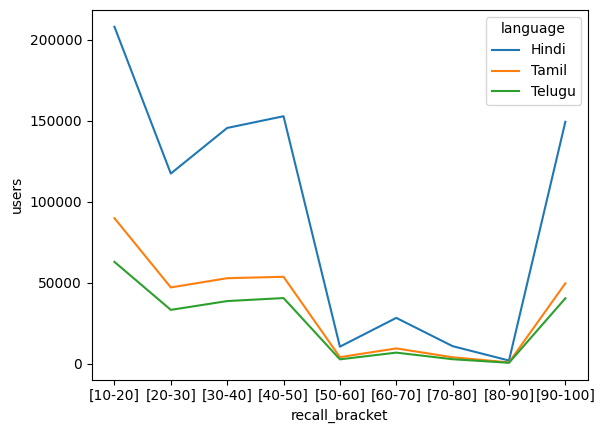

In [36]:
sns.lineplot(data = recall_pop_df[recall_pop_df.view_bracks == '[0-10]'][~(recall_pop_df.recall_bracket.isin(['[0-10]']))], x = 'recall_bracket', y='users', hue = 'language')

In [ ]:
sns.lineplot(data = recall_pop_df[~(recall_pop_df.recall_bracket.isin(['[0-10]']))], x = 'recall_bracket', y='users', hue = 'language')

### Popularity ranking 2: Score = $\frac{hr24\_favs + hr24\_shares + hr24\_likes + 2}{hr24\_views+100}$

In [12]:
%%bigquery --use_rest_api
with recall as(
    with post_detr as
    (
        with post_creation as 
        (
            select postId, language
            from `maximal-furnace-783.sc_analytics.all_posts2`
            where time between '2022-12-15' and '2022-12-23' and composeType = 'image' and language in ('Hindi','Tamil','Telugu')
        ),
        post_hour_counts as
        (
            with post_dets as
            (
                with hour_counts as
                (
                    select postId, date(time) as day, extract(hour from time) as hour_of_day,
                    sum(ifnull(likes,0)) as hour_likes,
                    sum(ifnull(shares,0)) as hour_shares,
                    sum(ifnull(favs,0)) as hour_favs,
                    sum(ifnull(views,0)) as hour_views,
                    from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                    where date(time) between '2022-12-21' and '2022-12-22' and type = 'image' and language in ('Hindi','Tamil','Telugu')
                    group by postId, day, hour_of_day
                ),
                hours_day as
                (    
                    
                    with dates as
                    (
                        select day from unnest(generate_date_array('2022-12-21','2022-12-22')) as day
                    ),
                    hours as 
                    (
                        SELECT hour FROM UNNEST(GENERATE_ARRAY(0, 23)) AS hour
                    ),
                    posts as 
                    (
                        select distinct postId
                        from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                        where date(time) between '2022-12-21' and '2022-12-22' and type = 'image' and language in ('Hindi','Tamil','Telugu')
                    )
                    select postId, dates.day, hours.hour 
                    from dates cross join hours
                    cross join posts
                )
            
                select A.postId, A.day, A.hour as hour_of_day,
                ifnull(hour_views,0) as hour_views, ifnull(hour_likes,0) as hour_likes, ifnull(hour_shares,0) as hour_shares, ifnull(hour_favs,0) as hour_favs
                from hours_day as A
                left join hour_counts as B on A.postId = B.postId and A.hour = B.hour_of_day and A.day = B.day
            )
            select postId, day, hour_of_day,
            sum(hour_likes) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_likes,
            sum(hour_shares) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_shares,
            sum(hour_favs) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_favs,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_views
            from post_dets
        )
            select A.postId, language, hour_of_day, 
            row_number() over (partition by language, hour_of_day order by cast( (hr24_favs + hr24_shares + hr24_likes + 2) /(hr24_views+100) as float64) DESC ) as rownum
            from post_hour_counts as A
            inner join post_creation as B
            on A.postId = B.postId
            where A.day = '2022-12-22'
    ),
    user_engagements as
    (
        select userId, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0)) as pos_eng, post_lang, 
        sum(ifnull(likes,0)) as total_likes, sum(ifnull(shares,0)) as total_shares, sum(ifnull(favs,0)) as total_favs
        from `sharechat-production.sc_golden_dataset.flat_table_v1`
        where date(time) = '2022-12-22' and contentType = 'image' and post_lang in ('Hindi','Tamil','Telugu')
        group by userId, post_lang
    )
    select B.userId,
    B.post_lang as language, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))/least(50,min(B.pos_eng)+1) as recall_k,
    sum(ifnull(likes,0))/(least(min(total_likes), count(1))+1) as like_recall,
    sum(ifnull(shares,0))/(least(min(total_shares), count(1))+1) as share_recall,
    sum(ifnull(favs,0))/(least(min(total_favs), count(1))+1) as fav_recall,
    from `sharechat-production.sc_golden_dataset.flat_table_v1` as A
    inner join user_engagements as B on A.userId = B.userId
    inner join post_detr as C on A.postId = C.postId and C.hour_of_day + 1 = extract(hour from A.time) and B.post_lang = C.language
    where date(A.time) = '2022-12-22' and C.rownum<=50
    group by B.userId, B.post_lang
)
select language, avg(recall_k) as recall_k, avg(like_recall) as like_recall, avg(share_recall) as share_recall, avg(fav_recall) as fav_recall
from recall
group by language
order by language

Query is running:   0%|          |

Downloading:   0%|          |

,language,recall_k,like_recall,share_recall,fav_recall
0,Hindi,0.053148,0.010569,0.037022,0.037965
1,Tamil,0.055465,0.009822,0.044933,0.024497
2,Telugu,0.059847,0.010345,0.042772,0.025963


### Recall@k from random sampling

In [9]:
%%bigquery --use_rest_api
with recall as
(
    with post_detr as
    (
        with post_creation as 
        (
            select postId
            from `maximal-furnace-783.sc_analytics.all_posts2`
            where time between '2022-12-15' and '2022-12-23' and composeType = 'image'
        ),  
        post_hour_counts as
        (
            with post_dets as
            (
                with hour_counts as
                (
                    select postId, date(time) as day, extract(hour from time) as hour_of_day,
                    sum(ifnull(views,0)) as hour_views,
                    from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                    where date(time) between '2022-12-21' and '2022-12-22' and type = 'image'
                    group by postId, day, hour_of_day
                ),
                hours_day as
                (    
                    
                    with dates as
                    (
                        select day from unnest(generate_date_array('2022-12-21','2022-12-22')) as day
                    ),
                    hours as 
                    (
                        SELECT hour FROM UNNEST(GENERATE_ARRAY(0, 23)) AS hour
                    ),
                    posts as 
                    (
                        select distinct postId
                        from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                        where date(time) between '2022-12-21' and '2022-12-22' and type = 'image'
                    )
                    select postId, dates.day, hours.hour 
                    from dates cross join hours
                    cross join posts
                )
            
                select A.postId, A.day, A.hour as hour_of_day, ifnull(hour_views,0) as hour_views
                from hours_day as A
                left join hour_counts as B on A.postId = B.postId and A.hour = B.hour_of_day and A.day = B.day
            )
            select postId, day, hour_of_day, cast(rand() as float64) as random_row,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_views
            from post_dets
        )
            select A.postId, hour_of_day,
            row_number() over (partition by hour_of_day order by random_row DESC ) as rownum
            from post_hour_counts as A
            inner join post_creation as B
            on A.postId = B.postId
            where A.day = '2022-12-22'
    ),
    user_engagements as
    (
        select userId, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0)) as pos_eng
        from `sharechat-production.sc_golden_dataset.flat_table_v1`
        where date(time) = '2022-12-22' and contentType = 'image'
        group by userId
    )
    select A.userId,
    sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))/least(500,B.pos_eng+1) as recall_k
    from `sharechat-production.sc_golden_dataset.flat_table_v1` as A
    inner join user_engagements as B on A.userId = B.userId
    inner join post_detr as C on A.postId = C.postId and C.hour_of_day + 1 = extract(hour from A.time)
    where date(A.time) = '2022-12-22' and contentType = 'image' and C.rownum<=500
    group by A.userId,B.pos_eng
)
select avg(recall_k) as recall500
from recall

Query is running:   0%|          |

Downloading:   0%|          |

,recall500
0,0.007452


### Tag feed ranking formula: Score = $\frac{1.5*hr24\_likes+2*lag6\_likes}{1.5*hr24\_views+2*lag6\_views+500}$ + $\frac{1.5*hr24\_shares+2*lag6\_shares}{1.5*hr24\_views+2*lag6\_views+500}$

In [7]:
%%bigquery --use_rest_api
with recall as(
    with post_detr as
    (
        with post_creation as 
        (
            select postId, language
            from `maximal-furnace-783.sc_analytics.all_posts2`
            where time between '2022-12-15' and '2022-12-23' and composeType = 'image' and language in ('Hindi','Tamil','Telugu')
        ),
        post_hour_counts as
        (
            with post_dets as
            (
                with hour_counts as
                (
                    select postId, date(time) as day, extract(hour from time) as hour_of_day,
                    sum(ifnull(likes,0)) as hour_likes,
                    sum(ifnull(shares,0)) as hour_shares,
                    sum(ifnull(favs,0)) as hour_favs,
                    sum(ifnull(views,0)) as hour_views,
                    from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                    where date(time) between '2022-12-21' and '2022-12-22' and type = 'image' and language in ('Hindi','Tamil','Telugu')
                    group by postId, day, hour_of_day
                ),
                hours_day as
                (    
                    
                    with dates as
                    (
                        select day from unnest(generate_date_array('2022-12-21','2022-12-22')) as day
                    ),
                    hours as 
                    (
                        SELECT hour FROM UNNEST(GENERATE_ARRAY(0, 23)) AS hour
                    ),
                    posts as 
                    (
                        select distinct postId
                        from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                        where date(time) between '2022-12-21' and '2022-12-22' and type = 'image' and language in ('Hindi','Tamil','Telugu')
                    )
                    select postId, dates.day, hours.hour 
                    from dates cross join hours
                    cross join posts
                )
            
                select A.postId, A.day, A.hour as hour_of_day, ifnull(hour_likes,0) as hour_likes, ifnull(hour_shares,0) as hour_shares, ifnull(hour_views,0) as hour_views
                from hours_day as A
                left join hour_counts as B on A.postId = B.postId and A.hour = B.hour_of_day and A.day = B.day
            )
            select postId, day, hour_of_day,
            sum(hour_likes) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_likes,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_views,
            sum(hour_likes) over (partition by postId order by day,hour_of_day rows between 5 preceding and current row) as lag6_likes,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 5 preceding and current row) as lag6_views,
            sum(hour_shares) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_shares,
            sum(hour_shares) over (partition by postId order by day,hour_of_day rows between 5 preceding and current row) as lag6_shares,
            from post_dets
        )
            select A.postId, hour_of_day,language,
            row_number() over 
                (partition by hour_of_day 
                order by 
                 (
                    (1.5*hr24_likes+2*lag6_likes)/( 1.5*hr24_views+2*lag6_views+500) + 
                     (1.5*hr24_shares+2*lag6_shares)/( 1.5*hr24_views+2*lag6_views+500)
                 )
                 DESC ) as rownum
            from post_hour_counts as A
            inner join post_creation as B
            on A.postId = B.postId
            where A.day = '2022-12-22' and hr24_views >2000
    ),
    user_engagements as
    (
        select userId, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0)) as pos_eng, post_lang, 
        sum(ifnull(likes,0)) as total_likes, sum(ifnull(shares,0)) as total_shares, sum(ifnull(favs,0)) as total_favs
        from `sharechat-production.sc_golden_dataset.flat_table_v1`
        where date(time) = '2022-12-22' and contentType = 'image' and post_lang in ('Hindi','Tamil','Telugu')
        group by userId, post_lang
    )
    select B.userId,
    B.post_lang as language, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))/least(500,min(B.pos_eng)+1) as recall_k,
    sum(ifnull(likes,0))/(least(min(total_likes), count(1))+1) as like_recall,
    sum(ifnull(shares,0))/(least(min(total_shares), count(1))+1) as share_recall,
    sum(ifnull(favs,0))/(least(min(total_favs), count(1))+1) as fav_recall,
    from `sharechat-production.sc_golden_dataset.flat_table_v1` as A
    inner join user_engagements as B on A.userId = B.userId
    inner join post_detr as C on A.postId = C.postId and C.hour_of_day + 1 = extract(hour from A.time) and B.post_lang = C.language
    where date(A.time) = '2022-12-22' and C.rownum<=500
    group by B.userId, B.post_lang
)
select language, avg(recall_k) as recall_k, avg(like_recall) as like_recall, avg(share_recall) as share_recall, avg(fav_recall) as fav_recall
from recall
group by language
order by language

Query is running:   0%|          |

Downloading:   0%|          |

,language,recall_k,like_recall,share_recall,fav_recall
0,Hindi,0.060897,0.017204,0.033328,0.034764
1,Tamil,0.065518,0.012093,0.046028,0.025670
2,Telugu,0.058214,0.012423,0.041125,0.021577


## Cluster Recalls

In [1]:
%%bigquery --use_rest_api
with recall as(
    with post_detr as
    (
        with post_creation as 
        (
            select postId, language
            from `maximal-furnace-783.sc_analytics.all_posts2`
            where time between '2022-12-15' and '2022-12-23' and composeType = 'image' and language in ('Hindi','Tamil','Telugu')
        ),
        post_hour_counts as
        (
            with post_dets as
            (
                with hour_counts as
                (
                    select postId, date(time) as day, extract(hour from time) as hour_of_day,
                    sum(ifnull(favs,0)) + sum(ifnull(shares,0)) + least(sum(4*ifnull(shares,0)) ,sum(ifnull(likes,0))) as hour_eng,
                    sum(ifnull(favs,0)) + sum(ifnull(shares,0)) as hour_sf,
                    sum(ifnull(views,0)) as hour_views,
                    from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                    where date(time) between '2022-12-21' and '2022-12-22' and type = 'image' and language in ('Hindi','Tamil','Telugu')
                    group by postId, day, hour_of_day
                ),
                hours_day as
                (    
                    
                    with dates as
                    (
                        select day from unnest(generate_date_array('2022-12-21','2022-12-22')) as day
                    ),
                    hours as 
                    (
                        SELECT hour FROM UNNEST(GENERATE_ARRAY(0, 23)) AS hour
                    ),
                    posts as 
                    (
                        select distinct postId
                        from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                        where date(time) between '2022-12-21' and '2022-12-22' and type = 'image' and language in ('Hindi','Tamil','Telugu')
                    )
                    select postId, dates.day, hours.hour 
                    from dates cross join hours
                    cross join posts
                )
            
                select A.postId, A.day, A.hour as hour_of_day, ifnull(hour_eng,0) as hour_eng, ifnull(hour_views,0) as hour_views, ifnull(hour_sf,0) as hour_sf
                from hours_day as A
                left join hour_counts as B on A.postId = B.postId and A.hour = B.hour_of_day and A.day = B.day
            )
            select postId, day, hour_of_day,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 2 preceding and current row) as lag0_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 2 preceding and current row) as lag0_views,
            
            sum(hour_sf) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_sf,
            sum(hour_sf) over (partition by postId order by day,hour_of_day rows between 2 preceding and current row) as lag0_sf
            from post_dets
        )
            select A.postId, language, hour_of_day,
            row_number() over 
                (partition by language, hour_of_day 
                order by 
                 (hr24_eng+2)/(hr24_views +100) + 2*(lag0_eng+2)/(lag0_views+1000)
                 DESC ) as rownum_like,
            row_number() over 
                (partition by language, hour_of_day 
                order by 
                 (hr24_sf+2)/(hr24_views +100) + 2*(lag0_sf+2)/(lag0_views+1000)
                 DESC ) as rownum_sf
            from post_hour_counts as A
            inner join post_creation as B
            on A.postId = B.postId
            where A.day = '2022-12-22' 
    ),
    user_engagements as
    (
        select userId, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0)) as pos_eng, post_lang, 
        sum(ifnull(likes,0)) as total_likes, sum(ifnull(shares,0)) as total_shares, sum(ifnull(favs,0)) as total_favs,
        cast( sum(ifnull(likes,0))*1000/(sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))+1) as int64) as like_class
        from `sharechat-production.sc_golden_dataset.flat_table_v1`
        where date(time) = '2022-12-22' and contentType = 'image' and post_lang in ('Hindi','Tamil','Telugu')
        group by userId, post_lang
    )
(
        select B.userId,
        B.post_lang as language, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))/least(500,min(B.pos_eng)+1) as recall_k,
        sum(ifnull(likes,0))/(least(min(total_likes), count(1))+1) as like_recall,
        sum(ifnull(shares,0))/(least(min(total_shares), count(1))+1) as share_recall,
        sum(ifnull(favs,0))/(least(min(total_favs), count(1))+1) as fav_recall,
        from `sharechat-production.sc_golden_dataset.flat_table_v1` as A
        inner join user_engagements as B on A.userId = B.userId
        inner join post_detr as C on A.postId = C.postId and C.hour_of_day + 1 = extract(hour from A.time) and B.post_lang = C.language
        where date(A.time) = '2022-12-22' and C.rownum_like <= 500 and B.like_class >= 10
        group by B.userId, B.post_lang
)   
    union all
 (   
        select B.userId,
        B.post_lang as language, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))/least(500,min(B.pos_eng)+1) as recall_k,
        sum(ifnull(likes,0))/(least(min(total_likes), count(1))+1) as like_recall,
        sum(ifnull(shares,0))/(least(min(total_shares), count(1))+1) as share_recall,
        sum(ifnull(favs,0))/(least(min(total_favs), count(1))+1) as fav_recall,
        from `sharechat-production.sc_golden_dataset.flat_table_v1` as A
        inner join user_engagements as B on A.userId = B.userId
        inner join post_detr as C on A.postId = C.postId and C.hour_of_day + 1 = extract(hour from A.time) and B.post_lang = C.language
        where date(A.time) = '2022-12-22' and C.rownum_sf <= 500 and B.like_class < 10
        group by B.userId, B.post_lang
 )  
)
select language, avg(recall_k) as recall_k, avg(like_recall) as like_recall, avg(share_recall) as share_recall, avg(fav_recall) as fav_recall, count(userId) as user_count
from recall
group by language
order by language

Query is running:   0%|          |

Downloading:   0%|          |

,language,recall_k,like_recall,share_recall,fav_recall,user_count
0,Hindi,0.098404,0.018983,0.043355,0.058210,5768863
1,Tamil,0.096240,0.015075,0.050044,0.050409,2473766
2,Telugu,0.095790,0.017479,0.048616,0.048408,1842541


## Video

Eng = Total_eng * 0.4 + TotalVplay * 0.6

Total_eng = shares + favs + min( 4*shares, likes )

TotalVplay = vplay95 + 0.47*vplay5sec + 0.16*vplay

### Popularity Ranking

In [7]:
query = """
with recall as(
    with post_detr as
    (
        with post_creation as 
        (
            select postId, language
            from `maximal-furnace-783.sc_analytics.all_posts2`
            where time between '2022-12-15' and '2022-12-22' and composeType = 'video' and language in ('Hindi','Tamil','Telugu')
        ),
        post_hour_counts as
        (
            with post_dets as
            (
                with hour_counts as
                (
                    select postId, date(time) as day, extract(hour from time) as hour_of_day,
                    sum(ifnull(likes,0)) as hour_likes,
                    sum(ifnull(shares,0)) as hour_shares,
                    sum(ifnull(favs,0)) as hour_favs,
                    count(1) as hour_views,
                    sum(ifnull(vplay,0)) as hour_vplay,
                    sum(ifnull(vplay,0)*( case when ifnull(duration,0)>0 and watch_time/duration>0.95 then 1 else 0 end)) as hour_vplay95,
                    sum(ifnull(vplay,0)*( case when ifnull(watch_time,0)>5 then 1 else 0 end)) as hour_vplay5sec
                    from `sharechat-production.sc_golden_dataset.flat_table_v1`
                    where date(time) between '2022-12-21' and '2022-12-22' and contentType = 'video' and post_lang in ('Hindi','Tamil','Telugu')
                    group by postId, day, hour_of_day
                ),
                hours_day as
                (    
                    
                    with dates as
                    (
                        select day from unnest(generate_date_array('2022-12-21','2022-12-22')) as day
                    ),
                    hours as 
                    (
                        SELECT hour FROM UNNEST(GENERATE_ARRAY(0, 23)) AS hour
                    ),
                    posts as 
                    (
                        select distinct postId
                        from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                        where date(time) between '2022-12-21' and '2022-12-22' and type = 'video' and language in ('Hindi','Tamil','Telugu')
                    )
                    select postId, dates.day, hours.hour 
                    from dates cross join hours
                    cross join posts
                )
            
                select A.postId, A.day, A.hour as hour_of_day,
                ifnull(hour_views,0) as hour_views, ifnull(hour_likes,0) as hour_likes, ifnull(hour_shares,0) as hour_shares, ifnull(hour_favs,0) as hour_favs,
                ifnull(hour_vplay,0) as hour_vplay, ifnull(hour_vplay95,0) as hour_vplay95, ifnull(hour_vplay5sec,0) as hour_vplay5sec
                from hours_day as A
                left join hour_counts as B on A.postId = B.postId and A.hour = B.hour_of_day and A.day = B.day
            )
            select postId, day, hour_of_day,
            sum(hour_likes) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_likes,
            sum(hour_shares) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_shares,
            sum(hour_favs) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_favs,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_views,
            sum(hour_vplay) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_vplay,
            sum(hour_vplay95) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_vplay95,
            sum(hour_vplay5sec) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_vplay5sec
            from post_dets
        )
            select A.postId, language, hour_of_day, 
            row_number() over (partition by language, hour_of_day 
                order by 
                cast( 
                        (0.4* (hr24_favs + hr24_shares + least(4*hr24_shares,hr24_likes)) + 
                        0.6* (hr24_vplay95 + 0.47*hr24_vplay5sec + 0.16*hr24_vplay)) /(hr24_views+100)
                    
                    as float64
                    ) 
                DESC ) as rownum
            from post_hour_counts as A
            inner join post_creation as B
            on A.postId = B.postId
            where A.day = '2022-12-22'
    ),
    user_engagements as
    (
        select userId, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0)+ ifnull(svplay,0)) as pos_eng, post_lang, 
        sum(ifnull(likes,0)) as total_likes, sum(ifnull(shares,0)) as total_shares, sum(ifnull(favs,0)) as total_favs,
        sum(ifnull(vplay,0)) as total_vplay, sum(ifnull(svplay,0)) as total_svplay, sum(ifnull(skip,0)) as total_vskip,
        0.2*(sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))) + 0.1*sum((case when ifnull(vplay,0)>0 then 1 else 0 end)) +  
        0.3*sum(ifnull(vplay,0)) - 0.01*sum(ifnull(skip,0)) as unified_signal
        from `sharechat-production.sc_golden_dataset.flat_table_v1`
        where date(time) = '2022-12-22' and contentType = 'video' and post_lang in ('Hindi','Tamil','Telugu')
        group by userId, post_lang
    )
    select B.userId,
    B.post_lang as language, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0)+ ifnull(svplay,0))/least(50,min(B.pos_eng)+1) as recall_k,
    sum(ifnull(likes,0))/(least(min(total_likes), count(1))+1) as like_recall,
    sum(ifnull(shares,0))/(least(min(total_shares), count(1))+1) as share_recall,
    sum(ifnull(favs,0))/(least(min(total_favs), count(1))+1) as fav_recall,
    sum(ifnull(vplay,0))/(least(min(total_vplay), count(1))+1) as vplay_recall,
    sum(ifnull(svplay,0))/(least(min(total_svplay), count(1))+1) as svplay_recall,
    sum(ifnull(skip,0))/(least(min(total_vskip), count(1))+1) as vskip_recall,
    (0.2*(sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))) + 0.1*sum((case when ifnull(vplay,0)>0 then 1 else 0 end)) +  
        0.3*sum(ifnull(vplay,0)) - 0.01*sum(ifnull(skip,0)))/(least(min(unified_signal), count(1))+1) as unified_recall
    from `sharechat-production.sc_golden_dataset.flat_table_v1` as A
    inner join user_engagements as B on A.userId = B.userId
    inner join post_detr as C on A.postId = C.postId and C.hour_of_day + 1 = extract(hour from A.time) and B.post_lang = C.language
    where date(A.time) = '2022-12-22'  and A.contentType = 'video' and A.post_lang in ('Hindi','Tamil','Telugu') and C.rownum<=50
    group by B.userId, B.post_lang
)
select language, avg(recall_k) as recall_k, avg(unified_recall) as unified_recall, avg(like_recall) as like_recall, avg(share_recall) as share_recall, avg(fav_recall) as fav_recall,
avg(vplay_recall) as vplay_recall, avg(svplay_recall) as svplay_recall, avg(vskip_recall) as vskip_recall, count(userId) as user_count
from recall
group by language
order by language
"""

run_query(query)

Total bytes processed 963.544647329 GB


""


In [8]:
run_query(query, estimate_cost= False)

,language,recall_k,unified_recall,like_recall,share_recall,fav_recall,vplay_recall,svplay_recall,vskip_recall,user_count
0,Hindi,0.009219,0.223646,0.007894,0.002495,0.007674,0.615138,0.097157,0.367779,783625
1,Tamil,0.015676,0.183120,0.008470,0.001998,0.003073,0.462942,0.165139,0.109929,963334
2,Telugu,0.018968,0.172377,0.012623,0.002279,0.004035,0.432836,0.160056,0.111929,1203460


### Score = $\frac{Total\_Eng+2}{Total\_views+100}$ 

In [16]:
query = """
with recall as(
    with post_detr as
    (
        with post_creation as 
        (
            select postId, language
            from `maximal-furnace-783.sc_analytics.all_posts2`
            where time between '2022-12-15' and '2022-12-22' and composeType = 'video' and language in ('Hindi','Tamil','Telugu')
        ),
        post_hour_counts as
        (
            with post_dets as
            (
                with hour_counts as
                (
                    select postId, date(time) as day, extract(hour from time) as hour_of_day,
                    sum(ifnull(likes,0)) as hour_likes,
                    sum(ifnull(shares,0)) as hour_shares,
                    sum(ifnull(favs,0)) as hour_favs,
                    count(1) as hour_views,
                    sum(ifnull(vplay,0)) as hour_vplay,
                    sum(ifnull(vplay,0)*( case when ifnull(duration,0)>0 and watch_time/duration>0.95 then 1 else 0 end)) as hour_vplay95,
                    sum(ifnull(vplay,0)*( case when ifnull(watch_time,0)>5 then 1 else 0 end)) as hour_vplay5sec
                    from `sharechat-production.sc_golden_dataset.flat_table_v1`
                    where date(time) between '2022-12-21' and '2022-12-22' and contentType = 'video' and post_lang in ('Hindi','Tamil','Telugu')
                    group by postId, day, hour_of_day
                ),
                hours_day as
                (    
                    
                    with dates as
                    (
                        select day from unnest(generate_date_array('2022-12-21','2022-12-22')) as day
                    ),
                    hours as 
                    (
                        SELECT hour FROM UNNEST(GENERATE_ARRAY(0, 23)) AS hour
                    ),
                    posts as 
                    (
                        select distinct postId
                        from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                        where date(time) between '2022-12-21' and '2022-12-22' and type = 'video' and language in ('Hindi','Tamil','Telugu')
                    )
                    select postId, dates.day, hours.hour 
                    from dates cross join hours
                    cross join posts
                )
            
                select A.postId, A.day, A.hour as hour_of_day,
                ifnull(hour_views,0) as hour_views, ifnull(hour_likes,0) as hour_likes, ifnull(hour_shares,0) as hour_shares, ifnull(hour_favs,0) as hour_favs,
                ifnull(hour_vplay,0) as hour_vplay, ifnull(hour_vplay95,0) as hour_vplay95, ifnull(hour_vplay5sec,0) as hour_vplay5sec
                from hours_day as A
                left join hour_counts as B on A.postId = B.postId and A.hour = B.hour_of_day and A.day = B.day
            )
            select postId, day, hour_of_day,
            sum(hour_likes) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_likes,
            sum(hour_shares) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_shares,
            sum(hour_favs) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_favs,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_views,
            sum(hour_vplay) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_vplay,
            sum(hour_vplay95) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_vplay95,
            sum(hour_vplay5sec) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_vplay5sec
            from post_dets
        )
            select A.postId, language, hour_of_day, 
            row_number() over (partition by language, hour_of_day 
                order by 
                cast( 
                        (hr24_favs + hr24_shares + least(4*hr24_shares,hr24_likes))/(hr24_views+100)
                    
                    as float64
                    ) 
                DESC ) as rownum
            from post_hour_counts as A
            inner join post_creation as B
            on A.postId = B.postId
            where A.day = '2022-12-22'
    ),
    user_engagements as
    (
        select userId, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0)+ ifnull(svplay,0)) as pos_eng, post_lang, 
        sum(ifnull(likes,0)) as total_likes, sum(ifnull(shares,0)) as total_shares, sum(ifnull(favs,0)) as total_favs,
        0.2*(sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))) + 0.1*sum((case when ifnull(vplay,0)>0 then 1 else 0 end)) +  
        0.3*sum(ifnull(vplay,0)) - 0.01*sum(ifnull(skip,0)) as unified_signal
        from `sharechat-production.sc_golden_dataset.flat_table_v1`
        where date(time) = '2022-12-22' and contentType = 'video' and post_lang in ('Hindi','Tamil','Telugu')
        group by userId, post_lang
    )
    select B.userId,
    B.post_lang as language, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0)+ ifnull(svplay,0))/least(500,min(B.pos_eng)+1) as recall_k,
    sum(ifnull(likes,0))/(least(min(total_likes), count(1))+1) as like_recall,
    sum(ifnull(shares,0))/(least(min(total_shares), count(1))+1) as share_recall,
    sum(ifnull(favs,0))/(least(min(total_favs), count(1))+1) as fav_recall,
    (0.2*(sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))) + 0.1*sum((case when ifnull(vplay,0)>0 then 1 else 0 end)) +  
        0.3*sum(ifnull(vplay,0)) - 0.01*sum(ifnull(skip,0)))/(least(min(unified_signal), count(1))+1) as unified_recall
    from `sharechat-production.sc_golden_dataset.flat_table_v1` as A
    inner join user_engagements as B on A.userId = B.userId
    inner join post_detr as C on A.postId = C.postId and C.hour_of_day + 1 = extract(hour from A.time) and B.post_lang = C.language
    where date(A.time) = '2022-12-22'  and A.contentType = 'video' and A.post_lang in ('Hindi','Tamil','Telugu') and C.rownum<=500
    group by B.userId, B.post_lang
)
select language, avg(recall_k) as recall_k, avg(unified_recall) as unified_recall, avg(like_recall) as like_recall, avg(share_recall) as share_recall, avg(fav_recall) as fav_recall,
count(userId) as user_count
from recall
group by language
order by language
"""

run_query(query)

Total bytes processed 845.597494489 GB


""


In [17]:
run_query(query, estimate_cost= False

,language,recall_k,unified_recall,like_recall,share_recall,fav_recall
0,Hindi,0.027144,0.012530,0.017149,0.018658,0.027715
1,Tamil,0.025012,0.013694,0.020065,0.019491,0.030981
2,Telugu,0.051980,0.015492,0.021716,0.037360,0.029829


### Metric 2: Score = $\frac{hr24\_eng+2}{hr24\_views +100}$ + $0.5*\frac{lag0\_eng+2}{lag0\_views+100}$ + $0.25*\frac{lag7\_eng+2}{lag7\_views+100}$

In [11]:
query2 = """
with recall as(
    with post_detr as
    (
        with post_creation as 
        (
            select postId, language
            from `maximal-furnace-783.sc_analytics.all_posts2`
            where time between '2022-12-15' and '2022-12-22' and composeType = 'video' and language in ('Hindi','Tamil','Telugu')
        ),
        post_hour_counts as
        (
            with post_dets as
            (
                with hour_counts as
                (
                    select postId, date(time) as day, extract(hour from time) as hour_of_day,
                    sum(ifnull(likes,0)) as hour_likes,
                    sum(ifnull(shares,0)) as hour_shares,
                    sum(ifnull(favs,0)) as hour_favs,
                    count(1) as hour_views,
                    sum(ifnull(vplay,0)) as hour_vplay,
                    sum(ifnull(vplay,0)*( case when ifnull(duration,0)>0 and watch_time/duration>0.95 then 1 else 0 end)) as hour_vplay95,
                    sum(ifnull(vplay,0)*( case when ifnull(watch_time,0)>5 then 1 else 0 end)) as hour_vplay5sec
                    from `sharechat-production.sc_golden_dataset.flat_table_v1`
                    where date(time) between '2022-12-21' and '2022-12-22' and contentType = 'video' and post_lang in ('Hindi','Tamil','Telugu')
                    group by postId, day, hour_of_day
                ),
                hours_day as
                (    
                    
                    with dates as
                    (
                        select day from unnest(generate_date_array('2022-12-21','2022-12-22')) as day
                    ),
                    hours as 
                    (
                        SELECT hour FROM UNNEST(GENERATE_ARRAY(0, 23)) AS hour
                    ),
                    posts as 
                    (
                        select distinct postId
                        from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                        where date(time) between '2022-12-21' and '2022-12-22' and type = 'video' and language in ('Hindi','Tamil','Telugu')
                    )
                    select postId, dates.day, hours.hour 
                    from dates cross join hours
                    cross join posts
                )
            
                select A.postId, A.day, A.hour as hour_of_day, ifnull(hour_views,0) as hour_views,
                (0.4* (ifnull(hour_favs,0) + ifnull(hour_shares,0) + least(4*ifnull(hour_shares,0),ifnull(hour_likes,0))) + 
                        0.6* (ifnull(hour_vplay95,0) + 0.47*ifnull(hour_vplay5sec,0) + 0.16* ifnull(hour_vplay,0))) as hour_eng 
                from hours_day as A
                left join hour_counts as B on A.postId = B.postId and A.hour = B.hour_of_day and A.day = B.day
            )
            select postId, day, hour_of_day,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 2 preceding and current row) as lag0_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 2 preceding and current row) as lag0_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 5 preceding and 3 preceding) as lag1_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 5 preceding and 3 preceding) as lag1_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 11 preceding and 9 preceding) as lag3_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 11 preceding and 9 preceding) as lag3_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 24 preceding and 21 preceding) as lag7_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 24 preceding and 21 preceding) as lag7_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 27 preceding and 24 preceding) as lag8_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 27 preceding and 24 preceding) as lag8_views
            from post_dets
        )
            select A.postId, language, hour_of_day,
            row_number() over 
                (partition by language, hour_of_day 
                order by 
                 (hr24_eng+2)/(hr24_views +100) + 0.5*(lag0_eng+2)/(lag0_views+1000) + 0.25*(lag7_eng+2)/(lag7_views+100)
                 -- + 0.7772*log(((lag1_eng+2)/(lag1_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 -- + 0.0448*log(((lag3_eng+2)/(lag3_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 --  + 0.5305*log(((lag7_eng+2)/(lag7_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 -- - 0.2466*log(((lag8_eng+2)/(lag8_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 
                 DESC ) as rownum
            from post_hour_counts as A
            inner join post_creation as B
            on A.postId = B.postId
            where A.day = '2022-12-22' 
    ),
    user_engagements as
    (
        select userId, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0)) as pos_eng, post_lang, 
        sum(ifnull(likes,0)) as total_likes, sum(ifnull(shares,0)) as total_shares, sum(ifnull(favs,0)) as total_favs
        from `sharechat-production.sc_golden_dataset.flat_table_v1`
        where date(time) = '2022-12-22' and contentType = 'video' and post_lang in ('Hindi','Tamil','Telugu')
        group by userId, post_lang
    )
    select B.userId,
    B.post_lang as language, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))/least(1000,min(B.pos_eng)+1) as recall_k,
    sum(ifnull(likes,0))/(least(min(total_likes), count(1))+1) as like_recall,
    sum(ifnull(shares,0))/(least(min(total_shares), count(1))+1) as share_recall,
    sum(ifnull(favs,0))/(least(min(total_favs), count(1))+1) as fav_recall,
    from `sharechat-production.sc_golden_dataset.flat_table_v1` as A
    inner join user_engagements as B on A.userId = B.userId
    inner join post_detr as C on A.postId = C.postId and C.hour_of_day + 1 = extract(hour from A.time) and B.post_lang = C.language
    where date(A.time) = '2022-12-22' and A.contentType = 'video' and A.post_lang in ('Hindi','Tamil','Telugu') and C.rownum<=1000
    group by B.userId, B.post_lang
)
select language, avg(recall_k) as recall_k, avg(like_recall) as like_recall, avg(share_recall) as share_recall, avg(fav_recall) as fav_recall
from recall
group by language
order by language
"""

run_query(query2)

Total bytes processed 884.913212097 GB


""


In [12]:
run_query(query2, estimate_cost = False)

,language,recall_k,like_recall,share_recall,fav_recall
0,Hindi,0.036209,0.023796,0.010801,0.025061
1,Tamil,0.038699,0.031988,0.012832,0.022045
2,Telugu,0.044164,0.036623,0.015007,0.020284


### Metric 2: Score = $\frac{hr24\_eng+2}{hr24\_views +100}$ + $2*\frac{lag0\_eng+2}{lag0\_views+1000}$ 

In [5]:
query2 = """
with recall as(
    with post_detr as
    (
        with post_creation as 
        (
            select postId, language
            from `maximal-furnace-783.sc_analytics.all_posts2`
            where time between '2022-12-15' and '2022-12-22' and composeType = 'video' and language in ('Hindi','Tamil','Telugu')
        ),
        post_hour_counts as
        (
            with post_dets as
            (
                with hour_counts as
                (
                    select postId, date(time) as day, extract(hour from time) as hour_of_day,
                    sum(ifnull(likes,0)) as hour_likes,
                    sum(ifnull(shares,0)) as hour_shares,
                    sum(ifnull(favs,0)) as hour_favs,
                    count(1) as hour_views,
                    sum(ifnull(vplay,0)) as hour_vplay,
                    sum(ifnull(vplay,0)*( case when ifnull(duration,0)>0 and watch_time/duration>0.95 then 1 else 0 end)) as hour_vplay95,
                    sum(ifnull(vplay,0)*( case when ifnull(watch_time,0)>5 then 1 else 0 end)) as hour_vplay5sec
                    from `sharechat-production.sc_golden_dataset.flat_table_v1`
                    where date(time) between '2022-12-21' and '2022-12-22' and contentType = 'video' and post_lang in ('Hindi','Tamil','Telugu')
                    group by postId, day, hour_of_day
                ),
                hours_day as
                (    
                    
                    with dates as
                    (
                        select day from unnest(generate_date_array('2022-12-21','2022-12-22')) as day
                    ),
                    hours as 
                    (
                        SELECT hour FROM UNNEST(GENERATE_ARRAY(0, 23)) AS hour
                    ),
                    posts as 
                    (
                        select distinct postId
                        from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                        where date(time) between '2022-12-21' and '2022-12-22' and type = 'video' and language in ('Hindi','Tamil','Telugu')
                    )
                    select postId, dates.day, hours.hour 
                    from dates cross join hours
                    cross join posts
                )
            
                select A.postId, A.day, A.hour as hour_of_day, ifnull(hour_views,0) as hour_views,
                (0.4* (ifnull(hour_favs,0) + ifnull(hour_shares,0) + least(4*ifnull(hour_shares,0),ifnull(hour_likes,0))) + 
                        0.6* (ifnull(hour_vplay95,0) + 0.47*ifnull(hour_vplay5sec,0) + 0.16* ifnull(hour_vplay,0))) as hour_eng 
                from hours_day as A
                left join hour_counts as B on A.postId = B.postId and A.hour = B.hour_of_day and A.day = B.day
            )
            select postId, day, hour_of_day,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 2 preceding and current row) as lag0_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 2 preceding and current row) as lag0_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 5 preceding and 3 preceding) as lag1_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 5 preceding and 3 preceding) as lag1_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 11 preceding and 9 preceding) as lag3_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 11 preceding and 9 preceding) as lag3_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 24 preceding and 21 preceding) as lag7_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 24 preceding and 21 preceding) as lag7_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 27 preceding and 24 preceding) as lag8_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 27 preceding and 24 preceding) as lag8_views
            from post_dets
        )
            select A.postId, language, hour_of_day,
            row_number() over 
                (partition by language, hour_of_day 
                order by 
                 (hr24_eng+2)/(hr24_views +100) + 2*(lag0_eng+2)/(lag0_views+1000)
                 
                 DESC ) as rownum
            from post_hour_counts as A
            inner join post_creation as B
            on A.postId = B.postId
            where A.day = '2022-12-22' 
    ),
    user_engagements as
    (
        select userId, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0) + ifnull(svplay,0))  as pos_eng, post_lang, 
        sum(ifnull(likes,0)) as total_likes, sum(ifnull(shares,0)) as total_shares, sum(ifnull(favs,0)) as total_favs,
        sum(ifnull(vplay,0)) as total_vplay, sum(ifnull(svplay,0)) as total_svplay, sum(ifnull(skip,0)) as total_vskip,
        0.2*(sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))) + 0.1*sum((case when ifnull(vplay,0)>0 then 1 else 0 end)) +  
        0.3*sum(ifnull(vplay,0)) - 0.01*sum(ifnull(skip,0)) as unified_signal
        from `sharechat-production.sc_golden_dataset.flat_table_v1`
        where date(time) = '2022-12-22' and contentType = 'video' and post_lang in ('Hindi','Tamil','Telugu')
        group by userId, post_lang
    )
    select B.userId,
    B.post_lang as language, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(svplay,0) + ifnull(favs,0))/least(50,min(B.pos_eng)+1) as recall_k,
    sum(ifnull(likes,0))/(least(min(total_likes), count(1))+1) as like_recall,
    sum(ifnull(shares,0))/(least(min(total_shares), count(1))+1) as share_recall,
    sum(ifnull(favs,0))/(least(min(total_favs), count(1))+1) as fav_recall,
    sum(ifnull(vplay,0))/(least(min(total_vplay), count(1))+1) as vplay_recall,
    sum(ifnull(svplay,0))/(least(min(total_svplay), count(1))+1) as svplay_recall,
    sum(ifnull(skip,0))/(least(min(total_vskip), count(1))+1) as vskip_recall,
    (0.2*(sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))) + 0.1*sum((case when ifnull(vplay,0)>0 then 1 else 0 end)) +  
        0.3*sum(ifnull(vplay,0)) - 0.01*sum(ifnull(skip,0)))/(least(min(unified_signal), count(1))+1) as unified_recall
    from `sharechat-production.sc_golden_dataset.flat_table_v1` as A
    inner join user_engagements as B on A.userId = B.userId
    inner join post_detr as C on A.postId = C.postId and C.hour_of_day + 1 = extract(hour from A.time) and B.post_lang = C.language
    where date(A.time) = '2022-12-22' and A.contentType = 'video' and A.post_lang in ('Hindi','Tamil','Telugu') and C.rownum<=50
    group by B.userId, B.post_lang
)
select language, avg(recall_k) as recall_k, avg(unified_recall) as unified_recall, avg(like_recall) as like_recall, avg(share_recall) as share_recall, avg(fav_recall) as fav_recall,
avg(vplay_recall) as vplay_recall, avg(svplay_recall) as svplay_recall, avg(vskip_recall) as vskip_recall, count(userId) as user_count
from recall
group by language
order by language
"""

run_query(query2)

Total bytes processed 963.544647329 GB


""


In [6]:
run_query(query2, estimate_cost = False)

,language,recall_k,unified_recall,like_recall,share_recall,fav_recall,vplay_recall,svplay_recall,vskip_recall,user_count
0,Hindi,0.021270,0.187471,0.011105,0.003696,0.009762,0.477456,0.159185,0.164888,4144918
1,Tamil,0.028735,0.196630,0.011132,0.002505,0.004909,0.495464,0.184275,0.135351,2581767
2,Telugu,0.032115,0.183808,0.014057,0.002373,0.003653,0.461391,0.188148,0.124723,1858743


### Unified signal as engagement: Score = $\frac{hr24\_eng+2}{hr24\_views +100}$ + $2*\frac{lag0\_eng+2}{lag0\_views+1000}$ 

In [3]:
query2 = """
with recall as(
    with post_detr as
    (
        with post_creation as 
        (
            select postId, language
            from `maximal-furnace-783.sc_analytics.all_posts2`
            where time between '2022-12-15' and '2022-12-22' and composeType = 'video' and language in ('Hindi','Tamil','Telugu')
        ),
        post_hour_counts as
        (
            with post_dets as
            (
                with hour_counts as
                (
                    select postId, date(time) as day, extract(hour from time) as hour_of_day,
                    count(1) as hour_views,
                    0.2*(sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))) + 0.1*sum((case when ifnull(vplay,0)>0 then 1 else 0 end)) +  
                        0.3*sum(ifnull(vplay,0)) - 0.01*sum(ifnull(skip,0)) as hour_eng
                    from `sharechat-production.sc_golden_dataset.flat_table_v1`
                    where date(time) between '2022-12-21' and '2022-12-22' and contentType = 'video' and post_lang in ('Hindi','Tamil','Telugu')
                    group by postId, day, hour_of_day
                ),
                hours_day as
                (    
                    
                    with dates as
                    (
                        select day from unnest(generate_date_array('2022-12-21','2022-12-22')) as day
                    ),
                    hours as 
                    (
                        SELECT hour FROM UNNEST(GENERATE_ARRAY(0, 23)) AS hour
                    ),
                    posts as 
                    (
                        select distinct postId
                        from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                        where date(time) between '2022-12-21' and '2022-12-22' and type = 'video' and language in ('Hindi','Tamil','Telugu')
                    )
                    select postId, dates.day, hours.hour 
                    from dates cross join hours
                    cross join posts
                )
            
                select A.postId, A.day, A.hour as hour_of_day, ifnull(hour_views,0) as hour_views,
                ifnull(hour_eng,0) as hour_eng 
                from hours_day as A
                left join hour_counts as B on A.postId = B.postId and A.hour = B.hour_of_day and A.day = B.day
            )
            select postId, day, hour_of_day,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 2 preceding and current row) as lag0_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 2 preceding and current row) as lag0_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 5 preceding and 3 preceding) as lag1_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 5 preceding and 3 preceding) as lag1_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 11 preceding and 9 preceding) as lag3_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 11 preceding and 9 preceding) as lag3_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 24 preceding and 21 preceding) as lag7_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 24 preceding and 21 preceding) as lag7_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 27 preceding and 24 preceding) as lag8_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 27 preceding and 24 preceding) as lag8_views
            from post_dets
        )
            select A.postId, language, hour_of_day,
            row_number() over 
                (partition by language, hour_of_day 
                order by 
                 (hr24_eng+2)/(hr24_views +100) + 2*(lag0_eng+2)/(lag0_views+1000)
                 -- + 0.7772*log(((lag1_eng+2)/(lag1_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 -- + 0.0448*log(((lag3_eng+2)/(lag3_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 --  + 0.5305*log(((lag7_eng+2)/(lag7_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 -- - 0.2466*log(((lag8_eng+2)/(lag8_views+100))/((lag0_eng+2)/(lag0_views+100)+2)+1)
                 
                 DESC ) as rownum
            from post_hour_counts as A
            inner join post_creation as B
            on A.postId = B.postId
            where A.day = '2022-12-22' 
    ),
    user_engagements as
    (
        select userId, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0)) as pos_eng, post_lang, 
        sum(ifnull(likes,0)) as total_likes, sum(ifnull(shares,0)) as total_shares, sum(ifnull(favs,0)) as total_favs,
        0.2*(sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))) + 0.1*sum((case when ifnull(vplay,0)>0 then 1 else 0 end)) +  
        0.3*sum(ifnull(vplay,0)) - 0.01*sum(ifnull(skip,0)) as unified_signal
        from `sharechat-production.sc_golden_dataset.flat_table_v1`
        where date(time) = '2022-12-22' and contentType = 'video' and post_lang in ('Hindi','Tamil','Telugu')
        group by userId, post_lang
    )
    select B.userId,
    B.post_lang as language, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))/least(1000,min(B.pos_eng)+1) as recall_k,
    sum(ifnull(likes,0))/(least(min(total_likes), count(1))+1) as like_recall,
    sum(ifnull(shares,0))/(least(min(total_shares), count(1))+1) as share_recall,
    sum(ifnull(favs,0))/(least(min(total_favs), count(1))+1) as fav_recall,
    (0.2*(sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))) + 0.1*sum((case when ifnull(vplay,0)>0 then 1 else 0 end)) +  
        0.3*sum(ifnull(vplay,0)) - 0.01*sum(ifnull(skip,0)))/(least(min(unified_signal), count(1))+1) as unified_recall
    from `sharechat-production.sc_golden_dataset.flat_table_v1` as A
    inner join user_engagements as B on A.userId = B.userId
    inner join post_detr as C on A.postId = C.postId and C.hour_of_day + 1 = extract(hour from A.time) and B.post_lang = C.language
    where date(A.time) = '2022-12-22' and A.contentType = 'video' and A.post_lang in ('Hindi','Tamil','Telugu') and C.rownum<=1000
    group by B.userId, B.post_lang
)
select language, avg(recall_k) as recall_k, avg(unified_recall) as unified_recall, avg(like_recall) as like_recall, avg(share_recall) as share_recall, avg(fav_recall) as fav_recall, count(userId) as user_count
from recall
group by language
order by language
"""

run_query(query2)

Total bytes processed 845.597494489 GB


""


In [4]:
run_query(query2, estimate_cost = False)

,language,recall_k,unified_recall,like_recall,share_recall,fav_recall,user_count
0,Hindi,0.024802,0.254133,0.015661,0.007501,0.016369,14919688
1,Tamil,0.067627,0.252594,0.039146,0.026842,0.040836,5124335
2,Telugu,0.059629,0.227066,0.041426,0.022398,0.029065,3398225


### TotalVplay = svplay + 0.16*vplay, Score = $\frac{hr24\_eng+2}{hr24\_views +100}$ + $2*\frac{lag0\_eng+2}{lag0\_views+1000}$ 

In [3]:
query2 = """
with recall as(
    with post_detr as
    (
        with post_creation as 
        (
            select postId, language
            from `maximal-furnace-783.sc_analytics.all_posts2`
            where time between '2022-12-15' and '2022-12-22' and composeType = 'video' and language in ('Hindi','Tamil','Telugu')
        ),
        post_hour_counts as
        (
            with post_dets as
            (
                with hour_counts as
                (
                    select postId, date(time) as day, extract(hour from time) as hour_of_day,
                    sum(ifnull(likes,0)) as hour_likes,
                    sum(ifnull(shares,0)) as hour_shares,
                    sum(ifnull(favs,0)) as hour_favs,
                    count(1) as hour_views,
                    sum(ifnull(vplay,0)) as hour_vplay,
                    sum(ifnull(svplay,0)) as hour_svplay
                    from `sharechat-production.sc_golden_dataset.flat_table_v1`
                    where date(time) between '2022-12-21' and '2022-12-22' and contentType = 'video' and post_lang in ('Hindi','Tamil','Telugu')
                    group by postId, day, hour_of_day
                ),
                hours_day as
                (    
                    
                    with dates as
                    (
                        select day from unnest(generate_date_array('2022-12-21','2022-12-22')) as day
                    ),
                    hours as 
                    (
                        SELECT hour FROM UNNEST(GENERATE_ARRAY(0, 23)) AS hour
                    ),
                    posts as 
                    (
                        select distinct postId
                        from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                        where date(time) between '2022-12-21' and '2022-12-22' and type = 'video' and language in ('Hindi','Tamil','Telugu')
                    )
                    select postId, dates.day, hours.hour 
                    from dates cross join hours
                    cross join posts
                )
            
                select A.postId, A.day, A.hour as hour_of_day, ifnull(hour_views,0) as hour_views,
                (0.4* (ifnull(hour_favs,0) + ifnull(hour_shares,0) + least(4*ifnull(hour_shares,0),ifnull(hour_likes,0))) + 
                        0.6* (ifnull(hour_svplay,0) + 0.16* ifnull(hour_vplay,0))) as hour_eng 
                from hours_day as A
                left join hour_counts as B on A.postId = B.postId and A.hour = B.hour_of_day and A.day = B.day
            )
            select postId, day, hour_of_day,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 2 preceding and current row) as lag0_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 2 preceding and current row) as lag0_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 5 preceding and 3 preceding) as lag1_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 5 preceding and 3 preceding) as lag1_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 11 preceding and 9 preceding) as lag3_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 11 preceding and 9 preceding) as lag3_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 24 preceding and 21 preceding) as lag7_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 24 preceding and 21 preceding) as lag7_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 27 preceding and 24 preceding) as lag8_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 27 preceding and 24 preceding) as lag8_views
            from post_dets
        )
            select A.postId, language, hour_of_day,
            row_number() over 
                (partition by language, hour_of_day 
                order by 
                 (hr24_eng+2)/(hr24_views +100) + 2*(lag0_eng+2)/(lag0_views+1000)
                 
                 DESC ) as rownum
            from post_hour_counts as A
            inner join post_creation as B
            on A.postId = B.postId
            where A.day = '2022-12-22' 
    ),
    user_engagements as
    (
        select userId, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0) + ifnull(svplay,0))  as pos_eng, post_lang, 
        sum(ifnull(likes,0)) as total_likes, sum(ifnull(shares,0)) as total_shares, sum(ifnull(favs,0)) as total_favs,
        sum(ifnull(vplay,0)) as total_vplay, sum(ifnull(svplay,0)) as total_svplay, sum(ifnull(skip,0)) as total_vskip,
        0.2*(sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))) + 0.1*sum((case when ifnull(vplay,0)>0 then 1 else 0 end)) +  
        0.3*sum(ifnull(vplay,0)) - 0.01*sum(ifnull(skip,0)) as unified_signal
        from `sharechat-production.sc_golden_dataset.flat_table_v1`
        where date(time) = '2022-12-22' and contentType = 'video' and post_lang in ('Hindi','Tamil','Telugu')
        group by userId, post_lang
    )
    select B.userId,
    B.post_lang as language, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(svplay,0) + ifnull(favs,0))/least(50,min(B.pos_eng)+1) as recall_k,
    sum(ifnull(likes,0))/(least(min(total_likes), count(1))+1) as like_recall,
    sum(ifnull(shares,0))/(least(min(total_shares), count(1))+1) as share_recall,
    sum(ifnull(favs,0))/(least(min(total_favs), count(1))+1) as fav_recall,
    sum(ifnull(vplay,0))/(least(min(total_vplay), count(1))+1) as vplay_recall,
    sum(ifnull(svplay,0))/(least(min(total_svplay), count(1))+1) as svplay_recall,
    sum(ifnull(skip,0))/(least(min(total_vskip), count(1))+1) as vskip_recall,
    (0.2*(sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))) + 0.1*sum((case when ifnull(vplay,0)>0 then 1 else 0 end)) +  
        0.3*sum(ifnull(vplay,0)) - 0.01*sum(ifnull(skip,0)))/(least(min(unified_signal), count(1))+1) as unified_recall
    from `sharechat-production.sc_golden_dataset.flat_table_v1` as A
    inner join user_engagements as B on A.userId = B.userId
    inner join post_detr as C on A.postId = C.postId and C.hour_of_day + 1 = extract(hour from A.time) and B.post_lang = C.language
    where date(A.time) = '2022-12-22' and A.contentType = 'video' and A.post_lang in ('Hindi','Tamil','Telugu') and C.rownum<=50
    group by B.userId, B.post_lang
)
select language, avg(recall_k) as recall_k, avg(unified_recall) as unified_recall, avg(like_recall) as like_recall, avg(share_recall) as share_recall, avg(fav_recall) as fav_recall, 
avg(vplay_recall) as vplay_recall, avg(svplay_recall) as svplay_recall, avg(vskip_recall) as vskip_recall, count(userId) as user_count
from recall
group by language
order by language
"""

run_query(query2)

Total bytes processed 884.913212105 GB


""


In [4]:
run_query(query2, estimate_cost = False)

,language,recall_k,unified_recall,like_recall,share_recall,fav_recall,vplay_recall,svplay_recall,vskip_recall,user_count
0,Hindi,0.023818,0.178600,0.012810,0.003891,0.009889,0.445488,0.177465,0.125415,4240595
1,Tamil,0.032972,0.200833,0.012254,0.002853,0.005355,0.505288,0.196003,0.147800,2810574
2,Telugu,0.035604,0.186452,0.013876,0.001964,0.002851,0.468388,0.199473,0.134778,1867729


### TotalVplay = svplay + 0.16*vplay - 0.2*vskip, Score = $\frac{hr24\_eng+2}{hr24\_views +100}$ + $2*\frac{lag0\_eng+2}{lag0\_views+1000}$ 

In [17]:
query2 = """
with recall as(
    with post_detr as
    (
        with post_creation as 
        (
            select postId, language
            from `maximal-furnace-783.sc_analytics.all_posts2`
            where time between '2022-12-15' and '2022-12-22' and composeType = 'video' and language in ('Hindi','Tamil','Telugu')
        ),
        post_hour_counts as
        (
            with post_dets as
            (
                with hour_counts as
                (
                    select postId, date(time) as day, extract(hour from time) as hour_of_day,
                    sum(ifnull(likes,0)) as hour_likes,
                    sum(ifnull(shares,0)) as hour_shares,
                    sum(ifnull(favs,0)) as hour_favs,
                    count(1) as hour_views,
                    sum(ifnull(vplay,0)) as hour_vplay,
                    sum(ifnull(svplay,0)) as hour_svplay,
                    sum(ifnull(watch_time,0))/(sum(ifnull(duration,0))+1) + 1/2 as hour_z
                    from `sharechat-production.sc_golden_dataset.flat_table_v1`
                    where date(time) between '2022-12-21' and '2022-12-22' and contentType = 'video' and post_lang in ('Hindi','Tamil','Telugu')
                    group by postId, day, hour_of_day
                ),
                hours_day as
                (    
                    
                    with dates as
                    (
                        select day from unnest(generate_date_array('2022-12-21','2022-12-22')) as day
                    ),
                    hours as 
                    (
                        SELECT hour FROM UNNEST(GENERATE_ARRAY(0, 23)) AS hour
                    ),
                    posts as 
                    (
                        select distinct postId
                        from `maximal-furnace-783.ds_analytics.post_15_min_features_v2`
                        where date(time) between '2022-12-21' and '2022-12-22' and type = 'video' and language in ('Hindi','Tamil','Telugu')
                    )
                    select postId, dates.day, hours.hour 
                    from dates cross join hours
                    cross join posts
                )
            
                select A.postId, A.day, A.hour as hour_of_day, ifnull(hour_views,0) as hour_views,
                (0.4* (ifnull(hour_favs,0) + ifnull(hour_shares,0) + least(4*ifnull(hour_shares,0),ifnull(hour_likes,0))) + 
                        0.6* (ifnull(hour_svplay,0) + 0.16* ifnull(hour_vplay,0) + 2*ifnull(hour_z,0))) as hour_eng 
                from hours_day as A
                left join hour_counts as B on A.postId = B.postId and A.hour = B.hour_of_day and A.day = B.day
            )
            select postId, day, hour_of_day,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 23 preceding and current row) as hr24_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 2 preceding and current row) as lag0_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 2 preceding and current row) as lag0_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 5 preceding and 3 preceding) as lag1_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 5 preceding and 3 preceding) as lag1_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 11 preceding and 9 preceding) as lag3_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 11 preceding and 9 preceding) as lag3_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 24 preceding and 21 preceding) as lag7_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 24 preceding and 21 preceding) as lag7_views,
            sum(hour_eng) over (partition by postId order by day,hour_of_day rows between 27 preceding and 24 preceding) as lag8_eng,
            sum(hour_views) over (partition by postId order by day,hour_of_day rows between 27 preceding and 24 preceding) as lag8_views
            from post_dets
        )
            select A.postId, language, hour_of_day,
            row_number() over 
                (partition by language, hour_of_day 
                order by 
                 (hr24_eng+2)/(hr24_views +100) + 2*(lag0_eng+2)/(lag0_views+1000)
                 
                 DESC ) as rownum
            from post_hour_counts as A
            inner join post_creation as B
            on A.postId = B.postId
            where A.day = '2022-12-22' 
    ),
    user_engagements as
    (
        select userId, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0) + ifnull(svplay,0))  as pos_eng, post_lang, 
        sum(ifnull(likes,0)) as total_likes, sum(ifnull(shares,0)) as total_shares, sum(ifnull(favs,0)) as total_favs,
        sum(ifnull(vplay,0)) as total_vplay, sum(ifnull(svplay,0)) as total_svplay, sum(ifnull(skip,0)) as total_vskip,
        0.2*(sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))) + 0.1*sum((case when ifnull(vplay,0)>0 then 1 else 0 end)) +  
        0.3*sum(ifnull(vplay,0)) - 0.01*sum(ifnull(skip,0)) as unified_signal
        from `sharechat-production.sc_golden_dataset.flat_table_v1`
        where date(time) = '2022-12-22' and contentType = 'video' and post_lang in ('Hindi','Tamil','Telugu')
        group by userId, post_lang
    )
    select B.userId,
    B.post_lang as language, sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(svplay,0) + ifnull(favs,0))/least(500,min(B.pos_eng)+1) as recall_k,
    sum(ifnull(likes,0))/(least(min(total_likes), count(1))+1) as like_recall,
    sum(ifnull(shares,0))/(least(min(total_shares), count(1))+1) as share_recall,
    sum(ifnull(favs,0))/(least(min(total_favs), count(1))+1) as fav_recall,
    sum(ifnull(vplay,0))/(least(min(total_vplay), count(1))+1) as vplay_recall,
    sum(ifnull(svplay,0))/(least(min(total_svplay), count(1))+1) as svplay_recall,
    sum(ifnull(skip,0))/(least(min(total_vskip), count(1))+1) as vskip_recall,
    (0.2*(sum(ifnull(likes,0) + ifnull(shares,0) + ifnull(favs,0))) + 0.1*sum((case when ifnull(vplay,0)>0 then 1 else 0 end)) +  
        0.3*sum(ifnull(vplay,0)) - 0.01*sum(ifnull(skip,0)))/(least(min(unified_signal), count(1))+1) as unified_recall
    from `sharechat-production.sc_golden_dataset.flat_table_v1` as A
    inner join user_engagements as B on A.userId = B.userId
    inner join post_detr as C on A.postId = C.postId and C.hour_of_day + 1 = extract(hour from A.time) and B.post_lang = C.language
    where date(A.time) = '2022-12-22' and A.contentType = 'video' and A.post_lang in ('Hindi','Tamil','Telugu') and C.rownum<=500
    group by B.userId, B.post_lang
)
select language, avg(recall_k) as recall_k, avg(unified_recall) as unified_recall, avg(like_recall) as like_recall, avg(share_recall) as share_recall, avg(fav_recall) as fav_recall, 
avg(vplay_recall) as vplay_recall, avg(svplay_recall) as svplay_recall, avg(vskip_recall) as vskip_recall, count(userId) as user_count
from recall
group by language
order by language
"""

run_query(query2)

Total bytes processed 963.544647329 GB


""


In [18]:
run_query(query2, estimate_cost = False)

,language,recall_k,unified_recall,like_recall,share_recall,fav_recall,vplay_recall,svplay_recall,vskip_recall,user_count
0,Hindi,0.063446,0.202647,0.020970,0.008488,0.019250,0.500681,0.193125,0.148219,7843149
1,Tamil,0.092685,0.227290,0.024908,0.007329,0.012090,0.565697,0.214313,0.178680,4460121
2,Telugu,0.099093,0.205699,0.029187,0.008976,0.012403,0.502667,0.209248,0.153393,3094916
